In [377]:
# !pip install google-cloud
# !pip install google-cloud-bigquery
# !pip install google-cloud-storage
# !pip install markovclick
# !brew install graphviz

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import datetime
from markovclick.models import MarkovClickstream # https://github.com/ismailuddin/markovclick
import itertools
from collections import defaultdict
import csv
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# from pandas.io import gbq
# import pandas_gbq
# import os
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/michellecheng/Desktop/SI671/Final Project/si671-final-project-3e3ad84af720.json'
# from google.cloud import bigquery
# bq_client = bigquery.Client()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

## Data Querying

In [60]:
query = """
SELECT 
    event_date,
    TIMESTAMP_MICROS(event_timestamp) AS event_timestamp,
    event_name,
    (select value.int_value from unnest(event_params) where key = 'ga_session_id') as session_id,
    (select value.string_value from unnest(event_params) where key = 'page_title') as page_title,
    (select value.string_value from unnest(event_params) where key = 'page_location') as page_location,
    (select value.string_value from unnest(event_params) where key = 'page_referrer') as page_referrer,
    event_value_in_usd,
    event_bundle_sequence_id,
    user_pseudo_id,
    TIMESTAMP_MICROS(user_first_touch_timestamp) AS user_first_touch_timestamp,
    user_ltv.revenue AS user_ltv_revenue,
    device.category AS device_type,
    device.web_info.browser AS browser,
    geo.continent AS continent,
    geo.country AS country,
    geo.city AS city,
    traffic_source.medium AS source_medium,
    traffic_source.source AS source_name,
    ecommerce.total_item_quantity AS total_item_quantity,
    ecommerce.purchase_revenue_in_usd AS purchase_revenue_usd,
    ecommerce.purchase_revenue AS purchase_revenue,
    ecommerce.refund_value_in_usd AS refund_value,
    ecommerce.transaction_id AS transaction_id,
    i.item_id AS item_id,
    i.item_name AS item_name,
    i.item_brand AS item_brand,
    i.item_category AS item_category,
    i.price_in_usd AS item_price_usd,
    i.price AS item_price,
    i.quantity AS item_quantity,
    i.item_revenue_in_usd AS item_revenue_usd,
    i.item_revenue AS item_revenue 
    
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`, UNNEST(items) as i 
WHERE _table_suffix BETWEEN "20201101" and "20201130"
ORDER BY
    1
"""

df_Nov = bq_client.query(query).result().to_dataframe()

In [61]:
query = """
SELECT 
    event_date,
    TIMESTAMP_MICROS(event_timestamp) AS event_timestamp,
    event_name,
    (select value.int_value from unnest(event_params) where key = 'ga_session_id') as session_id,
    (select value.string_value from unnest(event_params) where key = 'page_title') as page_title,
    (select value.string_value from unnest(event_params) where key = 'page_location') as page_location,
    (select value.string_value from unnest(event_params) where key = 'page_referrer') as page_referrer,
    event_value_in_usd,
    event_bundle_sequence_id
    user_pseudo_id,
    TIMESTAMP_MICROS(user_first_touch_timestamp) AS user_first_touch_timestamp,
    user_ltv.revenue AS user_ltv_revenue,
    device.category AS device_type,
    device.web_info.browser AS browser,
    geo.continent AS continent,
    geo.country AS country,
    geo.city AS city,
    traffic_source.medium AS source_medium,
    traffic_source.source AS source_name,
    ecommerce.total_item_quantity AS total_item_quantity,
    ecommerce.purchase_revenue_in_usd AS purchase_revenue_usd,
    ecommerce.purchase_revenue AS purchase_revenue,
    ecommerce.refund_value_in_usd AS refund_value,
    ecommerce.transaction_id AS transaction_id,
    i.item_id AS item_id,
    i.item_name AS item_name,
    i.item_brand AS item_brand,
    i.item_category AS item_category,
    i.price_in_usd AS item_price_usd,
    i.price AS item_price,
    i.quantity AS item_quantity,
    i.item_revenue_in_usd AS item_revenue_usd,
    i.item_revenue AS item_revenue   
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`, UNNEST(items) as i 
WHERE _table_suffix BETWEEN "20201201" and "20201231"
ORDER BY
    1
"""

df_Dec = bq_client.query(query).result().to_dataframe()

In [62]:
query = """
SELECT 
    event_date,
    TIMESTAMP_MICROS(event_timestamp) AS event_timestamp,
    event_name,
    (select value.int_value from unnest(event_params) where key = 'ga_session_id') as session_id,
    (select value.string_value from unnest(event_params) where key = 'page_title') as page_title,
    (select value.string_value from unnest(event_params) where key = 'page_location') as page_location,
    (select value.string_value from unnest(event_params) where key = 'page_referrer') as page_referrer,
    event_value_in_usd,
    event_bundle_sequence_id,
    user_pseudo_id,
    TIMESTAMP_MICROS(user_first_touch_timestamp) AS user_first_touch_timestamp,
    user_ltv.revenue AS user_ltv_revenue,
    device.category AS device_type,
    device.web_info.browser AS browser,
    geo.continent AS continent,
    geo.country AS country,
    geo.city AS city,
    traffic_source.medium AS source_medium,
    traffic_source.source AS source_name,
    ecommerce.total_item_quantity AS total_item_quantity,
    ecommerce.purchase_revenue_in_usd AS purchase_revenue_usd,
    ecommerce.purchase_revenue AS purchase_revenue,
    ecommerce.refund_value_in_usd AS refund_value,
    ecommerce.transaction_id AS transaction_id,
    i.item_id AS item_id,
    i.item_name AS item_name,
    i.item_brand AS item_brand,
    i.item_category AS item_category,
    i.price_in_usd AS item_price_usd,
    i.price AS item_price,
    i.quantity AS item_quantity,
    i.item_revenue_in_usd AS item_revenue_usd,
    i.item_revenue AS item_revenue 
    
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`, UNNEST(items) as i 
WHERE _table_suffix BETWEEN "20210101" and "20210131"
ORDER BY
    1
"""

# df_Jan = bq_client.query(query).result().to_dataframe()

In [63]:
# df_Nov.to_csv('ga4_sample_ecommerce-Nov.csv', index = False)
# df_Dec.to_csv('ga4_sample_ecommerce-Dec.csv', index = False)
# df_Jan.to_csv('ga4_sample_ecommerce-Jan.csv', index = False)

In [2]:
df1 = pd.read_csv('data/ga4_sample_ecommerce-Nov.csv')
df2 = pd.read_csv('data/ga4_sample_ecommerce-Dec.csv')
df = pd.concat([df1,df2])

In [3]:
df.shape

(2946583, 33)

In [4]:
df = df.drop_duplicates()
df.shape

(2946342, 33)

In [5]:
df['event_name'].value_counts()

view_item           2064935
add_to_cart          492693
select_item          222321
view_promotion        94102
begin_checkout        52796
purchase              13078
select_promotion       5913
view_item_list          504
Name: event_name, dtype: int64

## Data Cleaning

In [6]:
# Datetime preprocessing
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
df['user_first_touch_timestamp'] = pd.to_datetime(df['user_first_touch_timestamp'])
df['event_date'] = df['event_date'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').date().isoformat())

In [7]:
# Data types
df['session_id'] = df['session_id'].astype(str)
df['event_bundle_sequence_id'] = df['event_bundle_sequence_id'].astype(str)
df['user_pseudo_id'] = df['user_pseudo_id'].astype(str)
df['transaction_id'] = df['transaction_id'].astype(str)

In [8]:
# Dealing with nulls
df = df.replace('(not set)', np.nan)

## Data Augmentation

In [9]:
sessions_with_puchase = df[df['event_name']=='purchase']['session_id'].unique()
df['session_with_purchase'] = df['session_id'].isin(sessions_with_puchase)

In [10]:
df['page_title_path'] = df['page_title'].apply(lambda x: str(x).split(' |')[::-1] if 'Sale-Accessories' not in str(x) and 'New-Accessories' not in str(x) else str(x).split(' |'))
df['page_title_path'] = df['page_title_path'].apply(lambda x : [str(i).strip() for i in x])
df['page_title_1'] = df['page_title_path'].apply(lambda x: x[0])
df['page_title_2'] = df['page_title_path'].apply(lambda x: x[1] if len(x)>1 else np.nan)
df['page_title_3'] = df['page_title_path'].apply(lambda x: x[2] if len(x)>2 else np.nan)

In [11]:
sessions_with_puchase

array(['7978541359', '3130409540', '9961229291', ..., '2424519361',
       '8538366692', '2733753334'], dtype=object)

In [12]:
sample_user = df[df['session_id'] == '7978541359']
sample_user.sort_values(by=['event_timestamp'])

event_date                  event_timestamp event_name  session_id  \
14920  2020-11-01 2020-11-01 09:34:52.449110+00:00  view_item  7978541359   
8082   2020-11-01 2020-11-01 09:34:52.449110+00:00  view_item  7978541359   
3189   2020-11-01 2020-11-01 09:34:52.449110+00:00  view_item  7978541359   
1166   2020-11-01 2020-11-01 09:34:52.449110+00:00  view_item  7978541359   
14702  2020-11-01 2020-11-01 09:34:52.449110+00:00  view_item  7978541359   
...           ...                              ...        ...         ...   
3559   2020-11-01 2020-11-01 09:47:01.809653+00:00  view_item  7978541359   
17734  2020-11-01 2020-11-01 09:53:30.531712+00:00   purchase  7978541359   
564    2020-11-01 2020-11-01 09:53:30.531712+00:00   purchase  7978541359   
15630  2020-11-01 2020-11-01 09:53:30.531712+00:00   purchase  7978541359   
15232  2020-11-01 2020-11-01 09:53:30.531712+00:00   purchase  7978541359   

                                              page_title  \
14920  Small Goods | Lifestyle | Google Merchandise S...   
8082   Small Goods | Lifestyle | Google Merchandise S...   
3189   Small Goods | Lifestyle | Google Merchandise S...   
1166   Small Goods | Lifestyle | Google Merchandise S...   
14702  Small Goods | Lifestyle | Google Merchandise S...   
...                                                  ...   
3559                     Sale | Google Merchandise Store   
17734                              Checkout Confirmation   
564                                Checkout Confirmation   
15630                              Checkout Confirmation   
15232                              Checkout Confirmation   

                                           page_location page_referrer  \
14920  https://shop.googlemerchandisestore.com/Google...           NaN   
8082   https://shop.googlemerchandisestore.com/Google...           NaN   
3189   https://shop.googlemerchandisestore.com/Google...           NaN   
1166   https://shop.googlemerchandisestore.com/Google...           NaN   
14702  https://shop.googlemerchandisestore.com/Google...           NaN   
...                                                  ...           ...   
3559   https://shop.googlemerchandisestore.com/Google...           NaN   
17734  https://shop.googlemerchandisestore.com/orderc...           NaN   
564    https://shop.googlemerchandisestore.com/orderc...           NaN   
15630  https://shop.googlemerchandisestore.com/orderc...           NaN   
15232  https://shop.googlemerchandisestore.com/orderc...           NaN   

       event_value_in_usd event_bundle_sequence_id     user_pseudo_id  \
14920                 NaN            -1257592752.0  6828468.169520351   
8082                  NaN            -1257592752.0  6828468.169520351   
3189                  NaN            -1257592752.0  6828468.169520351   
1166                  NaN            -1257592752.0  6828468.169520351   
14702                 NaN            -1257592752.0  6828468.169520351   
...                   ...                      ...                ...   
3559                  NaN             2733149041.0  6828468.169520351   
17734                46.0             3151678274.0  6828468.169520351   
564                  46.0             3151678274.0  6828468.169520351   
15630                46.0             3151678274.0  6828468.169520351   
15232                46.0             3151678274.0  6828468.169520351   

            user_first_touch_timestamp  user_ltv_revenue device_type browser  \
14920 2020-11-01 09:32:46.249289+00:00               0.0      mobile  Safari   
8082  2020-11-01 09:32:46.249289+00:00               0.0      mobile  Safari   
3189  2020-11-01 09:32:46.249289+00:00               0.0      mobile  Safari   
1166  2020-11-01 09:32:46.249289+00:00               0.0      mobile  Safari   
14702 2020-11-01 09:32:46.249289+00:00               0.0      mobile  Safari   
...                                ...               ...         ...     ...   
3559  2020-11-01 09:32:46.249289+00

In [13]:
df[df['user_pseudo_id']== '33027284.29749946'].sort_values(by=['event_timestamp'])

event_date                  event_timestamp event_name  session_id  \
12517  2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
3228   2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
6263   2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
6819   2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
10910  2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
12516  2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
5664   2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
13447  2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
5663   2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
13809  2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
15528  2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
15723  2020-11-01 2020-11-01 10:55:03.982737+00:00  view_item  3130409540   
13620  2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
12324  2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
7375   2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
16688  2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
16880  2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
5665   2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
17287  2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
13448  2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
8676   2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
18190  2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
3967   2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
3031   2020-11-01 2020-11-01 10:55:13.671814+00:00  view_item  3130409540   
14546  2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
11439  2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
7001   2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
16689  2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
6059   2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
14949  2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
13056  2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
1018   2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
5263   2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
4911   2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
1017   2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
1198   2020-11-01 2020-11-01 10:55:22.979431+00:00  view_item  3130409540   
11284  2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
1392   2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
831    2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
16132  2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
13618  2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
13619  2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
11616  2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
14738  2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
9739   2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
6615   2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
7564   2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
6820   2020-11-01 2020-11-01 10:55:34.632579+00:00  view_item  3130409540   
1775   2020-11-01 2020-11-01 10:55:53.811982+00:00  view_item  3130409540   
6265   2020-11-01 2020-11-01 10:55:53.811982+00:00  view_item  3130409540   
4910   2020-11-01 2020-11-01 10:55:53.811982+00:00  view_item  3130409540   
832

In [14]:
df[df['session_with_purchase'] == True].sort_values(by=['session_id','event_timestamp'])

event_date                  event_timestamp      event_name  \
476762  2020-11-17 2020-11-17 06:42:30.921602+00:00       view_item   
481986  2020-11-17 2020-11-17 06:42:30.921602+00:00       view_item   
482448  2020-11-17 2020-11-17 06:42:30.921602+00:00       view_item   
482449  2020-11-17 2020-11-17 06:42:30.921602+00:00       view_item   
482942  2020-11-17 2020-11-17 06:42:30.921602+00:00       view_item   
...            ...                              ...             ...   
808037  2020-11-25 2020-11-25 10:22:41.612493+00:00  view_promotion   
816282  2020-11-25 2020-11-25 10:23:31.685784+00:00  begin_checkout   
818526  2020-11-25 2020-11-25 10:23:31.685784+00:00  begin_checkout   
766247  2020-11-25 2020-11-25 10:25:26.968189+00:00        purchase   
776085  2020-11-25 2020-11-25 10:25:26.968189+00:00        purchase   

        session_id                                         page_title  \
476762  1000478982  Notebooks | Stationery | Google Merchandise Store   
481986  1000478982  Notebooks | Stationery | Google Merchandise Store   
482448  1000478982  Notebooks | Stationery | Google Merchandise Store   
482449  1000478982  Notebooks | Stationery | Google Merchandise Store   
482942  1000478982  Notebooks | Stationery | Google Merchandise Store   
...            ...                                                ...   
808037  9998785876                                               Home   
816282  9998785876                          Checkout Your Information   
818526  9998785876                          Checkout Your Information   
766247  9998785876                              Checkout Confirmation   
776085  9998785876                              Checkout Confirmation   

                                            page_location page_referrer  \
476762  https://shop.googlemerchandisestore.com/Google...           NaN   
481986  https://shop.googlemerchandisestore.com/Google...           NaN   
482448  https://shop.googlemerchandisestore.com/Google...           NaN   
482449  https://shop.googlemerchandisestore.com/Google...           NaN   
482942  https://shop.googlemerchandisestore.com/Google...           NaN   
...                                                   ...           ...   
808037  https://shop.googlemerchandisestore.com/store....           NaN   
816282  https://shop.googlemerchandisestore.com/yourin...           NaN   
818526  https://shop.googlemerchandisestore.com/yourin...           NaN   
766247  https://shop.googlemerchandisestore.com/orderc...           NaN   
776085  https://shop.googlemerchandisestore.com/orderc...           NaN   

        event_value_in_usd event_bundle_sequence_id     user_pseudo_id  \
476762                 NaN             3969096757.0  7808489.034349279   
481986                 NaN             3969096757.0  7808489.034349279   
482448                 NaN             3969096757.0  7808489.034349279   
482449                 NaN             3969096757.0  7808489.034349279   
482942                 NaN             3969096757.0  7808489.034349279   
...                    ...                      ...                ...   
808037                 NaN            -6444084651.0  7827395.570792147   
816282                 NaN            -8917128669.0  7827395.570792147   
818526                 NaN            -8917128669.0  7827395.570792147   
766247                26.0            -3826214645.0  7827395.570792147   
776085                26.0            -3826214645.0  7827395.570792147   

             user_first_touch_timestamp  user_ltv_revenue device_type browser  \
476762 2020-10-26 17:21:21.583020+00:00               0.0      mobile  Chrome   
481986 2020-10-26 17:21:21.583020+00:00               0.0      mobile  Chrome   
482448 2020-10-26 17:21:21.583020+00:00               0.0      mobile  Chrome   
482449 2020-10-26 17:21:21.583020+00:00               0.0      mobile  Chrome   
482942 2020-10-26 17:21:21.583020+00:00               0.0      mobile  Chrome   
..

In [15]:
len(sessions_with_puchase)

3729

In [16]:
df['session_id'].nunique()

87840

In [17]:
df['event_name'].value_counts()

view_item           2064935
add_to_cart          492693
select_item          222321
view_promotion        94102
begin_checkout        52796
purchase              13078
select_promotion       5913
view_item_list          504
Name: event_name, dtype: int64

In [18]:
df['page_title_1'].value_counts()

Google Merchandise Store                 2413440
Home                                      378446
Lifestyle                                  76836
Checkout Your Information                  52782
Checkout Confirmation                      13077
Store search results                        9209
Google Online Store                         2482
nan                                           27
Page Unavailable                              15
New                                           12
Sale                                          10
The Google Merchandise Store - Log In          6
Name: page_title_1, dtype: int64

In [19]:
df[df['page_title']=='Google Online Store']['page_location'].value_counts()

https://googlemerchandisestore.com/        1963
https://www.googlemerchandisestore.com/     519
Name: page_location, dtype: int64

In [20]:
df[df['page_title_1']=='Lifestyle']['page_location'].value_counts()

https://shop.googlemerchandisestore.com/Google+Redesign/Lifestyle    76836
Name: page_location, dtype: int64

## Data Exploration

### Session Duration

In [21]:
session_df = pd.DataFrame({'session_id':df.sort_values(by=['session_id','event_timestamp']).groupby('session_id').head(1)['session_id'].tolist()})
session_df['session_start_ts'] = df.sort_values(by=['session_id','event_timestamp']).groupby('session_id').head(1)['event_timestamp'].tolist()
session_df['session_end_ts'] = df.sort_values(by=['session_id','event_timestamp']).groupby('session_id').tail(1)['event_timestamp'].tolist()
session_df['session_duration'] = (session_df['session_end_ts'] - session_df['session_start_ts']).dt.total_seconds()
session_df = pd.concat([session_df,df.sort_values(by=['session_id','event_timestamp']).groupby('session_id').head(1)[['device_type','continent','country','source_medium','page_title_1']].reset_index()],axis = 1)
session_df = session_df.drop(columns = 'index')
session_df = pd.concat([session_df,df.sort_values(by=['session_id','event_timestamp']).groupby('session_id').tail(1)[['total_item_quantity','purchase_revenue_usd']].reset_index()],axis = 1)
session_df = session_df.drop(columns = 'index')
session_df = session_df.rename(columns = {'page_title_1':'landing_page'})
session_df['event_count'] = df.sort_values(by=['session_id','event_timestamp']).groupby('session_id')['event_name'].count().tolist()
session_df = session_df.drop([37052])
session_df 

session_id                 session_start_ts  \
0      1000009091 2020-12-14 09:22:52.243501+00:00   
1      1000075392 2020-11-04 05:35:00.524078+00:00   
2      1000172345 2020-12-07 20:15:03.554478+00:00   
3      1000175006 2020-12-14 17:05:28.519508+00:00   
4      1000178538 2020-12-19 16:05:32.833681+00:00   
...           ...                              ...   
87835  9998866603 2020-11-04 07:38:58.103950+00:00   
87836  9999032900 2020-11-20 23:05:24.298782+00:00   
87837  9999204937 2020-12-18 05:43:43.422764+00:00   
87838  9999254875 2020-12-01 00:30:57.670228+00:00   
87839  9999521900 2020-12-01 22:29:29.503733+00:00   

                        session_end_ts  session_duration device_type  \
0     2020-12-14 09:22:52.243501+00:00          0.000000     desktop   
1     2020-11-04 05:36:20.817209+00:00         80.293131     desktop   
2     2020-12-07 20:15:03.554478+00:00          0.000000      mobile   
3     2020-12-14 17:11:38.214631+00:00        369.695123     desktop   
4     2020-12-19 16:34:41.542448+00:00       1748.708767     desktop   
...                                ...               ...         ...   
87835 2020-11-04 07:38:58.103950+00:00          0.000000     desktop   
87836 2020-11-20 23:05:24.298782+00:00          0.000000     desktop   
87837 2020-12-18 05:49:24.736562+00:00        341.313798     desktop   
87838 2020-12-01 00:30:57.670228+00:00          0.000000      mobile   
87839 2020-12-01 22:29:41.037488+00:00         11.533755     desktop   

      continent        country source_medium              landing_page  \
0      Americas  United States        (none)                      Home   
1          Asia          India       organic                      Home   
2      Americas  United States       organic                      Home   
3        Europe       Portugal       <Other>  Google Merchandise Store   
4      Americas         Canada        (none)                      Home   
...         ...            ...           ...                       ...   
87835  Americas  United States        (none)                      Home   
87836  Americas         Mexico       <Other>                      Home   
87837      Asia          China       organic                      Home   
87838  Americas  United States        (none)                      Home   
87839    Europe          Spain        (none)                      Home   

       total_item_quantity  purchase_revenue_usd  event_count  
0                      NaN                   NaN            1  
1                      NaN                   NaN            2  
2                      NaN                   NaN            1  
3                      NaN                   NaN          312  
4                      NaN                   NaN           97  
...                    ...                   ...          ...  
87835                  NaN                   NaN            1  
87836                  NaN                   NaN            1  
87837                  NaN                   NaN           26  
87838                  NaN                   NaN            1  
87839                  1.0                   NaN           25  

[87839 rows x 12 columns]

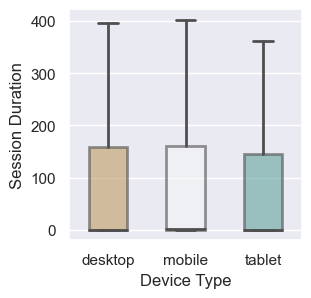

In [22]:
plt.figure(figsize=(3,3))
sns.boxplot(data=session_df , x="device_type", y="session_duration", showfliers=False, width=0.5, linewidth=2, palette='BrBG', boxprops=dict(alpha=0.6))
plt.xlabel('Device Type')
plt.ylabel('Session Duration')
plt.show()

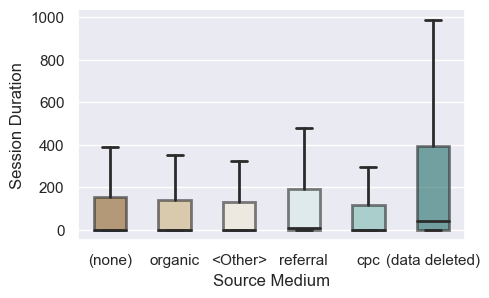

In [23]:
plt.figure(figsize=(5,3))
sns.boxplot(data=session_df , x="source_medium", y="session_duration", showfliers=False, width=0.5, linewidth=2,palette='BrBG', boxprops=dict(alpha=0.6))
plt.xlabel('Source Medium')
plt.ylabel('Session Duration')
plt.show()

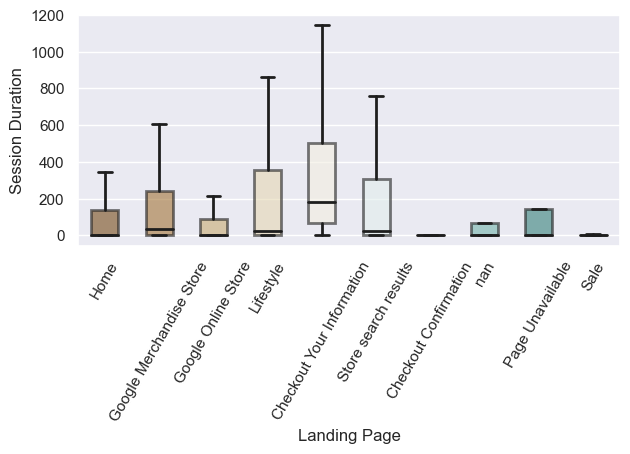

In [24]:
plt.figure(figsize=(7,3))
sns.boxplot(data=session_df , x="landing_page", y="session_duration", showfliers=False, width=0.5, linewidth=2,palette='BrBG', boxprops=dict(alpha=0.6))
plt.xlabel('Landing Page')
plt.ylabel('Session Duration')
plt.xticks(rotation = 60)
plt.show()

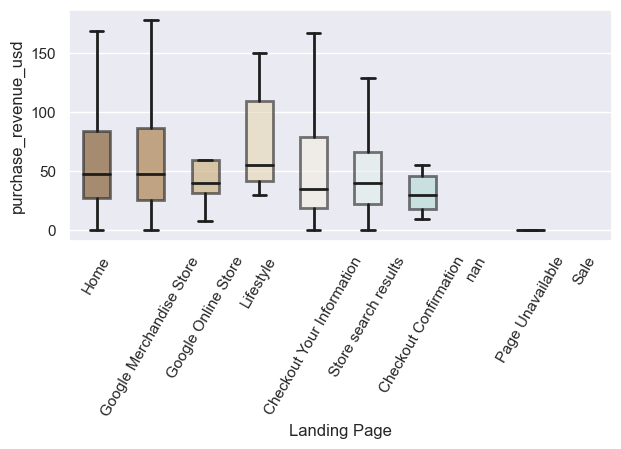

In [25]:
plt.figure(figsize=(7,3))
sns.boxplot(data=session_df , x="landing_page", y="purchase_revenue_usd", showfliers=False, width=0.5, linewidth=2,palette='BrBG', boxprops=dict(alpha=0.6))
plt.xlabel('Landing Page')
plt.ylabel('purchase_revenue_usd')
plt.xticks(rotation = 60)
plt.show()

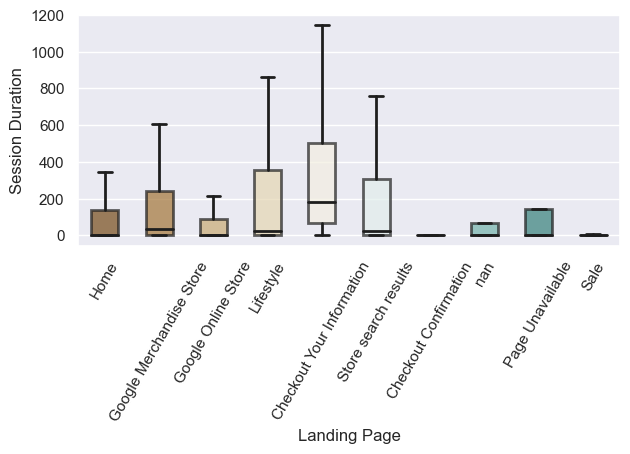

In [26]:
plt.figure(figsize=(7,3))
sns.boxplot(data=session_df , x="landing_page", y="session_duration", showfliers=False, width=0.5, linewidth=2,palette='BrBG', boxprops=dict(alpha=0.7))
plt.xlabel('Landing Page')
plt.ylabel('Session Duration')
plt.xticks(rotation = 60)
plt.show()

In [27]:
session_df.corr()

/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1979066058.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  session_df.corr()


session_duration  total_item_quantity  \
session_duration              1.000000             0.015914   
total_item_quantity           0.015914             1.000000   
purchase_revenue_usd          0.040820             0.644201   
event_count                   0.109732             0.059224   

                      purchase_revenue_usd  event_count  
session_duration                  0.040820     0.109732  
total_item_quantity               0.644201     0.059224  
purchase_revenue_usd              1.000000     0.270190  
event_count                       0.270190     1.000000

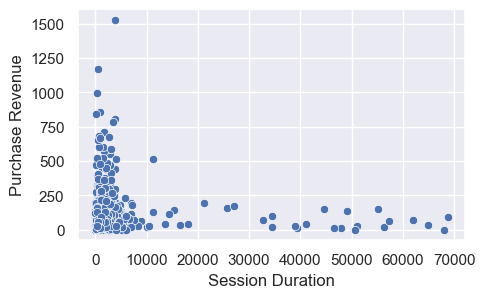

In [28]:
plt.figure(figsize=(5,3))
sns.scatterplot(session_df, x="session_duration", y="purchase_revenue_usd")
plt.xlabel('Session Duration')
plt.ylabel('Purchase Revenue')
plt.show()

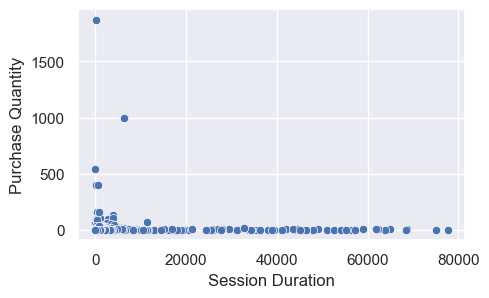

In [29]:
plt.figure(figsize=(5,3))
sns.scatterplot(session_df, x="session_duration", y="total_item_quantity")
plt.xlabel('Session Duration')
plt.ylabel('Purchase Quantity')
plt.show()

In [30]:
session_df.sort_values(by = 'total_item_quantity', ascending = False)

session_id                 session_start_ts  \
14665   249937644 2020-12-03 11:07:59.022225+00:00   
29037  3960659067 2020-12-01 15:45:41.594480+00:00   
7173   1741192629 2020-12-02 15:47:31.423648+00:00   
24334  3484942537 2020-11-17 05:07:47.154019+00:00   
78151  8993845781 2020-11-13 00:02:03.531089+00:00   
...           ...                              ...   
87833  9998642475 2020-11-09 09:44:26.738395+00:00   
87835  9998866603 2020-11-04 07:38:58.103950+00:00   
87836  9999032900 2020-11-20 23:05:24.298782+00:00   
87837  9999204937 2020-12-18 05:43:43.422764+00:00   
87838  9999254875 2020-12-01 00:30:57.670228+00:00   

                        session_end_ts  session_duration device_type  \
14665 2020-12-03 11:08:31.274565+00:00         32.252340     desktop   
29037 2020-12-01 17:29:56.121139+00:00       6254.526659      mobile   
7173  2020-12-02 15:47:41.790468+00:00         10.366820      mobile   
24334 2020-11-17 05:09:14.131819+00:00         86.977800      tablet   
78151 2020-11-13 00:11:31.451611+00:00        567.920522      mobile   
...                                ...               ...         ...   
87833 2020-11-09 09:54:58.567811+00:00        631.829416      mobile   
87835 2020-11-04 07:38:58.103950+00:00          0.000000     desktop   
87836 2020-11-20 23:05:24.298782+00:00          0.000000     desktop   
87837 2020-12-18 05:49:24.736562+00:00        341.313798     desktop   
87838 2020-12-01 00:30:57.670228+00:00          0.000000      mobile   

      continent        country   source_medium              landing_page  \
14665  Americas  United States          (none)  Google Merchandise Store   
29037  Americas  United States  (data deleted)  Google Merchandise Store   
7173   Americas  United States         <Other>                      Home   
24334  Americas         Canada         <Other>  Google Merchandise Store   
78151    Europe          Italy         organic  Google Merchandise Store   
...         ...            ...             ...                       ...   
87833    Europe         France         organic  Google Merchandise Store   
87835  Americas  United States          (none)                      Home   
87836  Americas         Mexico         <Other>                      Home   
87837      Asia          China         organic                      Home   
87838  Americas  United States          (none)                      Home   

       total_item_quantity  purchase_revenue_usd  event_count  
14665               1871.0                   NaN           36  
29037                999.0                   NaN          152  
7173                 544.0                   NaN            5  
24334                400.0                   NaN           36  
78151                400.0                1170.0           76  
...                    ...                   ...          ...  
87833                  NaN                   NaN           48  
87835                  NaN                   NaN            1  
87836                  NaN                   NaN            1  
87837                  NaN                   NaN           26  
87838                  NaN                   NaN            1  

[87839 rows x 12 columns]

<Figure size 600x400 with 0 Axes>

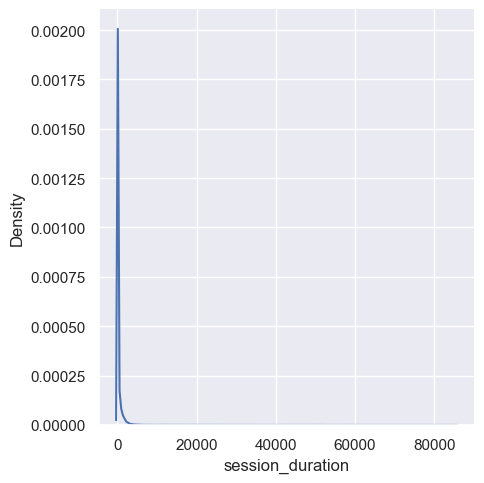

In [31]:
# Time Spent per Session
plt.figure(figsize=(6,4))
sns.displot(session_df, x="session_duration", kind="kde", bw_adjust=.25)
plt.show()

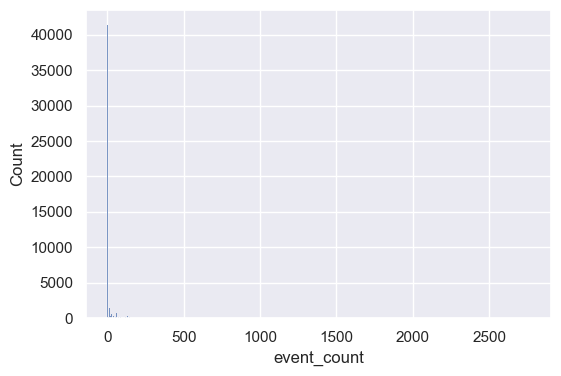

In [32]:
# Number of Events per Session
plt.figure(figsize=(6,4))
sns.histplot(session_df, x="event_count")
plt.show()

In [33]:
session_df[['device_type','session_duration']].groupby('device_type').mean()

session_duration
device_type                  
desktop            606.974260
mobile             635.797320
tablet             593.937554

In [34]:
session_df[['continent','session_duration']].groupby('continent').mean()

session_duration
continent                  
Africa           628.527450
Americas         638.780414
Asia             634.930886
Europe           530.553432
Oceania          639.917347

In [35]:
session_df[['country','session_duration']].groupby('country').mean()

session_duration
country                         
Albania              1211.121870
Algeria               434.082302
Argentina             542.489600
Armenia               867.323242
Australia             659.589516
...                          ...
United Kingdom        466.898596
United States         636.869236
Uruguay               557.856074
Venezuela            1472.779039
Vietnam               468.084943

[108 rows x 1 columns]

In [36]:
session_df[['source_medium','session_duration']].groupby('source_medium').mean()

session_duration
source_medium                   
(data deleted)        715.461823
(none)                643.896339
<Other>               593.085472
cpc                   613.856273
organic               597.906815
referral              606.072391

In [37]:
session_df.sort_values('session_duration')

session_id                 session_start_ts  \
0      1000009091 2020-12-14 09:22:52.243501+00:00   
61377  7276463524 2020-12-15 09:26:29.541170+00:00   
61376  7276383718 2020-12-24 00:09:44.300380+00:00   
30991  4164405282 2020-12-25 19:13:06.650585+00:00   
61375  7276224917 2020-11-26 07:10:02.698536+00:00   
...           ...                              ...   
40392  5131418441 2020-11-03 20:26:09.056864+00:00   
70163  8191368821 2020-11-28 16:14:58.220982+00:00   
26888  3738083025 2020-12-07 01:48:20.970057+00:00   
52466  6365712332 2020-11-19 12:54:55.929832+00:00   
10271  2058521330 2020-11-10 14:40:27.339890+00:00   

                        session_end_ts  session_duration device_type  \
0     2020-12-14 09:22:52.243501+00:00          0.000000     desktop   
61377 2020-12-15 09:26:29.541170+00:00          0.000000     desktop   
61376 2020-12-24 00:09:44.300380+00:00          0.000000     desktop   
30991 2020-12-25 19:13:06.650585+00:00          0.000000      mobile   
61375 2020-11-26 07:10:02.698536+00:00          0.000000      mobile   
...                                ...               ...         ...   
40392 2020-11-04 19:37:23.480528+00:00      83474.423664      mobile   
70163 2020-11-29 15:29:48.059775+00:00      83689.838793     desktop   
26888 2020-12-08 01:04:48.327239+00:00      83787.357182     desktop   
52466 2020-11-20 12:25:17.672917+00:00      84621.743085     desktop   
10271 2020-11-11 14:24:15.453084+00:00      85428.113194     desktop   

      continent        country source_medium              landing_page  \
0      Americas  United States        (none)                      Home   
61377  Americas  United States        (none)                      Home   
61376    Europe          Spain      referral                      Home   
30991      Asia          China        (none)                      Home   
61375  Americas         Canada       <Other>                      Home   
...         ...            ...           ...                       ...   
40392  Americas  United States       organic                      Home   
70163      Asia          India       <Other>                      Home   
26888  Americas         Canada       <Other>                      Home   
52466  Americas  United States        (none)  Google Merchandise Store   
10271      Asia      Singapore       organic                      Home   

       total_item_quantity  purchase_revenue_usd  event_count  
0                      NaN                   NaN            1  
61377                  NaN                   NaN            1  
61376                  NaN                   NaN            1  
30991                  NaN                   NaN            1  
61375                  NaN                   NaN            1  
...                    ...                   ...          ...  
40392                  NaN                   NaN            4  
70163                  NaN                   NaN          242  
26888                  NaN                   NaN            2  
52466                  NaN                   NaN           53  
10271                  NaN                   NaN            7  

[87839 rows x 12 columns]

In [541]:
df[df['session_id']=='8978472205'][['session_id','event_timestamp','page','event_name','page_type']].tail(10).rename(columns = {'page':'Page','event_name':'Event','page_type':'Category'})

session_id     event_timestamp                       Page  \
665834  8978472205 2020-12-09 02:44:29                       PP40   
665835  8978472205 2020-12-09 02:14:56                       PP24   
666733  8978472205 2020-12-09 02:42:36                       PP29   
666734  8978472205 2020-12-09 02:41:28                       PP17   
667266  8978472205 2020-12-09 02:55:32      Checkout Confirmation   
667620  8978472205 2020-12-09 02:01:34                       PP19   
668523  8978472205 2020-12-09 02:50:27                       PP40   
669094  8978472205 2020-12-09 02:52:08  Checkout Your Information   
669499  8978472205 2020-12-09 02:04:27                       PP19   
669500  8978472205 2020-12-09 02:14:06                       PP42   

                 Event                   Category  
665834       view_item              Products Page  
665835       view_item              Products Page  
666733     select_item              Products Page  
666734       view_item              Products Page  
667266        purchase      Checkout Confirmation  
667620       view_item              Products Page  
668523       view_item              Products Page  
669094  begin_checkout  Checkout Your Information  
669499       view_item              Products Page  
669500     select_item              Products Page

In [537]:
df_purchase.sample()

event_date     event_timestamp event_name  session_id  \
592121  2020-12-09 2020-12-09 02:51:00  view_item  8978472205   

                                         page_title  \
592121  Womens | Apparel | Google Merchandise Store   

                                            page_location page_referrer  \
592121  https://shop.googlemerchandisestore.com/Google...           NaN   

        event_value_in_usd event_bundle_sequence_id user_pseudo_id  \
592121                 NaN                      nan  -1187512068.0   

             user_first_touch_timestamp  user_ltv_revenue device_type browser  \
592121 2020-12-09 01:48:36.870354+00:00               0.0     desktop  Chrome   

       continent        country city source_medium source_name  \
592121  Americas  United States  NaN       <Other>     <Other>   

        total_item_quantity  purchase_revenue_usd  purchase_revenue  \
592121                  NaN                   NaN               NaN   

        refund_value transaction_id       item_id  \
592121           NaN            NaN  GGOEGXXX0963   

                                      item_name item_brand  \
592121  Google Women's Microfleece Jacket Black        NaN   

                item_category  item_price_usd  item_price  item_quantity  \
592121  Home/Apparel/Women's/             NaN        75.0            NaN   

        item_revenue_usd  item_revenue  session_with_purchase  \
592121               NaN           NaN                   True   

                                    page_title_path              page_title_1  \
592121  [Google Merchandise Store, Apparel, Womens]  Google Merchandise Store   

       page_title_2 page_title_3      page_type  page  
592121      Apparel       Womens  Products Page  PP40

### Number of Events per Session

### Where do the users come from?
- Session Count by Landing Page
- Session Count by Device Type
- Session Count by Referral

### How long do users stay?
- Session Duration by Landing Page
- Session Duration by Device Type
- Session Duration by Referral

### How likely do our users convert?
- Purchase Revenue by Landing Page
- Purchase Revenue by Device Type
- Purchase Revenue by Referral
- Conversion Rate by Landing Page
- Conversion Rate by Device Type
- Conversion Rate by Referral
- Purchase Revenue by Pattern
- Conversion Rate by Pattern

### How do they behave on the website?
- Transition Probability

In [38]:
def get_page_type(page_title):
    if page_title == 'Google Merchandise Store' or page_title == 'New' or page_title == 'Sale' or page_title == 'Lifestyle':
        return 'Products Page'
    elif page_title == 'Google Online Store':
        return 'Select Area/Region'
    elif page_title == 'The Google Merchandise Store - Log In':
        return 'Log In'
    elif page_title == 'nan':
        return np.nan
    else:
        return page_title
df['page_type'] = df['page_title_1'].apply(get_page_type)

In [39]:
df['page_type'].value_counts()

Products Page                2490298
Home                          378446
Checkout Your Information      52782
Checkout Confirmation          13077
Store search results            9209
Select Area/Region              2482
Page Unavailable                  15
Log In                             6
Name: page_type, dtype: int64

In [40]:
# Pages
products_page_list = df[df['page_type']=='Products Page']['page_title'].value_counts().index.tolist()
products_page_list.sort()
product_page_dict = dict((j,i) for i,j in enumerate(products_page_list))

def get_page_no(row):
    if row['page_type'] == 'Products Page':
        return 'PP' + str(product_page_dict[row['page_title']])
    else:
        return row['page_type']

df['page'] = df.apply(get_page_no, axis = 1)

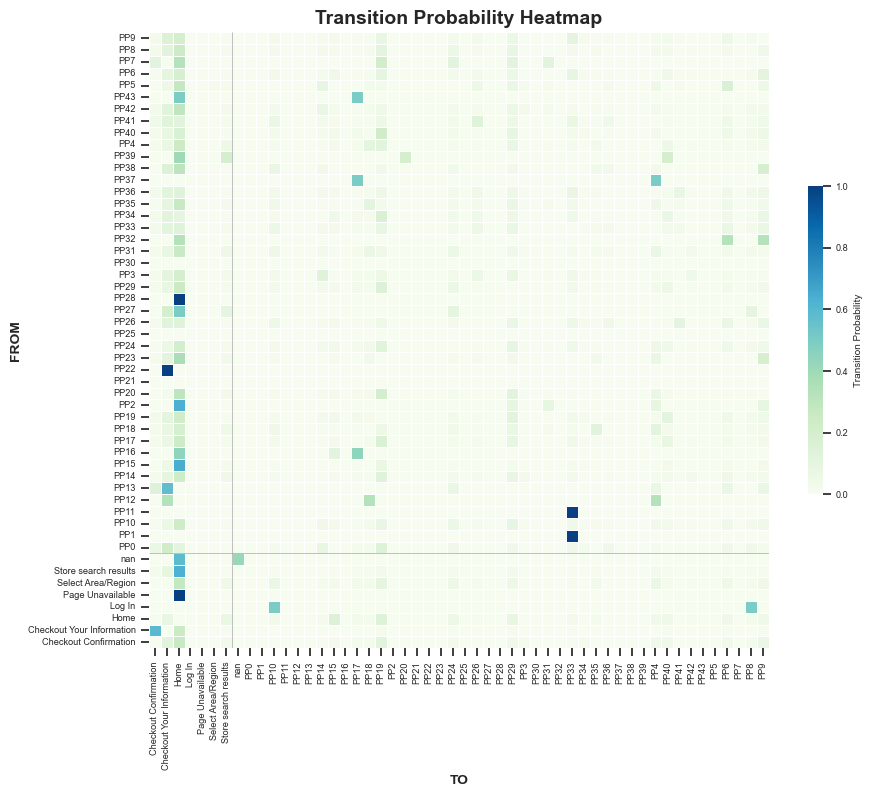

In [41]:
# Clickstream Data
clickstreams = df.sort_values(by=['session_id','event_timestamp']).groupby('session_id')['page'].apply(list).tolist()
clickstream_list = []
for clickstream in clickstreams:
    l = []
    for i in range(len(clickstream)):
        if clickstream[i] == 'nan':
            continue
        if i == 0:
            l.append(str(clickstream[i]))
            continue
        if clickstream[i] != clickstream[i-1]:
            l.append(str(clickstream[i]))
    clickstream_list.append(l)
    
# Generating Probability Matrix
m = MarkovClickstream(clickstream_list)

other_pages = []
product_pages = []
for i in m.pages:
    if not i.startswith('PP'):
        other_pages.append(i)
    else:
        product_pages.append(i)
pages_reordered = other_pages + product_pages

prob_matrix = pd.DataFrame(m.prob_matrix, columns = m.pages, index = m.pages)#.drop(columns = ['nan']).drop(index = ['nan'])
prob_matrix = prob_matrix[pages_reordered]
pages_reordered.reverse()
prob_matrix = prob_matrix.reindex(pages_reordered)

# Plotting Heatmap
sns.set(font_scale = 0.6)
plt.figure(figsize=(10,8))
ax = sns.heatmap(prob_matrix, cmap='GnBu', linewidths=0.5, linecolor='white', cbar_kws={"shrink": 0.5})
ax.hlines([44], *ax.get_xlim(), color = 'gray', alpha = 0.7, linewidth = 0.5)
ax.vlines([7], *ax.get_xlim(), color = 'gray', alpha = 0.7, linewidth = 0.5)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.collections[0].colorbar.set_label("Transition Probability")
plt.title("Transition Probability Heatmap", fontsize = 14, fontweight="bold")
plt.xlabel("TO", fontsize = 10, fontweight="bold")
plt.ylabel("FROM", fontsize = 10, fontweight="bold")
plt.show()
# The more bluish the colour, the more probable the transition will occur.

In [42]:
# from markovclick.viz import visualise_markov_chain
# # graph = visualise_markov_chain(m)
# # graph

In [43]:
# Preprocessing Clickstream Data (Sessionizing)
from markovclick.preprocessing import Sessionise
df['event_timestamp'] = df['event_timestamp'].values.astype('datetime64[s]')
df['page'] = df['page'].apply(lambda x: str(x))
df['event_name'] = df['event_name'].apply(lambda x: str(x))
df['page_type'] = df['page_type'].apply(lambda x: str(x))
df_drop_dup_times = df.drop_duplicates(subset = ['session_id','event_timestamp','page'], keep='first')
df_drop_dup_times = df_drop_dup_times.sort_values(['session_id','event_timestamp'])
sessioniser = Sessionise(df_drop_dup_times[['session_id','event_timestamp','page']].sort_values(by=['session_id','event_timestamp']), 
                         unique_id_col='session_id',datetime_col='event_timestamp', session_timeout=30)
sess_df = sessioniser.assign_sessions(n_jobs=1)
df_grouped = sess_df.groupby(['session_uuid'])['page'].apply(list)

In [44]:
# Determinimg Order with AIC and BIC
clickstream_r = pd.DataFrame({'clickstream':sess_df.groupby(['session_uuid'])['page'].apply(list)})
clickstream_r['num_events'] = pd.DataFrame({'clickstream':sess_df.groupby(['session_uuid'])['page'].apply(list)})['clickstream'].apply(lambda x: len(x))
clickstream_r = clickstream_r[clickstream_r['num_events'] > 1].drop(columns = ['num_events'])

with open("out.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(clickstream_r['clickstream'].to_list())
    
pd.read_csv('outputs/order.csv')

Order           AIC           BIC
0      1  6.951561e+05  6.957042e+05
1      2  6.952601e+05  6.963563e+05
2      0  1.533013e+06  1.533013e+06

Given the AIC and BIC values, we will model our clickstream data with a Markov Chain of order **k=1**.

In [45]:
def vectorize_clickstream(data_grouped):
    vocab, index = {}, 1  # start indexing from 1
    for token in set(list(itertools.chain(*data_grouped))):
        if token not in vocab:
            vocab[token] = index
            index += 1
    return vocab

In [46]:
### Split into Purchase and Non-purchase
df_purchase = df_drop_dup_times[df_drop_dup_times['session_with_purchase'] == True]
df_nonpurchase = df_drop_dup_times[df_drop_dup_times['session_with_purchase'] == False]

def sessionize_page(dataframe, index = False):
    sessioniser = Sessionise(dataframe[['session_id','event_timestamp', 'page']].sort_values(by=['session_id','event_timestamp']), 
                             unique_id_col='session_id',datetime_col='event_timestamp', session_timeout=30)
    sess_df = sessioniser.assign_sessions(n_jobs=1)
    df_grouped = sess_df.groupby(['session_id'])['page'].apply(list)
    
    if index == True:
        lookup = vectorize_clickstream(df_grouped)
        sess_df['page_index'] = sess_df['page'].map(lookup)
        df_grouped = sess_df.groupby(['session_id'])['page_index'].apply(list)
        return sess_df, df_grouped, lookup
    else: return sess_df, df_grouped

def sessionize_cat(dataframe, index = False):
    sessioniser = Sessionise(dataframe[['session_id','event_timestamp', 'page_type']].sort_values(by=['session_id','event_timestamp']), 
                             unique_id_col='session_id',datetime_col='event_timestamp', session_timeout=30)
    sess_df = sessioniser.assign_sessions(n_jobs=1)
    df_grouped = sess_df.groupby(['session_id'])['page_type'].apply(list)
    
    if index == True:
        lookup = vectorize_clickstream(df_grouped)
        sess_df['page_type_index'] = sess_df['page_type'].map(lookup)
        df_grouped = sess_df.groupby(['session_id'])['page_type_index'].apply(list)
        return sess_df, df_grouped, lookup
    else: return sess_df, df_grouped

def sessionize_event(dataframe, index = False):
    sessioniser = Sessionise(dataframe[['session_id','event_timestamp', 'event_name']].sort_values(by=['session_id','event_timestamp']), 
                             unique_id_col='session_id',datetime_col='event_timestamp', session_timeout=30)
    sess_df = sessioniser.assign_sessions(n_jobs=1)
    df_grouped = pd.DataFrame(sess_df.groupby(['session_id'])['event_name'].apply(list))['event_name'].apply(lambda x: x + ['exit'])
    
    if index == True:
        lookup = vectorize_clickstream(df_grouped)
        sess_df['event_name_index'] = sess_df['event_name'].map(lookup)
        df_grouped = sess_df.groupby(['session_id'])['event_name_index'].apply(list)
        return sess_df, df_grouped, lookup
    else: return sess_df, df_grouped

In [47]:
### Constructing Probability Matrix
def plot_trans_matrix_page(clickstream_data, title, empyty_purchase = False):
    m = MarkovClickstream(clickstream_data)
    product_pages = []
    for i in m.pages:
        if i.startswith('PP'):
            product_pages.append(i)
    other_pages = ['Select Area/Region','Home','Store search results',
                   'Checkout Your Information','Checkout Confirmation','Page Unavailable']
    pages_reordered = other_pages + product_pages
    prob_matrix = pd.DataFrame(m.prob_matrix, columns = m.pages, index = m.pages)#.drop(columns = ['nan']).drop(index = ['nan'])
    if empyty_purchase == True:
        prob_matrix['Checkout Confirmation'] = 0
        prob_matrix.loc['Checkout Confirmation'] = 0
    prob_matrix = prob_matrix[pages_reordered]
    # pages_reordered.reverse()
    prob_matrix = prob_matrix.reindex(pages_reordered)

    # Plotting Heatmap
    sns.set(font_scale = 0.6)
    plt.figure(figsize=(10,8))
    ax = sns.heatmap(prob_matrix, cmap='YlGnBu', linewidths=0.5, linecolor='white', cbar_kws={"shrink": 0.5})
    ax.hlines([len(other_pages)], *ax.get_xlim(), color = 'gray', alpha = 0.7, linewidth = 0.5)
    ax.vlines([len(other_pages)], *ax.get_xlim(), color = 'gray', alpha = 0.7, linewidth = 0.5)
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.collections[0].colorbar.set_label("Transition Probability")
    plt.title(title, fontsize = 14, fontweight="bold")
    plt.xlabel("TO", fontsize = 10, fontweight="bold")
    plt.ylabel("FROM", fontsize = 10, fontweight="bold")
    plt.show() 
    
def plot_trans_matrix_cat(clickstream_data, title, empyty_purchase = False):

    # Constructing Probability Matrix
    m = MarkovClickstream(clickstream_data)
    prob_matrix = pd.DataFrame(m.prob_matrix, columns = m.pages, index = m.pages)
    if empyty_purchase == True:
        prob_matrix['Checkout Confirmation'] = 0
        prob_matrix.loc['Checkout Confirmation'] = 0
    pages_reordered = ['Select Area/Region','Home','Store search results','Products Page',
                       'Checkout Your Information','Checkout Confirmation','Page Unavailable']
    prob_matrix = prob_matrix.reindex(pages_reordered)
    prob_matrix = prob_matrix[pages_reordered]

    # Plotting Heatmap
    sns.set(font_scale = 0.8)
    plt.figure(figsize=(5,4))
    ax = sns.heatmap(prob_matrix, cmap='YlGnBu', linewidths=0.8, linecolor='white', cbar_kws={"shrink": 0.6}, annot=True, annot_kws={"fontsize":8})
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.collections[0].colorbar.set_label("Transition Probability")
    plt.title(title, fontsize = 12, fontweight="bold")
    plt.xlabel("TO", fontsize = 10, fontweight="bold")
    plt.ylabel("FROM", fontsize = 10, fontweight="bold")
    plt.show()

def plot_trans_matrix_events(clickstream_data, title, empyty_purchase = False):

    # Constructing Probability Matrix
    m = MarkovClickstream(clickstream_data)
    prob_matrix = pd.DataFrame(m.prob_matrix, columns = m.pages, index = m.pages)
    if empyty_purchase == True:
        prob_matrix['purchase'] = 0
        prob_matrix.loc['purchase'] = 0
    pages_reordered = ['view_promotion','view_item','select_promotion','select_item','add_to_cart',
                       'begin_checkout','purchase','exit']
    prob_matrix = prob_matrix.reindex(pages_reordered)
    prob_matrix = prob_matrix[pages_reordered]

    # Plotting Heatmap
    sns.set(font_scale = 0.8)
    plt.figure(figsize=(5,4))
    ax = sns.heatmap(prob_matrix, cmap='YlGnBu', linewidths=0.8, linecolor='white', cbar_kws={"shrink": 0.6}, annot=True, annot_kws={"fontsize":8})
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    # ax.collections[0].colorbar.set_label("Transition Probability")
    plt.title(title, fontsize = 12, fontweight="bold")
    plt.xlabel("TO", fontsize = 10, fontweight="bold")
    plt.ylabel("FROM", fontsize = 10, fontweight="bold")
    plt.show()

In [48]:
from graphviz import Digraph
import numpy as np
from markovclick.models import MarkovClickstream


def visualise_markov_chain(markov_chain: MarkovClickstream) -> Digraph:
    """
    Visualises Markov chain for clickstream as a graph, with individual pages
    as nodes, and edges between the first and second most likely nodes (pages).
    Probabilities for these transitions are annotated on the edges (arrows).

    Args:
        markov_chain (MarkovClickstream): Initialised MarkovClickstream object
            with probabilities computed.

    Returns:
        Digraph: Graphviz Digraph object, which can be rendered as an image or
            PDF, or displayed inside a Jupyter notebook.
    """
    if not isinstance(markov_chain, MarkovClickstream):
        raise TypeError(
            f'Argument `markov_chain` must be of type '
            f'MarkovClickstream. {type(markov_chain)} object provided '
            f'instead.'
        )
    graph = Digraph()
    prob = markov_chain.prob_matrix
    prob_matrix_sorted = np.argsort(markov_chain.prob_matrix, axis=1)
    nodes = markov_chain.pages
    for i, node in enumerate(nodes):
        graph.node(
            node, node, style='filled', fillcolor='#61bdcd',
            fontname='Helvetica', penwidth='0', fontcolor='white',fontsize='12'
        )
        first_trans = nodes[prob_matrix_sorted[i, -1]]
        most_prob = prob[i, prob_matrix_sorted[i, -1]]
        graph.edge(
            node, first_trans,
            label=f'{most_prob:.2f}',
            fontname='Helvetica', penwidth='1.5',
            color='#90caf9', arrowsize='0.75'
        )
        second_prob = prob[i, prob_matrix_sorted[i, -2]]
        sec_trans = nodes[prob_matrix_sorted[i, -2]]
        graph.edge(
            node, sec_trans,
            label=f'   {second_prob:.2f}',
            fontname='Helvetica', penwidth='0.75',
            fontsize='10', color='#90caf9', arrowsize='0.5'
        )
        if node != first_trans and node != sec_trans:
            graph.edge(
                node, node,
                label=f'   {prob[i, i]:.2f}',
                fontname='Helvetica', penwidth='1.8',
                fontsize='10', color='#cfd8dc', arrowsize='0.5'
            )
    return graph

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
# graph = visualise_markov_chain(m)
# graph

In [297]:
sess_df_p, df_grouped_p = sessionize_page(df_purchase)
sess_df_np, df_grouped_np = sessionize_page(df_nonpurchase)

In [298]:
### Determinimg Markov Chain Order with AIC and BIC Value
# Purchase
clickstream_p = pd.DataFrame({'clickstream':sess_df_p.groupby(['session_uuid'])['page'].apply(list)})
clickstream_p['num_events'] = pd.DataFrame({'clickstream':sess_df_p.groupby(['session_uuid'])['page'].apply(list)})['clickstream'].apply(lambda x: len(x))
clickstream_p = clickstream_p[clickstream_p['num_events'] > 1].drop(columns = ['num_events'])

with open("clickstream-purchase-order.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(clickstream_p['clickstream'].to_list())
    
order_eval_p = pd.read_csv('outputs/purchase-order-results.csv')

# Non-purchase
clickstream_np = pd.DataFrame({'clickstream':sess_df_np.groupby(['session_uuid'])['page'].apply(list)})
clickstream_np['num_events'] = pd.DataFrame({'clickstream':sess_df_np.groupby(['session_uuid'])['page'].apply(list)})['clickstream'].apply(lambda x: len(x))
clickstream_np = clickstream_np[clickstream_np['num_events'] > 1].drop(columns = ['num_events'])

with open("clickstream-nonpurchase-order.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(clickstream_np['clickstream'].to_list())
    
order_eval_np = pd.read_csv('outputs/nonpurchase-order-results.csv')

order_eval_p['Cluster'] = 'Purchase'
order_eval_np['Cluster'] = 'Non-Purchase'
order_eval = pd.concat([order_eval_p,order_eval_np])
order_eval['AIC'] = order_eval['AIC'].apply(lambda x: '%.5f' % x)
order_eval['BIC'] = order_eval['BIC'].apply(lambda x: '%.5f' % x)
order_eval[['Cluster','Order','AIC','BIC']]

Cluster  Order            AIC            BIC
0      Purchase      0   358740.99630   358740.99630
1      Purchase      1   173331.35302   173694.08849
2      Purchase      2   173411.35302   174136.82396
0  Non-Purchase      0  1145267.89748  1145267.89748
1  Non-Purchase      1   505611.58550   506135.84022
2  Non-Purchase      2   505713.58550   506762.09494

In [299]:
sess_df_p, df_grouped_p = sessionize_page(df_purchase)
sess_df_np, df_grouped_np = sessionize_page(df_nonpurchase)

In [300]:
# plot_trans_matrix_page(df_grouped, "Transition Probability Heatmap\n(Page-Level)") 

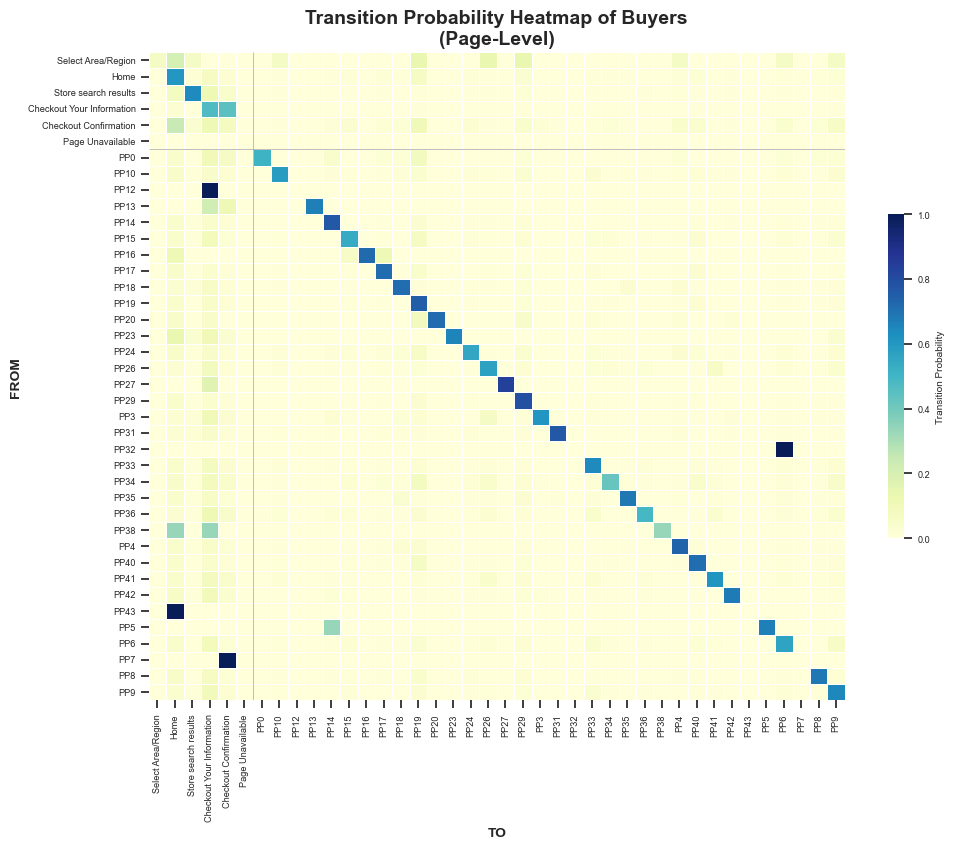

In [301]:
plot_trans_matrix_page(df_grouped_p, "Transition Probability Heatmap of Buyers\n(Page-Level)") 

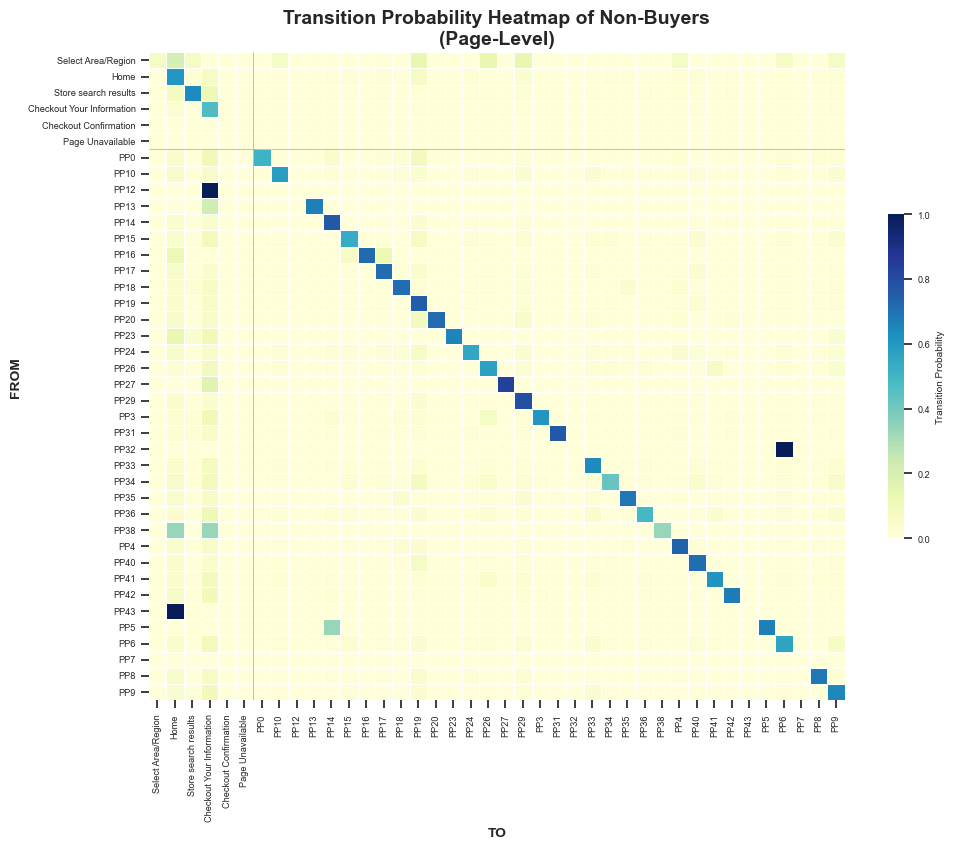

In [302]:
plot_trans_matrix_page(df_grouped_p, "Transition Probability Heatmap of Non-Buyers\n(Page-Level)", True) 

In [343]:
sess_df_p, df_grouped_p = sessionize_event(df_purchase)
sess_df_np, df_grouped_np = sessionize_event(df_nonpurchase)

In [344]:
# plot_trans_matrix_events(df_grouped, "Transition Probability Heatmap\n(Event-Level)")

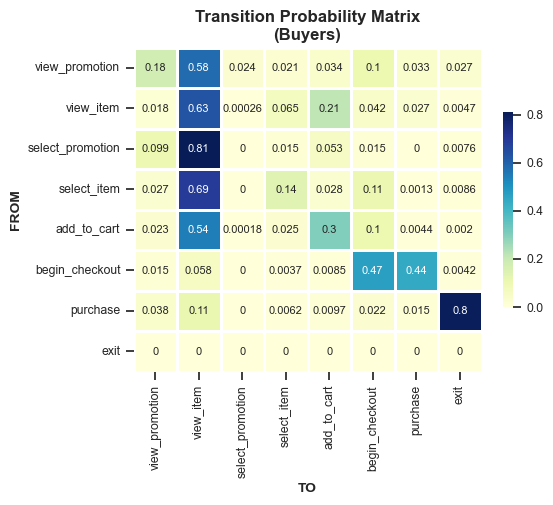

In [350]:
plot_trans_matrix_events(df_grouped_p, "Transition Probability Matrix\n(Buyers)")

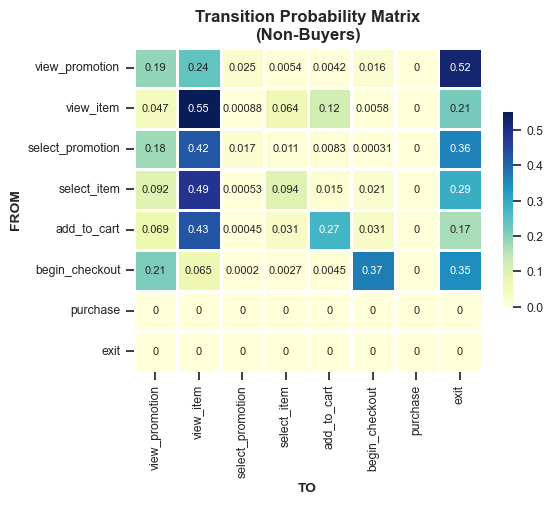

In [351]:
plot_trans_matrix_events(df_grouped_np, "Transition Probability Matrix\n(Non-Buyers)", True)

In [307]:
sess_df_p, df_grouped_p = sessionize_cat(df_purchase)
sess_df_np, df_grouped_np = sessionize_cat(df_nonpurchase)

In [308]:
# plot_trans_matrix_cat(df_grouped, "Transition Probability Heatmap\n(Category-Level)", empyty_purchase = False)

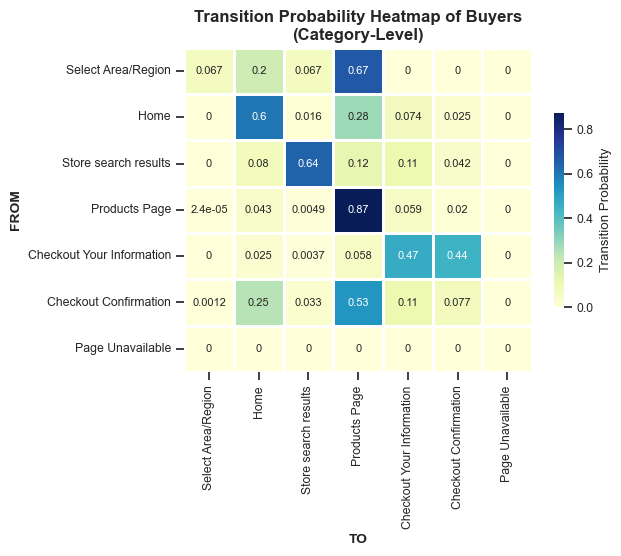

In [309]:
plot_trans_matrix_cat(df_grouped_p, "Transition Probability Heatmap of Buyers\n(Category-Level)")

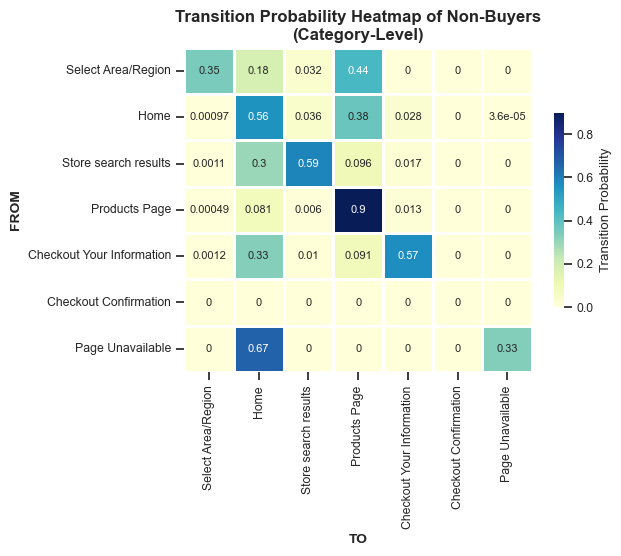

In [310]:
plot_trans_matrix_cat(df_grouped_np, "Transition Probability Heatmap of Non-Buyers\n(Category-Level)", empyty_purchase = True)

## Markov Chain Model to Predict Purchase

In [311]:
df_grouped_np#.sample(1000)

session_id
1000009091                                               [Home]
1000075392                                         [Home, Home]
1000172345                                               [Home]
1000175006    [Products Page, Products Page, Products Page, ...
1000178538    [Home, Products Page, Products Page, Products ...
                                    ...                        
9998866603                                               [Home]
9999032900                                               [Home]
9999204937           [Home, Home, Products Page, Products Page]
9999254875                                               [Home]
9999521900                 [Home, Products Page, Products Page]
Name: page_type, Length: 84111, dtype: object

In [353]:
def PreprocessingMM(df_p, df_np, level, purchase_terms):
   
    ### Train Test Split
    df_np = df_np.sample(7500, random_state=42)
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(df_p, np.ones(len(df_p)), test_size=0.3, random_state=42)
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(df_np, np.zeros(len(df_np)), test_size=0.3, random_state=42)
    
    ### Preventing Data Leakage
    def remove_purchase_event(clickstream):
        new_list = []
        for event in clickstream:
            if event not in purchase_terms:
                new_list.append(event)
        return new_list
    
    X_train_p = pd.DataFrame(X_train_p)[level].apply(remove_purchase_event)
    X_test_p = pd.DataFrame(X_test_p)[level].apply(remove_purchase_event)
    X_train_np = pd.DataFrame(X_train_np)[level].apply(remove_purchase_event)
    X_test_np = pd.DataFrame(X_test_np)[level].apply(remove_purchase_event)
    
    X_test = pd.concat([X_test_p,X_test_np])
    y_test = np.concatenate([y_test_p,y_test_np])
    
    # Data Cleaning (Removing short clickstreams and clickstreams with rare events)
    cleaned_X_test, cleaned_y_test, cleaned_X_train_p, cleaned_X_train_np = [], [], [], []
    
    for i in range(len(X_train_p)):
        if len(X_train_p[i]) > 0:
            cleaned_X_train_p.append(X_train_p[i])
            
    for i in range(len(X_train_np)):
        if len(X_train_np[i]) > 0:
            cleaned_X_train_np.append(X_train_np[i])
    
    X_train_p_uniq = set(list(itertools.chain(*cleaned_X_train_p)))
    X_train_np_uniq = set(list(itertools.chain(*cleaned_X_train_np)))
    
    for i in range(len(X_test)):
        if (len(X_test[i]) > 0) and (set(X_test[i]).issubset(X_train_p_uniq)) and (set(X_test[i]).issubset(X_train_np_uniq)):
            cleaned_X_test.append(X_test[i])
            cleaned_y_test.append(y_test[i])
    
    return cleaned_X_train_p, y_train_p, cleaned_X_train_np, y_train_np, cleaned_X_test, cleaned_y_test

In [354]:
class MarkovModel():
    
    def __init__(self):
        self.preds = []
        self.log_odds = []
        self.probas = []
    def fit(self, X_p_train, X_np_train, y_p_train, y_np_train):
        
        self.m_p = MarkovClickstream(X_p_train)
        self.m_np = MarkovClickstream(X_np_train)
        
    def predict(self, test_X, cutoff = None):
        self.cutoff = cutoff
        self.preds = []
        
        # Transition Probability Matrices
        tp_p = self.m_p.prob_matrix
        tp_np = self.m_np.prob_matrix
        
        # Calculating Log-odds Ratio
        self.log_odds = []
        self.probas = []
        for pages in test_X:
            if self.cutoff == None:
                self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages)/self.m_np.calc_prob_to_page(pages)))
            else:
                self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
        
        def sigmoid(x):
            return 1 / (1 + math.exp(-x))
        
        for i in self.log_odds:
            if math.isnan(sigmoid(i)) == False:
                self.probas.append(sigmoid(i))
            else:
                self.probas.append(0.5)
        for i in self.probas:
            if i > 0.5: self.preds.append(1)
            else: self.preds.append(0)

In [355]:
def evaluation(dataframe, model_name, y_test, preds, probas):
    new_row = {'Model': model_name,
               'AUC Score': roc_auc_score(y_test, probas, average='macro'), 
               'F1 Score (Fraud)': precision_recall_fscore_support(y_test, preds)[2][1], 
               'Precision (Fraud)': precision_recall_fscore_support(y_test, preds)[0][1],
               'Recall (Fraud)': precision_recall_fscore_support(y_test, preds)[1][1],
               'Average Precision': average_precision_score(y_test, preds)
              }
               
    dataframe = dataframe.append(new_row, ignore_index=True)
    
    return dataframe

In [357]:
### Training on Page-Level Clickstream Data

sess_df_p, df_grouped_p = sessionize_page(df_purchase)
sess_df_np, df_grouped_np = sessionize_page(df_nonpurchase)
X_train_p, y_train_p, X_train_np, y_train_np, X_test, y_test_page = PreprocessingMM(df_grouped_p, df_grouped_np, 'page',['Checkout Confirmation'])

model = MarkovModel()
model.fit(X_train_p, X_train_np, y_train_p, y_train_np)

scores_dict_page = {'f1_score':[],'recall':[],'f1_score (purchase)':[],'accuracy':[],'roc_auc_score':[]}
for i in range(2,31):
    model.predict(X_test, cutoff = i)
    y_preds = model.preds
    y_probas_page = model.probas
    precision,recall,f1_score,_ = precision_recall_fscore_support(y_test_page, y_preds, average='weighted')
    f1_purchase = precision_recall_fscore_support(y_test_page, y_preds)[2][1]
    accuracy = accuracy_score(y_test_page, y_preds)
    roc_auc = roc_auc_score(y_test_page, y_probas_page, average = 'weighted')
    scores_dict_page['f1_score'].append(f1_score)
    scores_dict_page['recall'].append(recall)
    scores_dict_page['f1_score (purchase)'].append(f1_purchase)
    scores_dict_page['accuracy'].append(accuracy)
    scores_dict_page['roc_auc_score'].append(roc_auc)
scores_dict_page

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: divide by zero encountered in log
  self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: invalid value encountered in double_sc

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: invalid value encountered in double_scalars
  self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: divide by zero encountered i

Probability for clickstream: 
 PP19:PP19:PP19:PP19:PP33:PP33:PP33:PP33:PP40:PP40:PP40:PP40:Checkout Your Information 
is2.3275581782503084e-07
Probability for clickstream: 
 PP19:PP19:PP19:PP19:PP33:PP33:PP33:PP33:PP40:PP40:PP40:PP40:Checkout Your Information 
is8.488013096924717e-09
Probability for clickstream: 
 Home:PP19:PP19:PP19:PP19:PP19:PP19:PP19:PP19:Home:PP19:PP19:PP19:Checkout Your Information:Checkout Your Information 
is7.5232263846676e-07
Probability for clickstream: 
 Home:PP19:PP19:PP19:PP19:PP19:PP19:PP19:PP19:Home:PP19:PP19:PP19:Checkout Your Information:Checkout Your Information 
is1.354866328424909e-07
Probability for clickstream: 
 Home 
is1
Probability for clickstream: 
 Home 
is1
Probability for clickstream: 
 Checkout Your Information:Checkout Your Information 
is0.7643484132343011
Probability for clickstream: 
 Checkout Your Information:Checkout Your Information 
is0.6079295154185022
Probability for clickstream: 
 PP20:PP20:PP20:PP20:Home:PP6:PP6:PP6 
is7.652109

/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: invalid value encountered in double_scalars
  self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: divide by zero encountered in log
  self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  self.log_odds.append(np.log(self.m_p.calc_prob_

{'f1_score': [0.663605329911217,
  0.6738003990442188,
  0.6808376744284923,
  0.6953923761630686,
  0.7041731040974796,
  0.7101523647173259,
  0.7145964243076879,
  0.7207892427863085,
  0.7231643759389108,
  0.7260708114830193,
  0.7318072775083124,
  0.7346867207494557,
  0.7413700584844541,
  0.7440255321856294,
  0.7459181867465133,
  0.746664368873403,
  0.7493233267702049,
  0.7499849563605292,
  0.7534523568075908,
  0.7546974380427565,
  0.7565622510000491,
  0.7587022500163025,
  0.7608702136527565,
  0.7636511620564407,
  0.7648848553325135,
  0.7660888980515909,
  0.7670404946642405,
  0.7676556233379477,
  0.7685776828074765],
 'recall': [0.6619633743620534,
  0.6745722005403783,
  0.6823776643650555,
  0.6952867006904834,
  0.7027919543680576,
  0.7081957370159111,
  0.7126988892224557,
  0.7184028820174122,
  0.720504353047133,
  0.7232062443710597,
  0.7286100270189132,
  0.73131191834284,
  0.7376163314320024,
  0.7400180126088262,
  0.741819273491444,
  0.74241969378

In [358]:
### Training on Event-Level Clickstream Data

sess_df_p, df_grouped_p = sessionize_event(df_purchase)
sess_df_np, df_grouped_np = sessionize_event(df_nonpurchase)
X_train_p, y_train_p, X_train_np, y_train_np, X_test, y_test_event = PreprocessingMM(df_grouped_p, df_grouped_np, 'event_name',['purchase','exit'])

model = MarkovModel()
model.fit(X_train_p, X_train_np, y_train_p, y_train_np)

scores_dict_event = {'f1_score':[],'recall':[],'f1_score (purchase)':[],'accuracy':[],'roc_auc_score':[]}
for i in range(2,31):
    model.predict(X_test, cutoff = i)
    y_preds = model.preds
    y_probas_event = model.probas
    precision,recall,f1_score,_ = precision_recall_fscore_support(y_test_event, y_preds, average='weighted')
    f1_purchase = precision_recall_fscore_support(y_test_event, y_preds)[2][1]
    accuracy = accuracy_score(y_test_event, y_preds)
    roc_auc = roc_auc_score(y_test_event, y_probas_event, average = 'weighted')
    scores_dict_event['f1_score'].append(f1_score)
    scores_dict_event['recall'].append(recall)
    scores_dict_event['f1_score (purchase)'].append(f1_purchase)
    scores_dict_event['accuracy'].append(accuracy)
    scores_dict_event['roc_auc_score'].append(roc_auc)
scores_dict_event

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: divide by zero encountered 

Probability for clickstream: 
 view_promotion:view_item 
is0.6183026984747751
Probability for clickstream: 
 view_promotion:view_item 
is0.4950419527078566
Probability for clickstream: 
 view_promotion 
is1
Probability for clickstream: 
 view_promotion 
is1
Probability for clickstream: 
 view_promotion 
is1
Probability for clickstream: 
 view_promotion 
is1
Probability for clickstream: 
 view_promotion 
is1
Probability for clickstream: 
 view_promotion 
is1
Probability for clickstream: 
 view_promotion 
is1
Probability for clickstream: 
 view_promotion 
is1
Probability for clickstream: 
 view_promotion:view_promotion 
is0.19123973406335548
Probability for clickstream: 
 view_promotion:view_promotion 
is0.3901601830663616
Probability for clickstream: 
 view_promotion:select_promotion 
is0.024247164646069613
Probability for clickstream: 
 view_promotion:select_promotion 
is0.057208237986270026
Probability for clickstream: 
 view_promotion 
is1
Probability for clickstream: 
 view_promotio

{'f1_score': [0.7421148744909329,
  0.7488680662262457,
  0.7599792698516137,
  0.773375905521142,
  0.7399307683738077,
  0.7488467586702539,
  0.7550370650663246,
  0.7596114285506891,
  0.7655903795243586,
  0.7691219791892817,
  0.7705512244602233,
  0.7725839018095365,
  0.7740033901764575,
  0.7764930019732331,
  0.7787769018452116,
  0.7833923549952102,
  0.7845726491258144,
  0.7872254555819149,
  0.7899259414151395,
  0.7925040362958116,
  0.7938181652367285,
  0.7954577807799632,
  0.7971465777351736,
  0.7993792661287469,
  0.7997052020608785,
  0.8006822305503274,
  0.802308031300499,
  0.8026328070743701,
  0.803232707356819],
 'recall': [0.7435820895522388,
  0.7513432835820896,
  0.7620895522388059,
  0.7749253731343284,
  0.748955223880597,
  0.7561194029850746,
  0.7614925373134328,
  0.7653731343283582,
  0.7704477611940298,
  0.7737313432835821,
  0.7749253731343284,
  0.7767164179104478,
  0.777910447761194,
  0.78,
  0.7820895522388059,
  0.7862686567164179,
  0.78

In [359]:
### Training on Category-Level Clickstream Data

sess_df_p, df_grouped_p = sessionize_cat(df_purchase)
sess_df_np, df_grouped_np = sessionize_cat(df_nonpurchase)
X_train_p, y_train_p, X_train_np, y_train_np, X_test, y_test_cat = PreprocessingMM(df_grouped_p, df_grouped_np, 'page_type',['Checkout Confirmation'])

model = MarkovModel()
model.fit(X_train_p, X_train_np, y_train_p, y_train_np)

scores_dict_cat = {'f1_score':[],'recall':[],'f1_score (purchase)':[],'accuracy':[],'roc_auc_score':[]}
for i in range(2,31):
    model.predict(X_test, cutoff = i)
    y_preds = model.preds
    y_probas_cat = model.probas
    precision,recall,f1_score,_ = precision_recall_fscore_support(y_test_cat, y_preds, average='weighted')
    f1_purchase = precision_recall_fscore_support(y_test_cat, y_preds)[2][1]
    accuracy = accuracy_score(y_test_cat, y_preds)
    roc_auc = roc_auc_score(y_test_cat, y_probas_cat, average = 'weighted')
    scores_dict_cat['f1_score'].append(f1_score)
    scores_dict_cat['recall'].append(recall)
    scores_dict_cat['f1_score (purchase)'].append(f1_purchase)
    scores_dict_cat['accuracy'].append(accuracy)
    scores_dict_cat['roc_auc_score'].append(roc_auc)
scores_dict_cat

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: invalid value encountered in double_scalars
  self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: invalid value encountered in double_scalars
  self.log_odds.append(np.log(self.m_p.calc_prob_to_page(pages[:self.cutoff])/self.m_np.calc_prob_to_page(pages[:self.cutoff])))
/var/folders/wy/gmfr1dfd72d5g9h5r030cm6m0000gn/T/ipykernel_32498/1214471858.py:27: RuntimeWarning: invalid value encountered in 

{'f1_score': [0.6179692746553531,
  0.6070643843882149,
  0.6152571591519459,
  0.6365174653046728,
  0.6488382901411262,
  0.6585349880337908,
  0.6701513772540969,
  0.6792503765101656,
  0.691289653553016,
  0.7009469161868235,
  0.707469602437214,
  0.718190718554963,
  0.7214848458166043,
  0.7280647540810399,
  0.7345174765412678,
  0.7381669875743596,
  0.742935712362113,
  0.7479226264571682,
  0.7520126806449896,
  0.7571172388917786,
  0.7598673005147446,
  0.7636311250684261,
  0.768661711580267,
  0.7713691302299048,
  0.7723818179912106,
  0.7725166461709336,
  0.7731901127441981,
  0.7764835810277007,
  0.7778234543174349],
 'recall': [0.6420047732696897,
  0.6464797136038186,
  0.6551312649164678,
  0.6694510739856802,
  0.6778042959427207,
  0.684964200477327,
  0.6933174224343676,
  0.7001789976133651,
  0.7094272076372315,
  0.7171837708830548,
  0.722255369928401,
  0.7306085918854416,
  0.7332935560859188,
  0.7383651551312649,
  0.7437350835322196,
  0.746718377088

Selecting cutoffs: consider average number of events per session

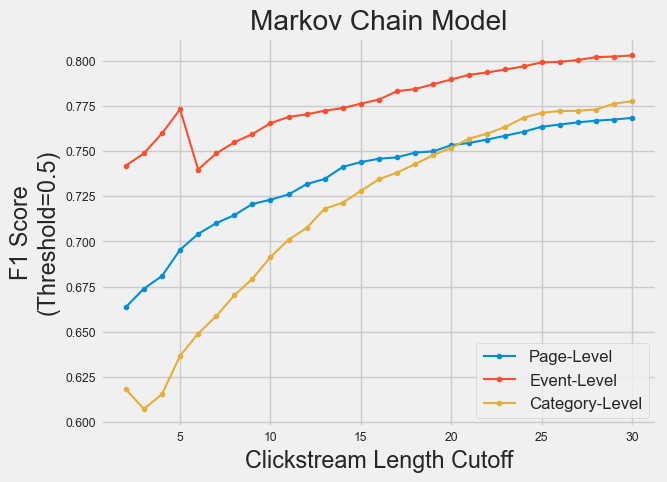

In [321]:
plt.style.use('fivethirtyeight')
plt.xlabel("Clickstream Length Cutoff")
plt.ylabel("F1 Score\n(Threshold=0.5)")
#plt.axis([-0.8, max(df_LSTM_scores.index)+0.8, 0, 1])
plt.title('Markov Chain Model')
#plt.plot(df_LSTM_scores.index, df_LSTM_scores['Precision'],label="Precision", marker='o')
#plt.plot(df_LSTM_scores.index, df_LSTM_scores['Recall'], label="Recall", marker='o')
plt.plot(range(2,31), scores_dict_page['f1_score'], label="Page-Level", marker='o',linewidth=1.5, markersize=3)
plt.plot(range(2,31), scores_dict_event['f1_score'], label="Event-Level", marker='o',linewidth=1.5, markersize=3)
plt.plot(range(2,31), scores_dict_cat['f1_score'], label="Category-Level", marker='o',linewidth=1.5, markersize=3)
# plt.plot(df_LSTM_scores.index, training_acc, label="Training Accuracy", marker='o',linewidth=2.5)
# plt.plot(df_LSTM_scores.index, df_LSTM_scores['Accuracy'], label=" Validation Accuracy", marker='o',linewidth=2.5)


plt.legend(loc='best', prop={'size': 12})
plt.show()

# usually for imbalanced data, it’s recommended to use the F1 score instead of accuracy

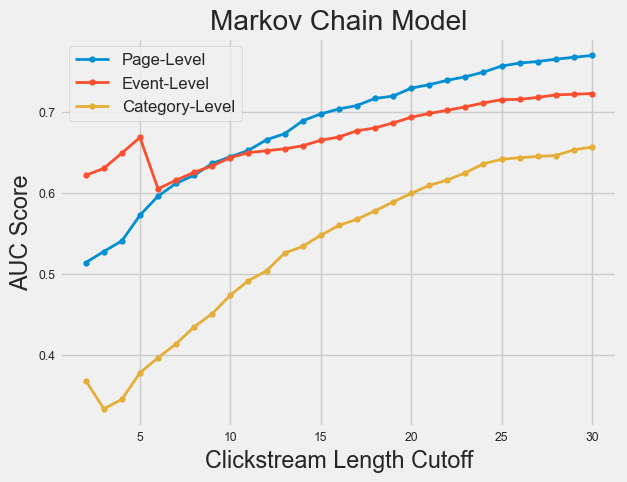

In [322]:
plt.style.use('fivethirtyeight')
plt.xlabel("Clickstream Length Cutoff")
plt.ylabel("AUC Score")
#plt.axis([-0.8, max(df_LSTM_scores.index)+0.8, 0, 1])
plt.title('Markov Chain Model')
#plt.plot(df_LSTM_scores.index, df_LSTM_scores['Precision'],label="Precision", marker='o')
#plt.plot(df_LSTM_scores.index, df_LSTM_scores['Recall'], label="Recall", marker='o')
plt.plot(range(2,31), scores_dict_page['roc_auc_score'], label="Page-Level", marker='o',linewidth=2, markersize=3.5)
plt.plot(range(2,31), scores_dict_event['roc_auc_score'], label="Event-Level", marker='o',linewidth=2, markersize=3.5)
plt.plot(range(2,31), scores_dict_cat['roc_auc_score'], label="Category-Level", marker='o',linewidth=2, markersize=3.5)
# plt.plot(df_LSTM_scores.index, training_acc, label="Training Accuracy", marker='o',linewidth=2.5)
# plt.plot(df_LSTM_scores.index, df_LSTM_scores['Accuracy'], label=" Validation Accuracy", marker='o',linewidth=2.5)


plt.legend(loc='best', prop={'size': 12})
plt.show()

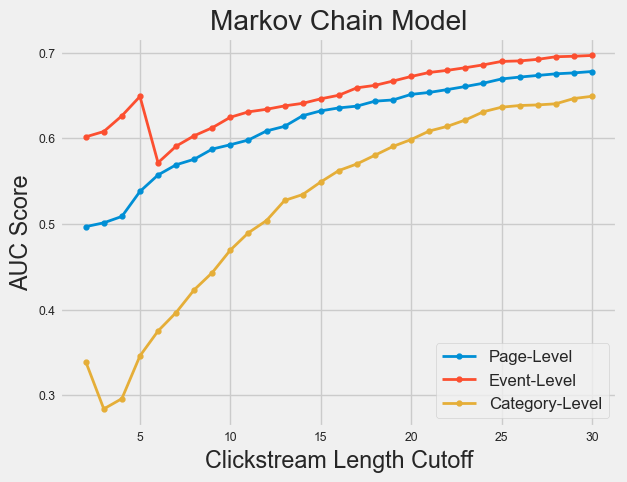

In [323]:
plt.style.use('fivethirtyeight')
plt.xlabel("Clickstream Length Cutoff")
plt.ylabel("AUC Score")
#plt.axis([-0.8, max(df_LSTM_scores.index)+0.8, 0, 1])
plt.title('Markov Chain Model')
#plt.plot(df_LSTM_scores.index, df_LSTM_scores['Precision'],label="Precision", marker='o')
#plt.plot(df_LSTM_scores.index, df_LSTM_scores['Recall'], label="Recall", marker='o')
plt.plot(range(2,31), scores_dict_page['f1_score (purchase)'], label="Page-Level", marker='o',linewidth=2, markersize=3.5)
plt.plot(range(2,31), scores_dict_event['f1_score (purchase)'], label="Event-Level", marker='o',linewidth=2, markersize=3.5)
plt.plot(range(2,31), scores_dict_cat['f1_score (purchase)'], label="Category-Level", marker='o',linewidth=2, markersize=3.5)
# plt.plot(df_LSTM_scores.index, training_acc, label="Training Accuracy", marker='o',linewidth=2.5)
# plt.plot(df_LSTM_scores.index, df_LSTM_scores['Accuracy'], label=" Validation Accuracy", marker='o',linewidth=2.5)


plt.legend(loc='best', prop={'size': 12})
plt.show()

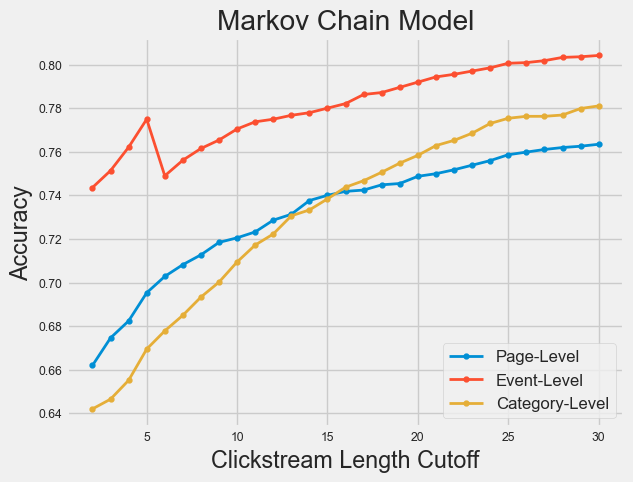

In [324]:
plt.style.use('fivethirtyeight')
plt.xlabel("Clickstream Length Cutoff")
plt.ylabel("Accuracy")
#plt.axis([-0.8, max(df_LSTM_scores.index)+0.8, 0, 1])
plt.title('Markov Chain Model')
#plt.plot(df_LSTM_scores.index, df_LSTM_scores['Precision'],label="Precision", marker='o')
#plt.plot(df_LSTM_scores.index, df_LSTM_scores['Recall'], label="Recall", marker='o')
plt.plot(range(2,31), scores_dict_page['accuracy'], label="Page-Level", marker='o',linewidth=2, markersize=3.5)
plt.plot(range(2,31), scores_dict_event['accuracy'], label="Event-Level", marker='o',linewidth=2, markersize=3.5)
plt.plot(range(2,31), scores_dict_cat['accuracy'], label="Category-Level", marker='o',linewidth=2, markersize=3.5)
# plt.plot(df_LSTM_scores.index, training_acc, label="Training Accuracy", marker='o',linewidth=2.5)
# plt.plot(df_LSTM_scores.index, df_LSTM_scores['Accuracy'], label=" Validation Accuracy", marker='o',linewidth=2.5)


plt.legend(loc='best', prop={'size': 12})
plt.show()

In [325]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [326]:
fpr1, tpr1, thresholds = roc_curve(y_test_page, y_probas_page)
fpr2, tpr2, thresholds = roc_curve(y_test_event, y_probas_event)
fpr3, tpr3, thresholds = roc_curve(y_test_cat, y_probas_cat)
# fpr4, tpr4, thresholds = roc_curve(y_test, y_proba_nb[:,1])

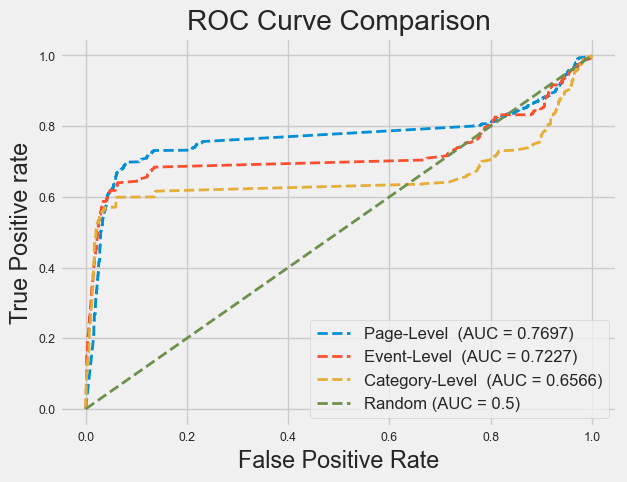

In [327]:
plt.style.use('fivethirtyeight')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', label='Page-Level  (AUC = '+str(round(roc_auc_score(y_test_page, y_probas_page),4))+')',linewidth=2)
plt.plot(fpr2, tpr2, linestyle='--', label='Event-Level  (AUC = '+str(round(roc_auc_score(y_test_event, y_probas_event),4))+')',linewidth=2)
plt.plot(fpr3, tpr3, linestyle='--', label='Category-Level  (AUC = '+str(round(roc_auc_score(y_test_cat, y_probas_cat),4))+')',linewidth=2)
# plt.plot(fpr2, tpr2, linestyle='--', label='Logistic Regression  (AUC = '+str(round(roc_auc_score(y_test, y_proba_logreg[:,1]),4))+')',linewidth=2)
# plt.plot(fpr3, tpr3, linestyle='--', label='SVM  (AUC = '+str(round(roc_auc_score(y_test, y_proba_svm),4))+')',linewidth=2)
# plt.plot(fpr4, tpr4, linestyle='--', label='Naive Bayes  (AUC = '+str(round(roc_auc_score(y_test, y_proba_nb[:,1]),4))+')',linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random (AUC = 0.5)',linewidth=2)
# title
plt.title('ROC Curve Comparison')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best', prop={'size': 12})
plt.savefig('ROC',dpi=300)
plt.show()

Feature Vectors:
- Time-based
- Num events of the same page

## LSTM

In [360]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras_preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.layers import GRU, Embedding, SimpleRNN, Activation
from tqdm import tqdm

In [361]:
def PreprocessingLSTM(df_grouped, level, purchase_terms, length, lookup):
    remove_indices = []
    for term in purchase_terms:
        remove_indices.append(lookup[term])
    
    labels = []     # list of labels
    for i in df_grouped:
        if len(set(remove_indices).intersection(set(i)))>0:
            labels.append(1)
        else:
            labels.append(0)

    def remove_purchase_event(clickstream):
        new_list = []
        for event in clickstream:
            if event not in remove_indices:
                new_list.append(event)
        return new_list
    
    df_grouped_cleaned = pd.DataFrame(df_grouped)[level].apply(remove_purchase_event).tolist()
    X,y = [],[]
    for i in range(len(df_grouped_cleaned)):
        if len(df_grouped_cleaned[i]) > 0:
            X.append(df_grouped_cleaned[i][:length])
            y.append(labels[i])
    return X, y

In [362]:
def prepare_train_test_data(x,y):
    
    X = np.array(x)
    Y = np.array(pd.get_dummies(y))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    return X_train, X_test, y_train, y_test

In [408]:
def LSTM_model(neurons=40, op=5):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), input_shape=(1, op)))
    model.add(Bidirectional(LSTM(2*neurons)))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [364]:
sess_df_page, df_grouped_page, lookup_page = sessionize_page(df_drop_dup_times, index=True)
sess_df_event, df_grouped_event, lookup_event = sessionize_event(df_drop_dup_times, index=True)
sess_df_cat, df_grouped_cat, lookup_cat = sessionize_cat(df_drop_dup_times, index=True)

In [413]:
### Training on Page-Level Clickstream Data
scores_dict_page_lstm = {'f1_score':[],'recall':[],'f1_score (purchase)':[],'accuracy':[],'roc_auc_score':[]}
for i in tqdm(range(2,31)):
    X_page, y_page = PreprocessingLSTM(df_grouped_page, 'page_index',['Checkout Confirmation'], i, lookup_page)
    X_page = pad_sequences(X_page, padding="post")
    rus = RandomUnderSampler(random_state=42,sampling_strategy=0.5)
    X_resampled, y_resampled = rus.fit_resample(X_page, y_page)
    X_train_page, X_test_page, y_train_page, y_test_page = prepare_train_test_data(X_resampled, y_resampled)
    
    with tf.device('/cpu:0'):
        tf.keras.backend.clear_session()
        lstm_model = LSTM_model(neurons=100, op=i)
        lstm_history = lstm_model.fit(X_train_page, y_train_page, epochs=20, batch_size = 32, validation_split = 0.2)
        y_preds = np.argmax(lstm_model.predict(X_test_page), axis=-1)
        y_probas_page = lstm_model.predict(X_test_page)[:,1]
        
        precision,recall,f1_score,_ = precision_recall_fscore_support(y_test_page[:,1], y_preds, average='weighted')
        f1_purchase = precision_recall_fscore_support(y_test_page[:,1], y_preds)[2][1]
        accuracy = accuracy_score(y_test_page[:,1], y_preds)
        roc_auc = roc_auc_score(y_test_page[:,1], y_probas_page, average = 'weighted')
        scores_dict_page_lstm['f1_score'].append(f1_score)
        scores_dict_page_lstm['recall'].append(recall)
        scores_dict_page_lstm['f1_score (purchase)'].append(f1_purchase)
        scores_dict_page_lstm['accuracy'].append(accuracy)
        scores_dict_page_lstm['roc_auc_score'].append(roc_auc)


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.5466 - acc: 0.7059 - val_loss: 0.4940 - val_acc: 0.7263
Epoch 2/20
194/194 [==============================] - 1s 6ms/step - loss: 0.5015 - acc: 0.7138 - val_loss: 0.4793 - val_acc: 0.7360
Epoch 3/20
194/194 [==============================] - 1s 7ms/step - loss: 0.4908 - acc: 0.7148 - val_loss: 0.4772 - val_acc: 0.6766
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4838 - acc: 0.7072 - val_loss: 0.4713 - val_acc: 0.7327
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4787 - acc: 0.7161 - val_loss: 0.4674 - val_acc: 0.7411
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4751 - acc: 0.7236 - val_loss: 0.4657 - val_acc: 0.7347
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4703 - acc: 0.7207 - val_loss: 0.4667 - val_acc: 0.7489
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


  3%|█▌                                          | 1/29 [00:29<13:50, 29.65s/it]

Epoch 1/20
194/194 [==============================] - 6s 10ms/step - loss: 0.4947 - acc: 0.7504 - val_loss: 0.4323 - val_acc: 0.7695
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4421 - acc: 0.7614 - val_loss: 0.4141 - val_acc: 0.7728
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4273 - acc: 0.7606 - val_loss: 0.4136 - val_acc: 0.7773
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4241 - acc: 0.7619 - val_loss: 0.4047 - val_acc: 0.7747
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4177 - acc: 0.7646 - val_loss: 0.4023 - val_acc: 0.7799
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4155 - acc: 0.7659 - val_loss: 0.4021 - val_acc: 0.7876
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4138 - acc: 0.7705 - val_loss: 0.3985 - val_acc: 0.7876
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0


  7%|███                                         | 2/29 [00:55<12:12, 27.13s/it]

Epoch 1/20
194/194 [==============================] - 8s 21ms/step - loss: 0.4714 - acc: 0.7792 - val_loss: 0.4021 - val_acc: 0.8108
Epoch 2/20
194/194 [==============================] - 2s 8ms/step - loss: 0.4095 - acc: 0.7987 - val_loss: 0.3851 - val_acc: 0.8083
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3998 - acc: 0.8039 - val_loss: 0.3803 - val_acc: 0.8096
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3891 - acc: 0.8097 - val_loss: 0.3771 - val_acc: 0.8167
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3874 - acc: 0.8098 - val_loss: 0.3739 - val_acc: 0.8199
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3818 - acc: 0.8149 - val_loss: 0.3723 - val_acc: 0.8238
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3827 - acc: 0.8142 - val_loss: 0.3695 - val_acc: 0.8244
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0


 10%|████▌                                       | 3/29 [01:23<12:07, 27.96s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4568 - acc: 0.8031 - val_loss: 0.3875 - val_acc: 0.8199
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3927 - acc: 0.8160 - val_loss: 0.3697 - val_acc: 0.8250
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3825 - acc: 0.8231 - val_loss: 0.3620 - val_acc: 0.8276
Epoch 4/20
194/194 [==============================] - 1s 7ms/step - loss: 0.3731 - acc: 0.8228 - val_loss: 0.3587 - val_acc: 0.8341
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3733 - acc: 0.8266 - val_loss: 0.3605 - val_acc: 0.8315
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3692 - acc: 0.8262 - val_loss: 0.3587 - val_acc: 0.8354
Epoch 7/20
194/194 [==============================] - 1s 7ms/step - loss: 0.3654 - acc: 0.8289 - val_loss: 0.3558 - val_acc: 0.8412
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 14%|██████                                      | 4/29 [01:51<11:32, 27.71s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4412 - acc: 0.8142 - val_loss: 0.3801 - val_acc: 0.8296
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3789 - acc: 0.8320 - val_loss: 0.3640 - val_acc: 0.8309
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3677 - acc: 0.8342 - val_loss: 0.3587 - val_acc: 0.8393
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3606 - acc: 0.8368 - val_loss: 0.3561 - val_acc: 0.8386
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3617 - acc: 0.8383 - val_loss: 0.3542 - val_acc: 0.8386
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3536 - acc: 0.8437 - val_loss: 0.3545 - val_acc: 0.8444
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3538 - acc: 0.8394 - val_loss: 0.3572 - val_acc: 0.8438
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 17%|███████▌                                    | 5/29 [02:16<10:42, 26.76s/it]

Epoch 1/20
194/194 [==============================] - 8s 8ms/step - loss: 0.4348 - acc: 0.8226 - val_loss: 0.3710 - val_acc: 0.8373
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3695 - acc: 0.8344 - val_loss: 0.3559 - val_acc: 0.8386
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3578 - acc: 0.8402 - val_loss: 0.3493 - val_acc: 0.8431
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3577 - acc: 0.8420 - val_loss: 0.3489 - val_acc: 0.8418
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3504 - acc: 0.8433 - val_loss: 0.3492 - val_acc: 0.8451
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3511 - acc: 0.8433 - val_loss: 0.3460 - val_acc: 0.8425
Epoch 7/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3482 - acc: 0.8475 - val_loss: 0.3459 - val_acc: 0.8483
Epoch 8/20
194/194 [==============================] - 1s 6ms/step - loss: 0.


 21%|█████████                                   | 6/29 [02:45<10:31, 27.47s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4297 - acc: 0.8178 - val_loss: 0.3735 - val_acc: 0.8341
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3629 - acc: 0.8402 - val_loss: 0.3519 - val_acc: 0.8412
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3578 - acc: 0.8415 - val_loss: 0.3466 - val_acc: 0.8476
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3498 - acc: 0.8462 - val_loss: 0.3443 - val_acc: 0.8470
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3461 - acc: 0.8455 - val_loss: 0.3454 - val_acc: 0.8405
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3416 - acc: 0.8499 - val_loss: 0.3412 - val_acc: 0.8515
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3436 - acc: 0.8475 - val_loss: 0.3414 - val_acc: 0.8464
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 24%|██████████▌                                 | 7/29 [03:12<10:05, 27.52s/it]

Epoch 1/20
194/194 [==============================] - 6s 8ms/step - loss: 0.4241 - acc: 0.8294 - val_loss: 0.3694 - val_acc: 0.8405
Epoch 2/20
194/194 [==============================] - 2s 10ms/step - loss: 0.3585 - acc: 0.8436 - val_loss: 0.3531 - val_acc: 0.8431
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3465 - acc: 0.8475 - val_loss: 0.3461 - val_acc: 0.8496
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3448 - acc: 0.8473 - val_loss: 0.3448 - val_acc: 0.8528
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3396 - acc: 0.8492 - val_loss: 0.3410 - val_acc: 0.8560
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3375 - acc: 0.8520 - val_loss: 0.3407 - val_acc: 0.8567
Epoch 7/20
194/194 [==============================] - 1s 7ms/step - loss: 0.3338 - acc: 0.8536 - val_loss: 0.3410 - val_acc: 0.8618
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0


 28%|████████████▏                               | 8/29 [03:40<09:37, 27.51s/it]

Epoch 1/20
194/194 [==============================] - 9s 8ms/step - loss: 0.4288 - acc: 0.8265 - val_loss: 0.3729 - val_acc: 0.8270
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3560 - acc: 0.8428 - val_loss: 0.3535 - val_acc: 0.8367
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3445 - acc: 0.8442 - val_loss: 0.3449 - val_acc: 0.8483
Epoch 4/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3398 - acc: 0.8475 - val_loss: 0.3406 - val_acc: 0.8515
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3360 - acc: 0.8521 - val_loss: 0.3385 - val_acc: 0.8535
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3334 - acc: 0.8529 - val_loss: 0.3392 - val_acc: 0.8483
Epoch 7/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3340 - acc: 0.8546 - val_loss: 0.3384 - val_acc: 0.8535
Epoch 8/20
194/194 [==============================] - 1s 6ms/step - loss: 0.


 31%|█████████████▋                              | 9/29 [04:10<09:27, 28.37s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4180 - acc: 0.8300 - val_loss: 0.3687 - val_acc: 0.8380
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3546 - acc: 0.8450 - val_loss: 0.3504 - val_acc: 0.8425
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3394 - acc: 0.8458 - val_loss: 0.3454 - val_acc: 0.8431
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3351 - acc: 0.8523 - val_loss: 0.3402 - val_acc: 0.8522
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3315 - acc: 0.8507 - val_loss: 0.3378 - val_acc: 0.8509
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3293 - acc: 0.8578 - val_loss: 0.3357 - val_acc: 0.8535
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3290 - acc: 0.8575 - val_loss: 0.3374 - val_acc: 0.8464
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 34%|██████████████▊                            | 10/29 [04:36<08:43, 27.53s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4220 - acc: 0.8292 - val_loss: 0.3688 - val_acc: 0.8328
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3530 - acc: 0.8425 - val_loss: 0.3495 - val_acc: 0.8367
Epoch 3/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3419 - acc: 0.8487 - val_loss: 0.3393 - val_acc: 0.8502
Epoch 4/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3330 - acc: 0.8541 - val_loss: 0.3378 - val_acc: 0.8502
Epoch 5/20
194/194 [==============================] - 2s 8ms/step - loss: 0.3297 - acc: 0.8539 - val_loss: 0.3365 - val_acc: 0.8476
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3280 - acc: 0.8546 - val_loss: 0.3413 - val_acc: 0.8522
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3245 - acc: 0.8583 - val_loss: 0.3376 - val_acc: 0.8541
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 38%|████████████████▎                          | 11/29 [05:04<08:17, 27.66s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4202 - acc: 0.8313 - val_loss: 0.3691 - val_acc: 0.8373
Epoch 2/20
194/194 [==============================] - 1s 7ms/step - loss: 0.3491 - acc: 0.8444 - val_loss: 0.3452 - val_acc: 0.8457
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3385 - acc: 0.8467 - val_loss: 0.3388 - val_acc: 0.8489
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3330 - acc: 0.8497 - val_loss: 0.3343 - val_acc: 0.8476
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3299 - acc: 0.8544 - val_loss: 0.3369 - val_acc: 0.8489
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3283 - acc: 0.8529 - val_loss: 0.3347 - val_acc: 0.8509
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3254 - acc: 0.8534 - val_loss: 0.3359 - val_acc: 0.8502
Epoch 8/20
194/194 [==============================] - 1s 6ms/step - loss: 0.


 41%|█████████████████▊                         | 12/29 [05:34<08:01, 28.32s/it]

Epoch 1/20
194/194 [==============================] - 5s 10ms/step - loss: 0.4189 - acc: 0.8324 - val_loss: 0.3669 - val_acc: 0.8373
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3498 - acc: 0.8452 - val_loss: 0.3443 - val_acc: 0.8431
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3377 - acc: 0.8465 - val_loss: 0.3360 - val_acc: 0.8496
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3324 - acc: 0.8533 - val_loss: 0.3370 - val_acc: 0.8489
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3315 - acc: 0.8544 - val_loss: 0.3360 - val_acc: 0.8509
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3288 - acc: 0.8567 - val_loss: 0.3305 - val_acc: 0.8522
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3240 - acc: 0.8571 - val_loss: 0.3316 - val_acc: 0.8489
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0


 45%|███████████████████▎                       | 13/29 [05:59<07:21, 27.60s/it]

Epoch 1/20
194/194 [==============================] - 6s 8ms/step - loss: 0.4189 - acc: 0.8336 - val_loss: 0.3619 - val_acc: 0.8405
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3506 - acc: 0.8425 - val_loss: 0.3428 - val_acc: 0.8560
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3352 - acc: 0.8507 - val_loss: 0.3339 - val_acc: 0.8457
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3316 - acc: 0.8584 - val_loss: 0.3342 - val_acc: 0.8509
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3272 - acc: 0.8555 - val_loss: 0.3309 - val_acc: 0.8509
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3265 - acc: 0.8584 - val_loss: 0.3311 - val_acc: 0.8496
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3233 - acc: 0.8573 - val_loss: 0.3286 - val_acc: 0.8560
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 48%|████████████████████▊                      | 14/29 [06:26<06:46, 27.13s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4172 - acc: 0.8310 - val_loss: 0.3656 - val_acc: 0.8438
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3485 - acc: 0.8447 - val_loss: 0.3409 - val_acc: 0.8522
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3350 - acc: 0.8533 - val_loss: 0.3348 - val_acc: 0.8547
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3320 - acc: 0.8538 - val_loss: 0.3333 - val_acc: 0.8509
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3257 - acc: 0.8562 - val_loss: 0.3301 - val_acc: 0.8509
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3248 - acc: 0.8531 - val_loss: 0.3278 - val_acc: 0.8547
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3147 - acc: 0.8620 - val_loss: 0.3309 - val_acc: 0.8444
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 52%|██████████████████████▏                    | 15/29 [06:53<06:22, 27.36s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4200 - acc: 0.8268 - val_loss: 0.3641 - val_acc: 0.8425
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3480 - acc: 0.8426 - val_loss: 0.3466 - val_acc: 0.8464
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3346 - acc: 0.8500 - val_loss: 0.3352 - val_acc: 0.8483
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3316 - acc: 0.8499 - val_loss: 0.3353 - val_acc: 0.8535
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3280 - acc: 0.8500 - val_loss: 0.3349 - val_acc: 0.8399
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3232 - acc: 0.8576 - val_loss: 0.3286 - val_acc: 0.8541
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3212 - acc: 0.8536 - val_loss: 0.3291 - val_acc: 0.8528
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 55%|███████████████████████▋                   | 16/29 [07:17<05:41, 26.27s/it]

Epoch 1/20
194/194 [==============================] - 8s 8ms/step - loss: 0.4172 - acc: 0.8320 - val_loss: 0.3665 - val_acc: 0.8367
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3502 - acc: 0.8483 - val_loss: 0.3474 - val_acc: 0.8418
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3338 - acc: 0.8497 - val_loss: 0.3408 - val_acc: 0.8476
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3271 - acc: 0.8554 - val_loss: 0.3309 - val_acc: 0.8541
Epoch 5/20
194/194 [==============================] - 1s 7ms/step - loss: 0.3274 - acc: 0.8536 - val_loss: 0.3300 - val_acc: 0.8502
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3218 - acc: 0.8560 - val_loss: 0.3337 - val_acc: 0.8567
Epoch 7/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3195 - acc: 0.8609 - val_loss: 0.3276 - val_acc: 0.8444
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 59%|█████████████████████████▏                 | 17/29 [07:45<05:22, 26.88s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4137 - acc: 0.8316 - val_loss: 0.3725 - val_acc: 0.8347
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3480 - acc: 0.8442 - val_loss: 0.3478 - val_acc: 0.8386
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3351 - acc: 0.8486 - val_loss: 0.3360 - val_acc: 0.8528
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3313 - acc: 0.8542 - val_loss: 0.3302 - val_acc: 0.8522
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3270 - acc: 0.8541 - val_loss: 0.3302 - val_acc: 0.8470
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3212 - acc: 0.8609 - val_loss: 0.3295 - val_acc: 0.8496
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3211 - acc: 0.8576 - val_loss: 0.3311 - val_acc: 0.8431
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 62%|██████████████████████████▋                | 18/29 [08:11<04:51, 26.49s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4155 - acc: 0.8345 - val_loss: 0.3636 - val_acc: 0.8341
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3465 - acc: 0.8487 - val_loss: 0.3437 - val_acc: 0.8438
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3319 - acc: 0.8502 - val_loss: 0.3406 - val_acc: 0.8528
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3251 - acc: 0.8552 - val_loss: 0.3297 - val_acc: 0.8444
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3235 - acc: 0.8546 - val_loss: 0.3310 - val_acc: 0.8554
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3234 - acc: 0.8579 - val_loss: 0.3323 - val_acc: 0.8515
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3158 - acc: 0.8617 - val_loss: 0.3297 - val_acc: 0.8528
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 66%|████████████████████████████▏              | 19/29 [08:36<04:20, 26.09s/it]

Epoch 1/20
194/194 [==============================] - 7s 7ms/step - loss: 0.4196 - acc: 0.8355 - val_loss: 0.3623 - val_acc: 0.8399
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3464 - acc: 0.8471 - val_loss: 0.3448 - val_acc: 0.8444
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3335 - acc: 0.8510 - val_loss: 0.3362 - val_acc: 0.8393
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3302 - acc: 0.8529 - val_loss: 0.3338 - val_acc: 0.8476
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3253 - acc: 0.8557 - val_loss: 0.3301 - val_acc: 0.8509
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3232 - acc: 0.8562 - val_loss: 0.3279 - val_acc: 0.8489
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3192 - acc: 0.8605 - val_loss: 0.3272 - val_acc: 0.8496
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 69%|█████████████████████████████▋             | 20/29 [09:05<04:01, 26.83s/it]

Epoch 1/20
194/194 [==============================] - 6s 8ms/step - loss: 0.4202 - acc: 0.8266 - val_loss: 0.3632 - val_acc: 0.8302
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3501 - acc: 0.8420 - val_loss: 0.3421 - val_acc: 0.8418
Epoch 3/20
194/194 [==============================] - 1s 7ms/step - loss: 0.3356 - acc: 0.8520 - val_loss: 0.3347 - val_acc: 0.8541
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3272 - acc: 0.8552 - val_loss: 0.3313 - val_acc: 0.8470
Epoch 5/20
194/194 [==============================] - 1s 7ms/step - loss: 0.3247 - acc: 0.8546 - val_loss: 0.3316 - val_acc: 0.8476
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3200 - acc: 0.8610 - val_loss: 0.3262 - val_acc: 0.8509
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3197 - acc: 0.8612 - val_loss: 0.3306 - val_acc: 0.8476
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 72%|███████████████████████████████▏           | 21/29 [09:31<03:34, 26.81s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4126 - acc: 0.8347 - val_loss: 0.3623 - val_acc: 0.8373
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3456 - acc: 0.8444 - val_loss: 0.3434 - val_acc: 0.8425
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3332 - acc: 0.8483 - val_loss: 0.3387 - val_acc: 0.8535
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3262 - acc: 0.8559 - val_loss: 0.3388 - val_acc: 0.8418
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3234 - acc: 0.8555 - val_loss: 0.3319 - val_acc: 0.8470
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3198 - acc: 0.8560 - val_loss: 0.3289 - val_acc: 0.8502
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3192 - acc: 0.8604 - val_loss: 0.3280 - val_acc: 0.8515
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 76%|████████████████████████████████▌          | 22/29 [09:56<03:02, 26.03s/it]

Epoch 1/20
194/194 [==============================] - 8s 7ms/step - loss: 0.4157 - acc: 0.8329 - val_loss: 0.3635 - val_acc: 0.8321
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3421 - acc: 0.8452 - val_loss: 0.3409 - val_acc: 0.8347
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3293 - acc: 0.8499 - val_loss: 0.3363 - val_acc: 0.8464
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3267 - acc: 0.8526 - val_loss: 0.3322 - val_acc: 0.8470
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3179 - acc: 0.8571 - val_loss: 0.3335 - val_acc: 0.8451
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3172 - acc: 0.8550 - val_loss: 0.3282 - val_acc: 0.8502
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3189 - acc: 0.8589 - val_loss: 0.3322 - val_acc: 0.8547
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 79%|██████████████████████████████████         | 23/29 [10:23<02:37, 26.33s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4176 - acc: 0.8376 - val_loss: 0.3663 - val_acc: 0.8386
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3477 - acc: 0.8437 - val_loss: 0.3449 - val_acc: 0.8476
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3335 - acc: 0.8484 - val_loss: 0.3381 - val_acc: 0.8393
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3271 - acc: 0.8525 - val_loss: 0.3357 - val_acc: 0.8367
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3238 - acc: 0.8528 - val_loss: 0.3348 - val_acc: 0.8399
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3224 - acc: 0.8547 - val_loss: 0.3313 - val_acc: 0.8535
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3159 - acc: 0.8594 - val_loss: 0.3304 - val_acc: 0.8580
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 83%|███████████████████████████████████▌       | 24/29 [10:47<02:08, 25.73s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4194 - acc: 0.8297 - val_loss: 0.3625 - val_acc: 0.8380
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3474 - acc: 0.8426 - val_loss: 0.3449 - val_acc: 0.8425
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3311 - acc: 0.8526 - val_loss: 0.3367 - val_acc: 0.8535
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3243 - acc: 0.8567 - val_loss: 0.3333 - val_acc: 0.8464
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3208 - acc: 0.8579 - val_loss: 0.3394 - val_acc: 0.8399
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3196 - acc: 0.8562 - val_loss: 0.3301 - val_acc: 0.8457
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3160 - acc: 0.8576 - val_loss: 0.3295 - val_acc: 0.8528
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 86%|█████████████████████████████████████      | 25/29 [11:11<01:41, 25.27s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4154 - acc: 0.8307 - val_loss: 0.3672 - val_acc: 0.8347
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3503 - acc: 0.8444 - val_loss: 0.3475 - val_acc: 0.8393
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3359 - acc: 0.8467 - val_loss: 0.3339 - val_acc: 0.8522
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3222 - acc: 0.8562 - val_loss: 0.3299 - val_acc: 0.8509
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3220 - acc: 0.8588 - val_loss: 0.3307 - val_acc: 0.8464
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3197 - acc: 0.8538 - val_loss: 0.3250 - val_acc: 0.8496
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3129 - acc: 0.8626 - val_loss: 0.3258 - val_acc: 0.8476
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 90%|██████████████████████████████████████▌    | 26/29 [11:39<01:18, 26.05s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4195 - acc: 0.8263 - val_loss: 0.3605 - val_acc: 0.8321
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3447 - acc: 0.8478 - val_loss: 0.3404 - val_acc: 0.8470
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3301 - acc: 0.8517 - val_loss: 0.3378 - val_acc: 0.8522
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3252 - acc: 0.8555 - val_loss: 0.3328 - val_acc: 0.8515
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3260 - acc: 0.8542 - val_loss: 0.3316 - val_acc: 0.8483
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3200 - acc: 0.8571 - val_loss: 0.3305 - val_acc: 0.8489
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3162 - acc: 0.8581 - val_loss: 0.3316 - val_acc: 0.8541
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 93%|████████████████████████████████████████   | 27/29 [12:04<00:51, 25.67s/it]

Epoch 1/20
194/194 [==============================] - 5s 10ms/step - loss: 0.4155 - acc: 0.8318 - val_loss: 0.3628 - val_acc: 0.8393
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3453 - acc: 0.8425 - val_loss: 0.3468 - val_acc: 0.8541
Epoch 3/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3304 - acc: 0.8517 - val_loss: 0.3324 - val_acc: 0.8586
Epoch 4/20
194/194 [==============================] - 1s 7ms/step - loss: 0.3278 - acc: 0.8560 - val_loss: 0.3324 - val_acc: 0.8547
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3216 - acc: 0.8583 - val_loss: 0.3299 - val_acc: 0.8528
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3155 - acc: 0.8596 - val_loss: 0.3290 - val_acc: 0.8528
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3147 - acc: 0.8589 - val_loss: 0.3303 - val_acc: 0.8509
Epoch 8/20
194/194 [==============================] - 1s 6ms/step - loss: 0


 97%|█████████████████████████████████████████▌ | 28/29 [12:31<00:25, 26.00s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4194 - acc: 0.8305 - val_loss: 0.3620 - val_acc: 0.8367
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3456 - acc: 0.8442 - val_loss: 0.3401 - val_acc: 0.8386
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3344 - acc: 0.8484 - val_loss: 0.3327 - val_acc: 0.8535
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3268 - acc: 0.8512 - val_loss: 0.3317 - val_acc: 0.8522
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3207 - acc: 0.8562 - val_loss: 0.3342 - val_acc: 0.8438
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3206 - acc: 0.8568 - val_loss: 0.3334 - val_acc: 0.8535
Epoch 7/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3171 - acc: 0.8589 - val_loss: 0.3323 - val_acc: 0.8496
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.

100%|███████████████████████████████████████████| 29/29 [13:00<00:00, 26.91s/it]


In [417]:
### Training on Event-Level Clickstream Data
scores_dict_event_lstm = {'f1_score':[],'recall':[],'f1_score (purchase)':[],'accuracy':[],'roc_auc_score':[]}
for i in tqdm(range(2,31)):
    X_event, y_event = PreprocessingLSTM(df_grouped_event, 'event_name_index',['purchase','exit'], i, lookup_event)
    X_event = pad_sequences(X_event, padding="post")
    rus = RandomUnderSampler(random_state=42,sampling_strategy=0.5)
    X_resampled, y_resampled = rus.fit_resample(X_event, y_event)
    X_train_event, X_test_event, y_train_event, y_test_event = prepare_train_test_data(X_resampled, y_resampled)
    
    with tf.device('/cpu:0'):
        tf.keras.backend.clear_session()
        lstm_model = LSTM_model(neurons=100, op=i)
        lstm_history = lstm_model.fit(X_train_event, y_train_event, epochs=20, batch_size = 32, validation_split = 0.2)
        y_preds = np.argmax(lstm_model.predict(X_test_event), axis=-1)
        y_probas_event = lstm_model.predict(X_test_event)[:,1]
        
        precision,recall,f1_score,_ = precision_recall_fscore_support(y_test_event[:,1], y_preds, average='weighted')
        f1_purchase = precision_recall_fscore_support(y_test_event[:,1], y_preds)[2][1]
        accuracy = accuracy_score(y_test_event[:,1], y_preds)
        roc_auc = roc_auc_score(y_test_event[:,1], y_probas_event, average = 'weighted')
        scores_dict_event_lstm['f1_score'].append(f1_score)
        scores_dict_event_lstm['recall'].append(recall)
        scores_dict_event_lstm['f1_score (purchase)'].append(f1_purchase)
        scores_dict_event_lstm['accuracy'].append(accuracy)
        scores_dict_event_lstm['roc_auc_score'].append(roc_auc)


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.5643 - acc: 0.6985 - val_loss: 0.5044 - val_acc: 0.7211
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4937 - acc: 0.7274 - val_loss: 0.4887 - val_acc: 0.7314
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4793 - acc: 0.7287 - val_loss: 0.4821 - val_acc: 0.7314
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4775 - acc: 0.7280 - val_loss: 0.4820 - val_acc: 0.7314
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4715 - acc: 0.7367 - val_loss: 0.4815 - val_acc: 0.7301
Epoch 6/20
194/194 [==============================] - 1s 7ms/step - loss: 0.4712 - acc: 0.7311 - val_loss: 0.4820 - val_acc: 0.7295
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4697 - acc: 0.7364 - val_loss: 0.4803 - val_acc: 0.7301
Epoch 8/20
194/194 [==============================] - 1s 7ms/step - loss: 0.


  3%|█▌                                          | 1/29 [00:25<11:54, 25.52s/it]

Epoch 1/20
194/194 [==============================] - 8s 22ms/step - loss: 0.5061 - acc: 0.7676 - val_loss: 0.4646 - val_acc: 0.7657
Epoch 2/20
194/194 [==============================] - 1s 6ms/step - loss: 0.4264 - acc: 0.7927 - val_loss: 0.4412 - val_acc: 0.7734
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4183 - acc: 0.7977 - val_loss: 0.4389 - val_acc: 0.7708
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4103 - acc: 0.7929 - val_loss: 0.4311 - val_acc: 0.7695
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4087 - acc: 0.7948 - val_loss: 0.4294 - val_acc: 0.7708
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4071 - acc: 0.7963 - val_loss: 0.4271 - val_acc: 0.7689
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4051 - acc: 0.7931 - val_loss: 0.4290 - val_acc: 0.7689
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0


  7%|███                                         | 2/29 [00:52<11:59, 26.66s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4798 - acc: 0.7968 - val_loss: 0.4356 - val_acc: 0.8102
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4008 - acc: 0.8247 - val_loss: 0.4174 - val_acc: 0.8147
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3941 - acc: 0.8229 - val_loss: 0.4125 - val_acc: 0.8108
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3842 - acc: 0.8245 - val_loss: 0.4054 - val_acc: 0.8115
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3810 - acc: 0.8237 - val_loss: 0.3978 - val_acc: 0.8128
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3803 - acc: 0.8232 - val_loss: 0.3975 - val_acc: 0.8096
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3789 - acc: 0.8213 - val_loss: 0.3982 - val_acc: 0.8018
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 10%|████▌                                       | 3/29 [01:16<10:58, 25.32s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4700 - acc: 0.8216 - val_loss: 0.4266 - val_acc: 0.8128
Epoch 2/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3915 - acc: 0.8339 - val_loss: 0.4058 - val_acc: 0.8128
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3813 - acc: 0.8363 - val_loss: 0.3919 - val_acc: 0.8199
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3713 - acc: 0.8374 - val_loss: 0.3896 - val_acc: 0.8212
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3690 - acc: 0.8355 - val_loss: 0.3850 - val_acc: 0.8250
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3653 - acc: 0.8387 - val_loss: 0.3816 - val_acc: 0.8225
Epoch 7/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3637 - acc: 0.8376 - val_loss: 0.3798 - val_acc: 0.8231
Epoch 8/20
194/194 [==============================] - 1s 6ms/step - loss: 0.


 14%|██████                                      | 4/29 [01:43<10:44, 25.79s/it]

Epoch 1/20
194/194 [==============================] - 8s 9ms/step - loss: 0.4627 - acc: 0.8291 - val_loss: 0.4245 - val_acc: 0.8238
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3808 - acc: 0.8416 - val_loss: 0.4067 - val_acc: 0.8270
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3720 - acc: 0.8407 - val_loss: 0.3944 - val_acc: 0.8263
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3626 - acc: 0.8408 - val_loss: 0.3969 - val_acc: 0.8212
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3601 - acc: 0.8412 - val_loss: 0.3928 - val_acc: 0.8238
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3570 - acc: 0.8407 - val_loss: 0.3842 - val_acc: 0.8212
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3550 - acc: 0.8407 - val_loss: 0.3853 - val_acc: 0.8257
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 17%|███████▌                                    | 5/29 [02:11<10:40, 26.68s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4506 - acc: 0.8410 - val_loss: 0.4193 - val_acc: 0.8238
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3732 - acc: 0.8420 - val_loss: 0.4121 - val_acc: 0.8263
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3659 - acc: 0.8425 - val_loss: 0.3956 - val_acc: 0.8250
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3611 - acc: 0.8420 - val_loss: 0.3957 - val_acc: 0.8270
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3535 - acc: 0.8457 - val_loss: 0.3887 - val_acc: 0.8257
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3547 - acc: 0.8436 - val_loss: 0.3883 - val_acc: 0.8212
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3514 - acc: 0.8421 - val_loss: 0.3868 - val_acc: 0.8212
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 21%|█████████                                   | 6/29 [02:36<09:58, 26.03s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4459 - acc: 0.8379 - val_loss: 0.4232 - val_acc: 0.8225
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3729 - acc: 0.8428 - val_loss: 0.4031 - val_acc: 0.8257
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3623 - acc: 0.8436 - val_loss: 0.3963 - val_acc: 0.8250
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3546 - acc: 0.8439 - val_loss: 0.3943 - val_acc: 0.8212
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3518 - acc: 0.8434 - val_loss: 0.3865 - val_acc: 0.8238
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3491 - acc: 0.8434 - val_loss: 0.3844 - val_acc: 0.8205
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3477 - acc: 0.8450 - val_loss: 0.3776 - val_acc: 0.8205
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 24%|██████████▌                                 | 7/29 [03:01<09:24, 25.64s/it]

Epoch 1/20
194/194 [==============================] - 7s 7ms/step - loss: 0.4429 - acc: 0.8379 - val_loss: 0.4245 - val_acc: 0.8244
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3734 - acc: 0.8418 - val_loss: 0.4033 - val_acc: 0.8218
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3623 - acc: 0.8437 - val_loss: 0.4008 - val_acc: 0.8250
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3542 - acc: 0.8468 - val_loss: 0.3924 - val_acc: 0.8238
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3513 - acc: 0.8458 - val_loss: 0.3813 - val_acc: 0.8263
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3485 - acc: 0.8460 - val_loss: 0.3866 - val_acc: 0.8225
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3466 - acc: 0.8437 - val_loss: 0.3854 - val_acc: 0.8231
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 28%|████████████▏                               | 8/29 [03:27<09:06, 26.02s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4546 - acc: 0.8297 - val_loss: 0.4179 - val_acc: 0.8212
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3711 - acc: 0.8434 - val_loss: 0.4051 - val_acc: 0.8257
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3556 - acc: 0.8449 - val_loss: 0.3920 - val_acc: 0.8244
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3511 - acc: 0.8442 - val_loss: 0.3883 - val_acc: 0.8276
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3480 - acc: 0.8457 - val_loss: 0.3836 - val_acc: 0.8270
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3438 - acc: 0.8471 - val_loss: 0.3876 - val_acc: 0.8283
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3423 - acc: 0.8499 - val_loss: 0.3774 - val_acc: 0.8238
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 31%|█████████████▋                              | 9/29 [03:52<08:29, 25.50s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4426 - acc: 0.8412 - val_loss: 0.4237 - val_acc: 0.8244
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3652 - acc: 0.8454 - val_loss: 0.3988 - val_acc: 0.8296
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3577 - acc: 0.8452 - val_loss: 0.3876 - val_acc: 0.8302
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3498 - acc: 0.8442 - val_loss: 0.3871 - val_acc: 0.8302
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3467 - acc: 0.8478 - val_loss: 0.3874 - val_acc: 0.8263
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3440 - acc: 0.8479 - val_loss: 0.3874 - val_acc: 0.8244
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3405 - acc: 0.8483 - val_loss: 0.3763 - val_acc: 0.8250
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 34%|██████████████▊                            | 10/29 [04:16<07:56, 25.09s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4486 - acc: 0.8410 - val_loss: 0.4155 - val_acc: 0.8238
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3653 - acc: 0.8463 - val_loss: 0.4054 - val_acc: 0.8289
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3547 - acc: 0.8463 - val_loss: 0.3863 - val_acc: 0.8270
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3490 - acc: 0.8467 - val_loss: 0.3799 - val_acc: 0.8283
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3437 - acc: 0.8507 - val_loss: 0.3754 - val_acc: 0.8289
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3421 - acc: 0.8487 - val_loss: 0.3805 - val_acc: 0.8296
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3407 - acc: 0.8462 - val_loss: 0.3845 - val_acc: 0.8309
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 38%|████████████████▎                          | 11/29 [04:42<07:39, 25.52s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4398 - acc: 0.8371 - val_loss: 0.4144 - val_acc: 0.8212
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3637 - acc: 0.8400 - val_loss: 0.3924 - val_acc: 0.8321
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3505 - acc: 0.8462 - val_loss: 0.3883 - val_acc: 0.8244
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3481 - acc: 0.8450 - val_loss: 0.3854 - val_acc: 0.8309
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3409 - acc: 0.8521 - val_loss: 0.3723 - val_acc: 0.8354
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3396 - acc: 0.8508 - val_loss: 0.3756 - val_acc: 0.8257
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3379 - acc: 0.8497 - val_loss: 0.3849 - val_acc: 0.8250
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 41%|█████████████████▊                         | 12/29 [05:06<07:01, 24.79s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4376 - acc: 0.8391 - val_loss: 0.4175 - val_acc: 0.8250
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3656 - acc: 0.8436 - val_loss: 0.3911 - val_acc: 0.8199
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3523 - acc: 0.8460 - val_loss: 0.3946 - val_acc: 0.8225
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3472 - acc: 0.8452 - val_loss: 0.3772 - val_acc: 0.8244
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3418 - acc: 0.8496 - val_loss: 0.3737 - val_acc: 0.8276
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3368 - acc: 0.8517 - val_loss: 0.3753 - val_acc: 0.8302
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3360 - acc: 0.8492 - val_loss: 0.3763 - val_acc: 0.8270
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 45%|███████████████████▎                       | 13/29 [05:29<06:28, 24.31s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4400 - acc: 0.8379 - val_loss: 0.4086 - val_acc: 0.8199
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3605 - acc: 0.8420 - val_loss: 0.3877 - val_acc: 0.8270
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3486 - acc: 0.8494 - val_loss: 0.3755 - val_acc: 0.8315
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3434 - acc: 0.8468 - val_loss: 0.3791 - val_acc: 0.8283
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3418 - acc: 0.8487 - val_loss: 0.3769 - val_acc: 0.8276
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3378 - acc: 0.8526 - val_loss: 0.3698 - val_acc: 0.8263
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3339 - acc: 0.8513 - val_loss: 0.3732 - val_acc: 0.8283
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 48%|████████████████████▊                      | 14/29 [05:55<06:14, 24.95s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4366 - acc: 0.8362 - val_loss: 0.4109 - val_acc: 0.8167
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3641 - acc: 0.8428 - val_loss: 0.3934 - val_acc: 0.8283
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3496 - acc: 0.8467 - val_loss: 0.3850 - val_acc: 0.8296
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3451 - acc: 0.8462 - val_loss: 0.3835 - val_acc: 0.8283
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3408 - acc: 0.8479 - val_loss: 0.3787 - val_acc: 0.8257
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3362 - acc: 0.8525 - val_loss: 0.3711 - val_acc: 0.8283
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3355 - acc: 0.8523 - val_loss: 0.3676 - val_acc: 0.8309
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 52%|██████████████████████▏                    | 15/29 [06:19<05:42, 24.46s/it]

Epoch 1/20
194/194 [==============================] - 8s 8ms/step - loss: 0.4487 - acc: 0.8374 - val_loss: 0.4116 - val_acc: 0.8205
Epoch 2/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3615 - acc: 0.8458 - val_loss: 0.3908 - val_acc: 0.8244
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3513 - acc: 0.8460 - val_loss: 0.3820 - val_acc: 0.8309
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3446 - acc: 0.8481 - val_loss: 0.3788 - val_acc: 0.8250
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3385 - acc: 0.8515 - val_loss: 0.3697 - val_acc: 0.8263
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3374 - acc: 0.8508 - val_loss: 0.3729 - val_acc: 0.8257
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3367 - acc: 0.8497 - val_loss: 0.3743 - val_acc: 0.8276
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 55%|███████████████████████▋                   | 16/29 [06:47<05:31, 25.52s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4442 - acc: 0.8379 - val_loss: 0.4126 - val_acc: 0.8218
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3596 - acc: 0.8421 - val_loss: 0.3941 - val_acc: 0.8270
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3508 - acc: 0.8458 - val_loss: 0.3789 - val_acc: 0.8276
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3428 - acc: 0.8446 - val_loss: 0.3771 - val_acc: 0.8309
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3397 - acc: 0.8504 - val_loss: 0.3757 - val_acc: 0.8276
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3372 - acc: 0.8460 - val_loss: 0.3718 - val_acc: 0.8309
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3352 - acc: 0.8505 - val_loss: 0.3764 - val_acc: 0.8321
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 59%|█████████████████████████▏                 | 17/29 [07:11<05:03, 25.27s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4372 - acc: 0.8357 - val_loss: 0.4156 - val_acc: 0.8225
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3619 - acc: 0.8426 - val_loss: 0.3943 - val_acc: 0.8238
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3490 - acc: 0.8479 - val_loss: 0.3852 - val_acc: 0.8225
Epoch 4/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3455 - acc: 0.8487 - val_loss: 0.3806 - val_acc: 0.8238
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3406 - acc: 0.8475 - val_loss: 0.3704 - val_acc: 0.8244
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3354 - acc: 0.8525 - val_loss: 0.3712 - val_acc: 0.8276
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3361 - acc: 0.8502 - val_loss: 0.3770 - val_acc: 0.8315
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 62%|██████████████████████████▋                | 18/29 [07:35<04:33, 24.85s/it]

Epoch 1/20
194/194 [==============================] - 8s 8ms/step - loss: 0.4429 - acc: 0.8397 - val_loss: 0.4146 - val_acc: 0.8186
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3654 - acc: 0.8420 - val_loss: 0.3915 - val_acc: 0.8296
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3494 - acc: 0.8494 - val_loss: 0.3878 - val_acc: 0.8309
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3439 - acc: 0.8497 - val_loss: 0.3835 - val_acc: 0.8238
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3386 - acc: 0.8513 - val_loss: 0.3764 - val_acc: 0.8334
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3378 - acc: 0.8475 - val_loss: 0.3809 - val_acc: 0.8321
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3356 - acc: 0.8478 - val_loss: 0.3740 - val_acc: 0.8315
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 66%|████████████████████████████▏              | 19/29 [08:02<04:16, 25.62s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4432 - acc: 0.8349 - val_loss: 0.4103 - val_acc: 0.8160
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3633 - acc: 0.8452 - val_loss: 0.4004 - val_acc: 0.8225
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3460 - acc: 0.8470 - val_loss: 0.3879 - val_acc: 0.8263
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3416 - acc: 0.8491 - val_loss: 0.3917 - val_acc: 0.8244
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3375 - acc: 0.8475 - val_loss: 0.3727 - val_acc: 0.8302
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3358 - acc: 0.8473 - val_loss: 0.3697 - val_acc: 0.8263
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3319 - acc: 0.8510 - val_loss: 0.3709 - val_acc: 0.8270
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 69%|█████████████████████████████▋             | 20/29 [08:27<03:47, 25.31s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4438 - acc: 0.8350 - val_loss: 0.4148 - val_acc: 0.8218
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3619 - acc: 0.8421 - val_loss: 0.3947 - val_acc: 0.8270
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3470 - acc: 0.8468 - val_loss: 0.3838 - val_acc: 0.8218
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3432 - acc: 0.8468 - val_loss: 0.3742 - val_acc: 0.8315
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3385 - acc: 0.8507 - val_loss: 0.3687 - val_acc: 0.8276
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3365 - acc: 0.8491 - val_loss: 0.3653 - val_acc: 0.8302
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3332 - acc: 0.8500 - val_loss: 0.3764 - val_acc: 0.8315
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 72%|███████████████████████████████▏           | 21/29 [08:52<03:20, 25.11s/it]

Epoch 1/20
194/194 [==============================] - 8s 7ms/step - loss: 0.4350 - acc: 0.8412 - val_loss: 0.4188 - val_acc: 0.8238
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3640 - acc: 0.8450 - val_loss: 0.4016 - val_acc: 0.8250
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3481 - acc: 0.8441 - val_loss: 0.4004 - val_acc: 0.8296
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3414 - acc: 0.8481 - val_loss: 0.3750 - val_acc: 0.8341
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3403 - acc: 0.8486 - val_loss: 0.3736 - val_acc: 0.8283
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3338 - acc: 0.8517 - val_loss: 0.3716 - val_acc: 0.8341
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3326 - acc: 0.8496 - val_loss: 0.3676 - val_acc: 0.8328
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 76%|████████████████████████████████▌          | 22/29 [09:19<02:59, 25.69s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4328 - acc: 0.8407 - val_loss: 0.4069 - val_acc: 0.8238
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3588 - acc: 0.8444 - val_loss: 0.3887 - val_acc: 0.8244
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3499 - acc: 0.8470 - val_loss: 0.3819 - val_acc: 0.8289
Epoch 4/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3414 - acc: 0.8491 - val_loss: 0.3829 - val_acc: 0.8263
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3394 - acc: 0.8525 - val_loss: 0.3725 - val_acc: 0.8328
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3369 - acc: 0.8515 - val_loss: 0.3727 - val_acc: 0.8341
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3345 - acc: 0.8491 - val_loss: 0.3670 - val_acc: 0.8328
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 79%|██████████████████████████████████         | 23/29 [09:43<02:32, 25.38s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4437 - acc: 0.8374 - val_loss: 0.4096 - val_acc: 0.8250
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3634 - acc: 0.8425 - val_loss: 0.3961 - val_acc: 0.8289
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3470 - acc: 0.8467 - val_loss: 0.3851 - val_acc: 0.8296
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3438 - acc: 0.8471 - val_loss: 0.3900 - val_acc: 0.8238
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3398 - acc: 0.8491 - val_loss: 0.3717 - val_acc: 0.8263
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3364 - acc: 0.8491 - val_loss: 0.3786 - val_acc: 0.8270
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3344 - acc: 0.8492 - val_loss: 0.3708 - val_acc: 0.8270
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 83%|███████████████████████████████████▌       | 24/29 [10:08<02:05, 25.12s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4414 - acc: 0.8404 - val_loss: 0.4135 - val_acc: 0.8238
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3609 - acc: 0.8436 - val_loss: 0.3938 - val_acc: 0.8283
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3509 - acc: 0.8458 - val_loss: 0.3807 - val_acc: 0.8289
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3421 - acc: 0.8496 - val_loss: 0.3844 - val_acc: 0.8257
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3371 - acc: 0.8518 - val_loss: 0.3779 - val_acc: 0.8321
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3349 - acc: 0.8512 - val_loss: 0.3881 - val_acc: 0.8283
Epoch 7/20
194/194 [==============================] - 1s 7ms/step - loss: 0.3351 - acc: 0.8497 - val_loss: 0.3702 - val_acc: 0.8328
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 86%|█████████████████████████████████████      | 25/29 [10:36<01:43, 25.85s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4380 - acc: 0.8350 - val_loss: 0.4161 - val_acc: 0.8212
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3614 - acc: 0.8437 - val_loss: 0.4014 - val_acc: 0.8186
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3469 - acc: 0.8468 - val_loss: 0.3799 - val_acc: 0.8302
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3447 - acc: 0.8442 - val_loss: 0.3735 - val_acc: 0.8328
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3372 - acc: 0.8491 - val_loss: 0.3729 - val_acc: 0.8270
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3329 - acc: 0.8518 - val_loss: 0.3815 - val_acc: 0.8321
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3318 - acc: 0.8513 - val_loss: 0.3721 - val_acc: 0.8257
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 90%|██████████████████████████████████████▌    | 26/29 [11:00<01:16, 25.54s/it]

Epoch 1/20
194/194 [==============================] - 8s 22ms/step - loss: 0.4408 - acc: 0.8365 - val_loss: 0.4115 - val_acc: 0.8257
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3639 - acc: 0.8434 - val_loss: 0.3992 - val_acc: 0.8192
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3518 - acc: 0.8467 - val_loss: 0.3860 - val_acc: 0.8238
Epoch 4/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3425 - acc: 0.8479 - val_loss: 0.3741 - val_acc: 0.8328
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3389 - acc: 0.8462 - val_loss: 0.3877 - val_acc: 0.8270
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3368 - acc: 0.8496 - val_loss: 0.3735 - val_acc: 0.8302
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3331 - acc: 0.8476 - val_loss: 0.3650 - val_acc: 0.8302
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0


 93%|████████████████████████████████████████   | 27/29 [11:29<00:52, 26.44s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4384 - acc: 0.8333 - val_loss: 0.4213 - val_acc: 0.8212
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3628 - acc: 0.8447 - val_loss: 0.4088 - val_acc: 0.8263
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3512 - acc: 0.8467 - val_loss: 0.3827 - val_acc: 0.8296
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3411 - acc: 0.8468 - val_loss: 0.3792 - val_acc: 0.8328
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3392 - acc: 0.8499 - val_loss: 0.3850 - val_acc: 0.8231
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3344 - acc: 0.8508 - val_loss: 0.3676 - val_acc: 0.8315
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3346 - acc: 0.8513 - val_loss: 0.3709 - val_acc: 0.8302
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 97%|█████████████████████████████████████████▌ | 28/29 [11:54<00:26, 26.05s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4392 - acc: 0.8407 - val_loss: 0.4084 - val_acc: 0.8199
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3624 - acc: 0.8436 - val_loss: 0.4050 - val_acc: 0.8244
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3475 - acc: 0.8447 - val_loss: 0.3882 - val_acc: 0.8231
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3444 - acc: 0.8452 - val_loss: 0.3766 - val_acc: 0.8283
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3380 - acc: 0.8460 - val_loss: 0.3739 - val_acc: 0.8309
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3364 - acc: 0.8478 - val_loss: 0.3678 - val_acc: 0.8309
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3343 - acc: 0.8491 - val_loss: 0.3746 - val_acc: 0.8283
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.

100%|███████████████████████████████████████████| 29/29 [12:19<00:00, 25.49s/it]


In [418]:
### Training on Category-Level Clickstream Data
scores_dict_cat_lstm = {'f1_score':[],'recall':[],'f1_score (purchase)':[],'accuracy':[],'roc_auc_score':[]}
for i in tqdm(range(2,31)):
    X_cat, y_cat = PreprocessingLSTM(df_grouped_cat, 'page_type_index',['Checkout Confirmation'], i, lookup_cat)
    X_cat = pad_sequences(X_cat, padding="post")
    rus = RandomUnderSampler(random_state=42,sampling_strategy=0.5)
    X_resampled, y_resampled = rus.fit_resample(X_cat, y_cat)
    X_train_cat, X_test_cat, y_train_cat, y_test_cat = prepare_train_test_data(X_resampled, y_resampled)
    
    with tf.device('/cpu:0'):
        tf.keras.backend.clear_session()
        lstm_model = LSTM_model(neurons=100, op=i)
        lstm_history = lstm_model.fit(X_train_cat, y_train_cat, epochs=20, batch_size = 32, validation_split = 0.2)
        y_preds_cat = np.argmax(lstm_model.predict(X_test_cat), axis=-1)
        y_probas_cat = lstm_model.predict(X_test_cat)[:,1]
        
        precision,recall,f1_score,_ = precision_recall_fscore_support(y_test_cat[:,1], y_preds_cat, average='weighted')
        f1_purchase = precision_recall_fscore_support(y_test_cat[:,1], y_preds_cat)[2][1]
        accuracy = accuracy_score(y_test_cat[:,1], y_preds_cat)
        roc_auc = roc_auc_score(y_test_cat[:,1], y_probas_cat, average = 'weighted')
        scores_dict_cat_lstm['f1_score'].append(f1_score)
        scores_dict_cat_lstm['recall'].append(recall)
        scores_dict_cat_lstm['f1_score (purchase)'].append(f1_purchase)
        scores_dict_cat_lstm['accuracy'].append(accuracy)
        scores_dict_cat_lstm['roc_auc_score'].append(roc_auc)


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Epoch 1/20
194/194 [==============================] - 9s 10ms/step - loss: 0.5609 - acc: 0.6562 - val_loss: 0.4977 - val_acc: 0.6378
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.5080 - acc: 0.6581 - val_loss: 0.4924 - val_acc: 0.6488
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.5033 - acc: 0.6644 - val_loss: 0.4927 - val_acc: 0.6688
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4911 - acc: 0.6797 - val_loss: 0.4890 - val_acc: 0.6688
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4909 - acc: 0.6657 - val_loss: 0.4916 - val_acc: 0.6688
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4885 - acc: 0.6625 - val_loss: 0.4881 - val_acc: 0.6566
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4876 - acc: 0.6707 - val_loss: 0.4873 - val_acc: 0.6456
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0


  3%|█▌                                          | 1/29 [00:30<14:04, 30.17s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.5044 - acc: 0.7254 - val_loss: 0.4233 - val_acc: 0.7837
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4486 - acc: 0.7516 - val_loss: 0.4201 - val_acc: 0.7850
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4388 - acc: 0.7634 - val_loss: 0.4219 - val_acc: 0.7837
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4320 - acc: 0.7664 - val_loss: 0.4174 - val_acc: 0.7850
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4303 - acc: 0.7706 - val_loss: 0.4161 - val_acc: 0.7850
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4315 - acc: 0.7700 - val_loss: 0.4163 - val_acc: 0.7850
Epoch 7/20
194/194 [==============================] - 1s 6ms/step - loss: 0.4292 - acc: 0.7726 - val_loss: 0.4144 - val_acc: 0.7850
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


  7%|███                                         | 2/29 [00:55<12:19, 27.37s/it]

Epoch 1/20
194/194 [==============================] - 6s 10ms/step - loss: 0.4752 - acc: 0.7776 - val_loss: 0.3994 - val_acc: 0.8199
Epoch 2/20
194/194 [==============================] - 1s 6ms/step - loss: 0.4119 - acc: 0.8105 - val_loss: 0.3948 - val_acc: 0.8199
Epoch 3/20
194/194 [==============================] - 1s 6ms/step - loss: 0.4070 - acc: 0.8136 - val_loss: 0.3929 - val_acc: 0.8199
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4024 - acc: 0.8137 - val_loss: 0.3925 - val_acc: 0.8199
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4033 - acc: 0.8140 - val_loss: 0.3910 - val_acc: 0.8199
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.4007 - acc: 0.8157 - val_loss: 0.3909 - val_acc: 0.8199
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3994 - acc: 0.8163 - val_loss: 0.3920 - val_acc: 0.8199
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0


 10%|████▌                                       | 3/29 [01:22<11:41, 26.96s/it]

Epoch 1/20
194/194 [==============================] - 9s 8ms/step - loss: 0.4561 - acc: 0.8098 - val_loss: 0.3834 - val_acc: 0.8393
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.4016 - acc: 0.8257 - val_loss: 0.3804 - val_acc: 0.8380
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3948 - acc: 0.8294 - val_loss: 0.3799 - val_acc: 0.8399
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3924 - acc: 0.8295 - val_loss: 0.3771 - val_acc: 0.8399
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3876 - acc: 0.8315 - val_loss: 0.3761 - val_acc: 0.8405
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3863 - acc: 0.8316 - val_loss: 0.3757 - val_acc: 0.8405
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3873 - acc: 0.8315 - val_loss: 0.3746 - val_acc: 0.8425
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 14%|██████                                      | 4/29 [01:50<11:27, 27.51s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4540 - acc: 0.8215 - val_loss: 0.3795 - val_acc: 0.8399
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3922 - acc: 0.8315 - val_loss: 0.3769 - val_acc: 0.8386
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3836 - acc: 0.8354 - val_loss: 0.3816 - val_acc: 0.8405
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3841 - acc: 0.8326 - val_loss: 0.3763 - val_acc: 0.8393
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3822 - acc: 0.8358 - val_loss: 0.3741 - val_acc: 0.8393
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3786 - acc: 0.8378 - val_loss: 0.3749 - val_acc: 0.8386
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3761 - acc: 0.8358 - val_loss: 0.3729 - val_acc: 0.8425
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 17%|███████▌                                    | 5/29 [02:15<10:40, 26.67s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4435 - acc: 0.8336 - val_loss: 0.3778 - val_acc: 0.8425
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3871 - acc: 0.8334 - val_loss: 0.3742 - val_acc: 0.8360
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3783 - acc: 0.8421 - val_loss: 0.3736 - val_acc: 0.8328
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3749 - acc: 0.8389 - val_loss: 0.3718 - val_acc: 0.8360
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3747 - acc: 0.8391 - val_loss: 0.3709 - val_acc: 0.8367
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3733 - acc: 0.8386 - val_loss: 0.3706 - val_acc: 0.8321
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3704 - acc: 0.8407 - val_loss: 0.3698 - val_acc: 0.8393
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 21%|█████████                                   | 6/29 [02:40<09:59, 26.06s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4420 - acc: 0.8297 - val_loss: 0.3723 - val_acc: 0.8399
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3820 - acc: 0.8345 - val_loss: 0.3706 - val_acc: 0.8431
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3785 - acc: 0.8391 - val_loss: 0.3688 - val_acc: 0.8321
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3724 - acc: 0.8407 - val_loss: 0.3666 - val_acc: 0.8380
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3717 - acc: 0.8381 - val_loss: 0.3663 - val_acc: 0.8341
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3680 - acc: 0.8407 - val_loss: 0.3691 - val_acc: 0.8341
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3675 - acc: 0.8397 - val_loss: 0.3638 - val_acc: 0.8354
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 24%|██████████▌                                 | 7/29 [03:07<09:39, 26.33s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4286 - acc: 0.8381 - val_loss: 0.3705 - val_acc: 0.8328
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3753 - acc: 0.8381 - val_loss: 0.3689 - val_acc: 0.8360
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3730 - acc: 0.8358 - val_loss: 0.3695 - val_acc: 0.8386
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3697 - acc: 0.8405 - val_loss: 0.3696 - val_acc: 0.8328
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3690 - acc: 0.8376 - val_loss: 0.3669 - val_acc: 0.8302
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3650 - acc: 0.8397 - val_loss: 0.3672 - val_acc: 0.8315
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3625 - acc: 0.8407 - val_loss: 0.3671 - val_acc: 0.8334
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 28%|████████████▏                               | 8/29 [03:31<08:55, 25.52s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4315 - acc: 0.8312 - val_loss: 0.3702 - val_acc: 0.8321
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3695 - acc: 0.8360 - val_loss: 0.3704 - val_acc: 0.8399
Epoch 3/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3679 - acc: 0.8415 - val_loss: 0.3673 - val_acc: 0.8367
Epoch 4/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3657 - acc: 0.8384 - val_loss: 0.3682 - val_acc: 0.8328
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3632 - acc: 0.8418 - val_loss: 0.3713 - val_acc: 0.8360
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3617 - acc: 0.8378 - val_loss: 0.3662 - val_acc: 0.8328
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3589 - acc: 0.8399 - val_loss: 0.3695 - val_acc: 0.8328
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 31%|█████████████▋                              | 9/29 [03:55<08:21, 25.10s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4277 - acc: 0.8303 - val_loss: 0.3737 - val_acc: 0.8412
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3712 - acc: 0.8362 - val_loss: 0.3688 - val_acc: 0.8347
Epoch 3/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3660 - acc: 0.8373 - val_loss: 0.3677 - val_acc: 0.8347
Epoch 4/20
194/194 [==============================] - 1s 7ms/step - loss: 0.3634 - acc: 0.8394 - val_loss: 0.3704 - val_acc: 0.8373
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3606 - acc: 0.8387 - val_loss: 0.3657 - val_acc: 0.8341
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3590 - acc: 0.8415 - val_loss: 0.3635 - val_acc: 0.8334
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3584 - acc: 0.8399 - val_loss: 0.3664 - val_acc: 0.8341
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 34%|██████████████▊                            | 10/29 [04:22<08:11, 25.89s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4320 - acc: 0.8292 - val_loss: 0.3704 - val_acc: 0.8354
Epoch 2/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3708 - acc: 0.8345 - val_loss: 0.3642 - val_acc: 0.8321
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3656 - acc: 0.8373 - val_loss: 0.3656 - val_acc: 0.8328
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3638 - acc: 0.8421 - val_loss: 0.3639 - val_acc: 0.8373
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3596 - acc: 0.8376 - val_loss: 0.3644 - val_acc: 0.8334
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3585 - acc: 0.8379 - val_loss: 0.3624 - val_acc: 0.8341
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3552 - acc: 0.8423 - val_loss: 0.3609 - val_acc: 0.8315
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 38%|████████████████▎                          | 11/29 [04:47<07:37, 25.39s/it]

Epoch 1/20
194/194 [==============================] - 8s 24ms/step - loss: 0.4307 - acc: 0.8316 - val_loss: 0.3672 - val_acc: 0.8315
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3641 - acc: 0.8349 - val_loss: 0.3614 - val_acc: 0.8328
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3656 - acc: 0.8379 - val_loss: 0.3624 - val_acc: 0.8354
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3593 - acc: 0.8395 - val_loss: 0.3636 - val_acc: 0.8302
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3535 - acc: 0.8408 - val_loss: 0.3605 - val_acc: 0.8354
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3551 - acc: 0.8410 - val_loss: 0.3573 - val_acc: 0.8373
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3534 - acc: 0.8408 - val_loss: 0.3584 - val_acc: 0.8334
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0


 41%|█████████████████▊                         | 12/29 [05:16<07:29, 26.45s/it]

Epoch 1/20
194/194 [==============================] - 5s 9ms/step - loss: 0.4301 - acc: 0.8313 - val_loss: 0.3694 - val_acc: 0.8347
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3640 - acc: 0.8400 - val_loss: 0.3636 - val_acc: 0.8347
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3602 - acc: 0.8402 - val_loss: 0.3626 - val_acc: 0.8328
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3600 - acc: 0.8418 - val_loss: 0.3627 - val_acc: 0.8328
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3574 - acc: 0.8402 - val_loss: 0.3603 - val_acc: 0.8380
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3566 - acc: 0.8426 - val_loss: 0.3593 - val_acc: 0.8334
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3527 - acc: 0.8387 - val_loss: 0.3573 - val_acc: 0.8328
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 45%|███████████████████▎                       | 13/29 [05:41<06:57, 26.10s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4224 - acc: 0.8347 - val_loss: 0.3639 - val_acc: 0.8393
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3691 - acc: 0.8347 - val_loss: 0.3622 - val_acc: 0.8302
Epoch 3/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3615 - acc: 0.8383 - val_loss: 0.3613 - val_acc: 0.8341
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3587 - acc: 0.8389 - val_loss: 0.3641 - val_acc: 0.8296
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3550 - acc: 0.8402 - val_loss: 0.3629 - val_acc: 0.8341
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3542 - acc: 0.8399 - val_loss: 0.3632 - val_acc: 0.8341
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3523 - acc: 0.8425 - val_loss: 0.3577 - val_acc: 0.8360
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 48%|████████████████████▊                      | 14/29 [06:06<06:24, 25.65s/it]

Epoch 1/20
194/194 [==============================] - 8s 7ms/step - loss: 0.4266 - acc: 0.8329 - val_loss: 0.3668 - val_acc: 0.8302
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3648 - acc: 0.8342 - val_loss: 0.3624 - val_acc: 0.8334
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3604 - acc: 0.8381 - val_loss: 0.3645 - val_acc: 0.8321
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3581 - acc: 0.8397 - val_loss: 0.3600 - val_acc: 0.8302
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3536 - acc: 0.8370 - val_loss: 0.3628 - val_acc: 0.8360
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3538 - acc: 0.8397 - val_loss: 0.3624 - val_acc: 0.8373
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3528 - acc: 0.8395 - val_loss: 0.3597 - val_acc: 0.8334
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 52%|██████████████████████▏                    | 15/29 [06:33<06:08, 26.30s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4255 - acc: 0.8291 - val_loss: 0.3655 - val_acc: 0.8315
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3617 - acc: 0.8374 - val_loss: 0.3633 - val_acc: 0.8328
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3586 - acc: 0.8408 - val_loss: 0.3600 - val_acc: 0.8315
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3586 - acc: 0.8354 - val_loss: 0.3598 - val_acc: 0.8360
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3554 - acc: 0.8395 - val_loss: 0.3591 - val_acc: 0.8373
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3516 - acc: 0.8405 - val_loss: 0.3614 - val_acc: 0.8360
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3506 - acc: 0.8415 - val_loss: 0.3590 - val_acc: 0.8386
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 55%|███████████████████████▋                   | 16/29 [06:58<05:34, 25.75s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4248 - acc: 0.8315 - val_loss: 0.3644 - val_acc: 0.8412
Epoch 2/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3636 - acc: 0.8345 - val_loss: 0.3656 - val_acc: 0.8302
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3615 - acc: 0.8339 - val_loss: 0.3612 - val_acc: 0.8321
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3596 - acc: 0.8365 - val_loss: 0.3599 - val_acc: 0.8354
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3569 - acc: 0.8349 - val_loss: 0.3597 - val_acc: 0.8341
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3549 - acc: 0.8416 - val_loss: 0.3590 - val_acc: 0.8328
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3515 - acc: 0.8405 - val_loss: 0.3609 - val_acc: 0.8360
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 59%|█████████████████████████▏                 | 17/29 [07:22<05:02, 25.24s/it]

Epoch 1/20
194/194 [==============================] - 8s 7ms/step - loss: 0.4331 - acc: 0.8265 - val_loss: 0.3642 - val_acc: 0.8373
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3631 - acc: 0.8347 - val_loss: 0.3635 - val_acc: 0.8347
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3612 - acc: 0.8379 - val_loss: 0.3611 - val_acc: 0.8315
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3569 - acc: 0.8374 - val_loss: 0.3597 - val_acc: 0.8328
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3563 - acc: 0.8391 - val_loss: 0.3589 - val_acc: 0.8347
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3540 - acc: 0.8389 - val_loss: 0.3594 - val_acc: 0.8341
Epoch 7/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3508 - acc: 0.8415 - val_loss: 0.3569 - val_acc: 0.8334
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 62%|██████████████████████████▋                | 18/29 [07:49<04:45, 25.92s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4219 - acc: 0.8328 - val_loss: 0.3639 - val_acc: 0.8341
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3655 - acc: 0.8371 - val_loss: 0.3608 - val_acc: 0.8315
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3595 - acc: 0.8402 - val_loss: 0.3635 - val_acc: 0.8334
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3580 - acc: 0.8360 - val_loss: 0.3595 - val_acc: 0.8334
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3561 - acc: 0.8433 - val_loss: 0.3603 - val_acc: 0.8334
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3529 - acc: 0.8383 - val_loss: 0.3596 - val_acc: 0.8386
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3515 - acc: 0.8420 - val_loss: 0.3574 - val_acc: 0.8347
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 66%|████████████████████████████▏              | 19/29 [08:14<04:14, 25.47s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4217 - acc: 0.8302 - val_loss: 0.3632 - val_acc: 0.8386
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3640 - acc: 0.8374 - val_loss: 0.3622 - val_acc: 0.8321
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3596 - acc: 0.8391 - val_loss: 0.3597 - val_acc: 0.8328
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3558 - acc: 0.8376 - val_loss: 0.3607 - val_acc: 0.8393
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3567 - acc: 0.8376 - val_loss: 0.3609 - val_acc: 0.8367
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3510 - acc: 0.8429 - val_loss: 0.3566 - val_acc: 0.8360
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3519 - acc: 0.8399 - val_loss: 0.3571 - val_acc: 0.8373
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 69%|█████████████████████████████▋             | 20/29 [08:39<03:47, 25.27s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4254 - acc: 0.8292 - val_loss: 0.3685 - val_acc: 0.8334
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3615 - acc: 0.8381 - val_loss: 0.3625 - val_acc: 0.8309
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3602 - acc: 0.8425 - val_loss: 0.3614 - val_acc: 0.8296
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3550 - acc: 0.8426 - val_loss: 0.3598 - val_acc: 0.8302
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3550 - acc: 0.8394 - val_loss: 0.3604 - val_acc: 0.8341
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3525 - acc: 0.8391 - val_loss: 0.3603 - val_acc: 0.8315
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3521 - acc: 0.8412 - val_loss: 0.3583 - val_acc: 0.8334
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 72%|███████████████████████████████▏           | 21/29 [09:05<03:25, 25.70s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4217 - acc: 0.8328 - val_loss: 0.3643 - val_acc: 0.8328
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3633 - acc: 0.8387 - val_loss: 0.3614 - val_acc: 0.8341
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3611 - acc: 0.8363 - val_loss: 0.3618 - val_acc: 0.8367
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3550 - acc: 0.8404 - val_loss: 0.3591 - val_acc: 0.8328
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3548 - acc: 0.8381 - val_loss: 0.3574 - val_acc: 0.8380
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3540 - acc: 0.8402 - val_loss: 0.3577 - val_acc: 0.8386
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3503 - acc: 0.8442 - val_loss: 0.3584 - val_acc: 0.8347
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 76%|████████████████████████████████▌          | 22/29 [09:30<02:57, 25.29s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4299 - acc: 0.8337 - val_loss: 0.3650 - val_acc: 0.8354
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3650 - acc: 0.8357 - val_loss: 0.3623 - val_acc: 0.8302
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3619 - acc: 0.8373 - val_loss: 0.3601 - val_acc: 0.8341
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3573 - acc: 0.8384 - val_loss: 0.3599 - val_acc: 0.8328
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3539 - acc: 0.8397 - val_loss: 0.3621 - val_acc: 0.8309
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3538 - acc: 0.8413 - val_loss: 0.3597 - val_acc: 0.8302
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3497 - acc: 0.8418 - val_loss: 0.3580 - val_acc: 0.8315
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 79%|██████████████████████████████████         | 23/29 [09:54<02:29, 24.94s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4279 - acc: 0.8253 - val_loss: 0.3624 - val_acc: 0.8431
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3618 - acc: 0.8387 - val_loss: 0.3609 - val_acc: 0.8373
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3593 - acc: 0.8397 - val_loss: 0.3602 - val_acc: 0.8386
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3556 - acc: 0.8418 - val_loss: 0.3593 - val_acc: 0.8289
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3529 - acc: 0.8394 - val_loss: 0.3618 - val_acc: 0.8315
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3522 - acc: 0.8397 - val_loss: 0.3578 - val_acc: 0.8309
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3518 - acc: 0.8405 - val_loss: 0.3571 - val_acc: 0.8341
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 83%|███████████████████████████████████▌       | 24/29 [10:21<02:07, 25.51s/it]

Epoch 1/20
194/194 [==============================] - 5s 7ms/step - loss: 0.4266 - acc: 0.8312 - val_loss: 0.3643 - val_acc: 0.8360
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3644 - acc: 0.8387 - val_loss: 0.3633 - val_acc: 0.8296
Epoch 3/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3601 - acc: 0.8391 - val_loss: 0.3596 - val_acc: 0.8309
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3562 - acc: 0.8386 - val_loss: 0.3607 - val_acc: 0.8328
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3519 - acc: 0.8389 - val_loss: 0.3596 - val_acc: 0.8328
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3510 - acc: 0.8425 - val_loss: 0.3599 - val_acc: 0.8321
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3494 - acc: 0.8413 - val_loss: 0.3548 - val_acc: 0.8367
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 86%|█████████████████████████████████████      | 25/29 [10:46<01:41, 25.49s/it]

Epoch 1/20
194/194 [==============================] - 8s 21ms/step - loss: 0.4247 - acc: 0.8303 - val_loss: 0.3673 - val_acc: 0.8367
Epoch 2/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3658 - acc: 0.8337 - val_loss: 0.3612 - val_acc: 0.8334
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3581 - acc: 0.8386 - val_loss: 0.3606 - val_acc: 0.8360
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3555 - acc: 0.8389 - val_loss: 0.3640 - val_acc: 0.8341
Epoch 5/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3534 - acc: 0.8389 - val_loss: 0.3596 - val_acc: 0.8309
Epoch 6/20
194/194 [==============================] - 1s 7ms/step - loss: 0.3522 - acc: 0.8425 - val_loss: 0.3591 - val_acc: 0.8334
Epoch 7/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3512 - acc: 0.8423 - val_loss: 0.3585 - val_acc: 0.8334
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0


 90%|██████████████████████████████████████▌    | 26/29 [11:15<01:19, 26.40s/it]

Epoch 1/20
194/194 [==============================] - 5s 8ms/step - loss: 0.4199 - acc: 0.8347 - val_loss: 0.3632 - val_acc: 0.8412
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3623 - acc: 0.8374 - val_loss: 0.3627 - val_acc: 0.8341
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3598 - acc: 0.8389 - val_loss: 0.3606 - val_acc: 0.8341
Epoch 4/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3577 - acc: 0.8402 - val_loss: 0.3629 - val_acc: 0.8360
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3538 - acc: 0.8399 - val_loss: 0.3609 - val_acc: 0.8315
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3533 - acc: 0.8397 - val_loss: 0.3577 - val_acc: 0.8354
Epoch 7/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3527 - acc: 0.8383 - val_loss: 0.3599 - val_acc: 0.8315
Epoch 8/20
194/194 [==============================] - 1s 6ms/step - loss: 0.


 93%|████████████████████████████████████████   | 27/29 [11:42<00:53, 26.63s/it]

Epoch 1/20
194/194 [==============================] - 6s 9ms/step - loss: 0.4252 - acc: 0.8313 - val_loss: 0.3632 - val_acc: 0.8309
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3646 - acc: 0.8374 - val_loss: 0.3635 - val_acc: 0.8373
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3610 - acc: 0.8368 - val_loss: 0.3595 - val_acc: 0.8321
Epoch 4/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3580 - acc: 0.8368 - val_loss: 0.3611 - val_acc: 0.8289
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3551 - acc: 0.8394 - val_loss: 0.3595 - val_acc: 0.8328
Epoch 6/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3535 - acc: 0.8394 - val_loss: 0.3594 - val_acc: 0.8347
Epoch 7/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3513 - acc: 0.8407 - val_loss: 0.3568 - val_acc: 0.8328
Epoch 8/20
194/194 [==============================] - 1s 5ms/step - loss: 0.


 97%|█████████████████████████████████████████▌ | 28/29 [12:09<00:26, 26.90s/it]

Epoch 1/20
194/194 [==============================] - 8s 9ms/step - loss: 0.4258 - acc: 0.8297 - val_loss: 0.3626 - val_acc: 0.8405
Epoch 2/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3618 - acc: 0.8400 - val_loss: 0.3651 - val_acc: 0.8334
Epoch 3/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3589 - acc: 0.8395 - val_loss: 0.3612 - val_acc: 0.8334
Epoch 4/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3588 - acc: 0.8373 - val_loss: 0.3617 - val_acc: 0.8321
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3556 - acc: 0.8378 - val_loss: 0.3614 - val_acc: 0.8393
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3516 - acc: 0.8397 - val_loss: 0.3593 - val_acc: 0.8412
Epoch 7/20
194/194 [==============================] - 1s 6ms/step - loss: 0.3508 - acc: 0.8423 - val_loss: 0.3584 - val_acc: 0.8386
Epoch 8/20
194/194 [==============================] - 1s 6ms/step - loss: 0.

100%|███████████████████████████████████████████| 29/29 [12:40<00:00, 26.23s/it]


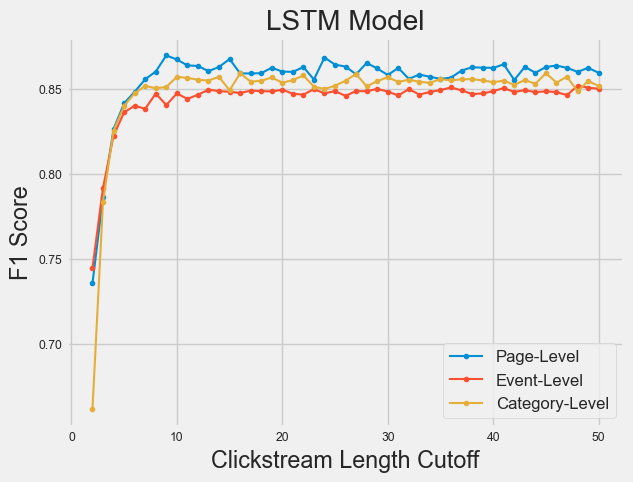

In [183]:
plt.style.use('fivethirtyeight')
plt.xlabel("Clickstream Length Cutoff")
plt.ylabel("F1 Score")

plt.title('LSTM Model')
plt.plot(range(2,51), scores_dict_page_lstm['f1_score'], label="Page-Level", marker='o',linewidth=1.5, markersize=3)
plt.plot(range(2,51), scores_dict_event_lstm['f1_score'], label="Event-Level", marker='o',linewidth=1.5, markersize=3)
plt.plot(range(2,51), scores_dict_cat_lstm['f1_score'], label="Category-Level", marker='o',linewidth=1.5, markersize=3)

plt.legend(loc='best', prop={'size': 12})
plt.show()

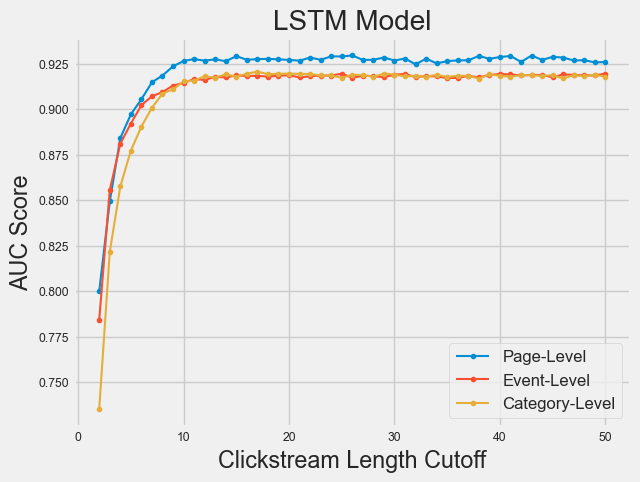

In [185]:
plt.style.use('fivethirtyeight')
plt.xlabel("Clickstream Length Cutoff")
plt.ylabel("AUC Score")

plt.title('LSTM Model')
plt.plot(range(2,51), scores_dict_page_lstm['roc_auc_score'], label="Page-Level", marker='o',linewidth=1.5, markersize=3)
plt.plot(range(2,51), scores_dict_event_lstm['roc_auc_score'], label="Event-Level", marker='o',linewidth=1.5, markersize=3)
plt.plot(range(2,51), scores_dict_cat_lstm['roc_auc_score'], label="Category-Level", marker='o',linewidth=1.5, markersize=3)

plt.legend(loc='best', prop={'size': 12})
plt.show()

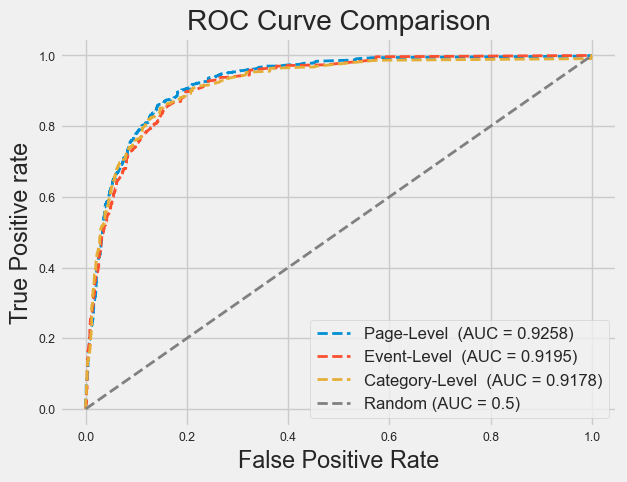

In [186]:
fpr1, tpr1, thresholds = roc_curve(y_test_page[:,1], y_probas_page)
fpr2, tpr2, thresholds = roc_curve(y_test_event[:,1], y_probas_event)
fpr3, tpr3, thresholds = roc_curve(y_test_cat[:,1], y_probas_cat)
# fpr4, tpr4, thresholds = roc_curve(y_test, y_proba_nb[:,1])

plt.style.use('fivethirtyeight')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', label='Page-Level  (AUC = '+str(round(roc_auc_score(y_test_page[:,1], y_probas_page),4))+')',linewidth=2)
plt.plot(fpr2, tpr2, linestyle='--', label='Event-Level  (AUC = '+str(round(roc_auc_score(y_test_event[:,1], y_probas_event),4))+')',linewidth=2)
plt.plot(fpr3, tpr3, linestyle='--', label='Category-Level  (AUC = '+str(round(roc_auc_score(y_test_cat[:,1], y_probas_cat),4))+')',linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='--', label='Random (AUC = 0.5)',linewidth=2, color = 'gray')
# title
plt.title('ROC Curve Comparison')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best', prop={'size': 12})
plt.savefig('ROC',dpi=300)
plt.show()

## Standard Classification Models based on Clickstream Features

In [187]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.base import TransformerMixin
from tqdm import tqdm

### Feature Engineering

In [368]:
### Count Vectorizers
def create_feature_vector_page(sample):
    vector = [0]*52
    for item in sample:
        vector[item - 1] += 1
    return vector
def create_feature_vector_event(sample):
    vector = [0]*9
    for item in sample:
        vector[item - 1] += 1
    return vector
def create_feature_vector_cat(sample):
    vector = [0]*9
    for item in sample:
        vector[item - 1] += 1
    return vector

In [369]:
### Time Vectorizers
def create_feature_vector_page_time(row):
    vector = [0]*52
    for i in range(len(row['uniq_page'])):
        vector[row['uniq_page'][i] - 1] = row['time_page'][i]
    return vector

def create_feature_vector_event_time(row):
    vector = [0]*9
    for i in range(len(row['uniq_event'])):
        vector[row['uniq_event'][i] - 1] = row['time_event'][i]
    return vector

def create_feature_vector_cat_time(row):
    vector = [0]*9
    for i in range(len(row['uniq_cat'])):
        vector[row['uniq_cat'][i] - 1] = row['time_cat'][i]
    return vector

In [370]:
def Preprocessing_feats(df_grouped, level, purchase_terms, length, lookup):
    remove_indices = []
    for term in purchase_terms:
        remove_indices.append(lookup[term])
    
    labels = []     # list of labels
    for i in df_grouped:
        if len(set(remove_indices).intersection(set(i)))>0:
            labels.append(1)
        else:
            labels.append(0)

    def remove_purchase_event(clickstream):
        new_list = []
        for event in clickstream:
            if event not in remove_indices:
                new_list.append(event)
        return new_list
    
    df_grouped_cleaned = pd.DataFrame(df_grouped)[level].apply(remove_purchase_event).tolist()
    X,y = [],[]
    for i in range(len(df_grouped_cleaned)):
        X.append(df_grouped_cleaned[i][:length])
        y.append(labels[i])
    return X, y

In [371]:
def feature_dataframe(length):
    
    # Count Features
    X_page, y_page = Preprocessing_feats(df_grouped_page, 'page_index',['Checkout Confirmation'], length, lookup_page)
    X_event, y_event = Preprocessing_feats(df_grouped_event, 'event_name_index',['purchase','exit'], length, lookup_event)
    X_cat, y_cat = Preprocessing_feats(df_grouped_cat,'page_type_index',['Checkout Confirmation'], length, lookup_cat)
    
    feature_df = pd.DataFrame()
    feature_df['purchase'] = y_page
    feature_df['clickstream_page'] = X_page
    feature_df['clickstream_event'] = X_event
    feature_df['clickstream_cat'] = X_cat
    feature_df['count_vec_page'] = feature_df['clickstream_page'].apply(create_feature_vector_page)
    feature_df['count_vec_event'] = feature_df['clickstream_event'].apply(create_feature_vector_event)
    feature_df['count_vec_cat'] = feature_df['clickstream_cat'].apply(create_feature_vector_cat)
    
    return feature_df

In [372]:
def prepare_train_test(length, level):
    
    def append_feats(row):
        return row[level]#+row['count_vec_event']+row['count_vec_cat'] #+ row['time_vec_page']+row['time_vec_event']+ row['time_vec_cat']#row['count_vec_page']+row['count_vec_event']+row['count_vec_cat']# row['count_vec_page'] + row['count_vec_event'] + row['count_vec_cat'] + row['time_vec_page'] + row['time_vec_event']+ row['time_vec_cat']
    
    X = np.array(feature_dataframe(length).apply(append_feats, axis = 1).tolist())
    y = feature_dataframe(length)['purchase']
    
    rus = RandomUnderSampler(random_state=42,sampling_strategy=0.5)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 42)
    
    return X_train, X_test, y_train, y_test

In [387]:
### SVM Model Training On Page-Level Count Vectors
scores_dict_svm_page = {'f1_score':[],'recall':[],'f1_score (purchase)':[],'accuracy':[],'roc_auc_score':[]}
for i in tqdm(range(2,31)):
    X_train, X_test, y_train, y_test = prepare_train_test(i, 'count_vec_page')
#     clf = LogisticRegression(random_state=42).fit(X_train, y_train)
    clf = SVC(probability=True).fit(X_train, y_train)
    y_preds_svm = clf.predict(X_test)
    y_probas_svm = clf.predict_proba(X_test)

    precision,recall,f1_score,_ = precision_recall_fscore_support(y_test, y_preds_svm, average='weighted')
    f1_purchase = precision_recall_fscore_support(y_test, y_preds_svm)[2][1]
    accuracy = accuracy_score(y_test, y_preds_svm)
    roc_auc = roc_auc_score(y_test, y_probas_svm[:,1], average = 'weighted')
    scores_dict_svm_page['f1_score'].append(f1_score)
    scores_dict_svm_page['recall'].append(recall)
    scores_dict_svm_page['f1_score (purchase)'].append(f1_purchase)
    scores_dict_svm_page['accuracy'].append(accuracy)
    scores_dict_svm_page['roc_auc_score'].append(roc_auc)

100%|███████████████████████████████████████████| 29/29 [04:30<00:00,  9.34s/it]


In [374]:
### SVM Model Training On Event-Level Count Vectors
scores_dict_svm_event = {'f1_score':[],'recall':[],'f1_score (purchase)':[],'accuracy':[],'roc_auc_score':[]}
for i in tqdm(range(2,31)):
    X_train, X_test, y_train, y_test = prepare_train_test(i, 'count_vec_event')
    
    clf = SVC(probability=True).fit(X_train, y_train)
    y_preds_svm = clf.predict(X_test)
    y_probas_svm = clf.predict_proba(X_test)

    precision,recall,f1_score,_ = precision_recall_fscore_support(y_test, y_preds_svm, average='weighted')
    f1_purchase = precision_recall_fscore_support(y_test, y_preds_svm)[2][1]
    accuracy = accuracy_score(y_test, y_preds_svm)
    roc_auc = roc_auc_score(y_test, y_probas_svm[:,1], average = 'weighted')
    scores_dict_svm_event['f1_score'].append(f1_score)
    scores_dict_svm_event['recall'].append(recall)
    scores_dict_svm_event['f1_score (purchase)'].append(f1_purchase)
    scores_dict_svm_event['accuracy'].append(accuracy)
    scores_dict_svm_event['roc_auc_score'].append(roc_auc)

100%|███████████████████████████████████████████| 29/29 [02:38<00:00,  5.45s/it]


In [375]:
### SVM Model Training On Category-Level Count Vectors
scores_dict_svm_cat = {'f1_score':[],'recall':[],'f1_score (purchase)':[],'accuracy':[],'roc_auc_score':[]}
for i in tqdm(range(2,31)):
    X_train, X_test, y_train, y_test = prepare_train_test(i, 'count_vec_cat')
    
    clf = SVC(probability=True).fit(X_train, y_train)
    y_preds_svm = clf.predict(X_test)
    y_probas_svm = clf.predict_proba(X_test)

    precision,recall,f1_score,_ = precision_recall_fscore_support(y_test, y_preds_svm, average='weighted')
    f1_purchase = precision_recall_fscore_support(y_test, y_preds_svm)[2][1]
    accuracy = accuracy_score(y_test, y_preds_svm)
    roc_auc = roc_auc_score(y_test, y_probas_svm[:,1], average = 'weighted')
    scores_dict_svm_cat['f1_score'].append(f1_score)
    scores_dict_svm_cat['recall'].append(recall)
    scores_dict_svm_cat['f1_score (purchase)'].append(f1_purchase)
    scores_dict_svm_cat['accuracy'].append(accuracy)
    scores_dict_svm_cat['roc_auc_score'].append(roc_auc)

100%|███████████████████████████████████████████| 29/29 [02:44<00:00,  5.69s/it]


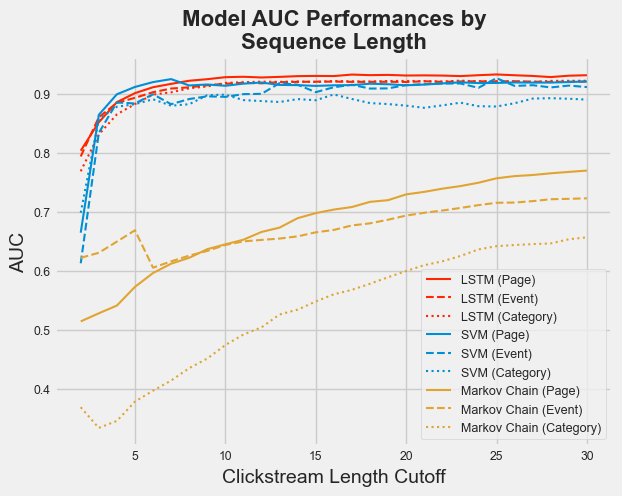

In [511]:
plt.style.use('fivethirtyeight')
plt.xlabel("Clickstream Length Cutoff", fontsize = 14)
plt.ylabel("AUC", fontsize = 14)

plt.title('Model AUC Performances by\nSequence Length', fontsize = 16, fontweight='bold')
plt.plot(range(2,31), scores_dict_page_lstm['roc_auc_score'], label="LSTM (Page)",linewidth=1.5, markersize=3, color = '#FF2700')
plt.plot(range(2,31), scores_dict_event_lstm['roc_auc_score'], label="LSTM (Event)", linestyle='--',linewidth=1.5, markersize=3, color = '#FF2700')
plt.plot(range(2,31), scores_dict_cat_lstm['roc_auc_score'], label="LSTM (Category)", linestyle=':',linewidth=1.5, markersize=3, color = '#FF2700')
plt.plot(range(2,31), scores_dict_svm_page['roc_auc_score'], label="SVM (Page)",linewidth=1.5, markersize=3, color = '#008FD5')
plt.plot(range(2,31), scores_dict_svm_event['roc_auc_score'], label="SVM (Event)", linestyle='--',linewidth=1.5, markersize=3, color = '#008FD5')
plt.plot(range(2,31), scores_dict_svm_cat['roc_auc_score'], label="SVM (Category)", linestyle=':',linewidth=1.5, markersize=3, color ='#008FD5')
plt.plot(range(2,31), scores_dict_page['roc_auc_score'], label="Markov Chain (Page)",linewidth=1.5, markersize=3, color ='#E1A431')
plt.plot(range(2,31), scores_dict_event['roc_auc_score'], label="Markov Chain (Event)", linestyle='--',linewidth=1.5, markersize=3, color ='#E1A431')
plt.plot(range(2,31), scores_dict_cat['roc_auc_score'], label="Markov Chain (Category)", linestyle=':',linewidth=1.5, markersize=3, color ='#E1A431')
plt.legend(loc='best', prop={'size': 9})
plt.show()

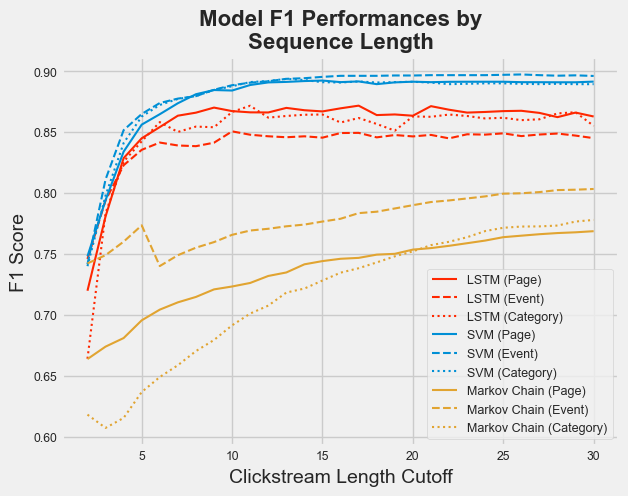

In [512]:
plt.style.use('fivethirtyeight')
plt.xlabel("Clickstream Length Cutoff", fontsize = 14)
plt.ylabel("F1 Score", fontsize = 14)

plt.title('Model F1 Performances by\nSequence Length', fontsize = 16, fontweight='bold')
plt.plot(range(2,31), scores_dict_page_lstm['f1_score'], label="LSTM (Page)",linewidth=1.5, markersize=3, color = '#FF2700')
plt.plot(range(2,31), scores_dict_event_lstm['f1_score'], label="LSTM (Event)", linestyle='--',linewidth=1.5, markersize=3, color = '#FF2700')
plt.plot(range(2,31), scores_dict_cat_lstm['f1_score'], label="LSTM (Category)", linestyle=':',linewidth=1.5, markersize=3, color = '#FF2700')
plt.plot(range(2,31), scores_dict_svm_page['f1_score'], label="SVM (Page)",linewidth=1.5, markersize=3, color = '#008FD5')
plt.plot(range(2,31), scores_dict_svm_event['f1_score'], label="SVM (Event)", linestyle='--',linewidth=1.5, markersize=3, color = '#008FD5')
plt.plot(range(2,31), scores_dict_svm_cat['f1_score'], label="SVM (Category)", linestyle=':',linewidth=1.5, markersize=3, color = '#008FD5')
plt.plot(range(2,31), scores_dict_page['f1_score'], label="Markov Chain (Page)",linewidth=1.5, markersize=3, color ='#E1A431')
plt.plot(range(2,31), scores_dict_event['f1_score'], label="Markov Chain (Event)", linestyle='--',linewidth=1.5, markersize=3, color ='#E1A431')
plt.plot(range(2,31), scores_dict_cat['f1_score'], label="Markov Chain (Category)", linestyle=':',linewidth=1.5, markersize=3, color ='#E1A431')
plt.legend(loc='best', prop={'size': 9})
plt.show()

In [285]:
# fpr1, tpr1, thresholds = roc_curve(y_test_page[:,1], y_probas_page)
# fpr2, tpr2, thresholds = roc_curve(y_test_event[:,1], y_probas_event)
# fpr3, tpr3, thresholds = roc_curve(y_test_cat[:,1], y_probas_cat)
# fpr3, tpr3, thresholds = roc_curve(y_test, y_probas_rf[:,1])
# # fpr4, tpr4, thresholds = roc_curve(y_test, y_proba_nb[:,1])

# plt.style.use('fivethirtyeight')

# # plot roc curves
# plt.plot(fpr1, tpr1, linestyle='--', label='Page-Level  (AUC = '+str(round(roc_auc_score(y_test_page[:,1], y_probas_page),4))+')',linewidth=2)
# plt.plot(fpr2, tpr2, linestyle='--', label='Event-Level  (AUC = '+str(round(roc_auc_score(y_test_event[:,1], y_probas_event),4))+')',linewidth=2)
# plt.plot(fpr3, tpr3, linestyle='--', label='Category-Level  (AUC = '+str(round(roc_auc_score(y_test_cat[:,1], y_probas_cat),4))+')',linewidth=2)
# plt.plot(fpr3, tpr3, linestyle='--', label='SVM  (AUC = '+str(round(roc_auc_score(y_test, y_probas_rf[:,1]),4))+')',linewidth=2)

# plt.plot([0, 1], [0, 1], linestyle='--', label='Random (AUC = 0.5)',linewidth=2, color = 'gray')
# # title
# plt.title('ROC Curve Comparison')
# # x label
# plt.xlabel('False Positive Rate')
# # y label
# plt.ylabel('True Positive rate')

# plt.legend(loc='best', prop={'size': 12})
# plt.savefig('ROC',dpi=300)
# plt.show()

In [548]:
### COMPARING ACROSS MODELS (F1 Score) (Category)
lstm_scores_cat = pd.DataFrame(scores_dict_cat_lstm)[['f1_score']].rename(columns = {'f1_score':'LSTM'})
mm_scores_cat = pd.DataFrame(scores_dict_cat)[['f1_score']].rename(columns = {'f1_score':'Marlov Chain'})
svm_scores_cat = pd.DataFrame(scores_dict_svm_cat)[['f1_score']].rename(columns = {'f1_score':'SVM'})

mm_scores_cat['cutoff'] = range(2,31)
mm_f1 = mm_scores_cat[(mm_scores_cat['cutoff']==5)|(mm_scores_cat['cutoff']==10)|(mm_scores_cat['cutoff']==15)|(mm_scores_cat['cutoff']==20)|(mm_scores_cat['cutoff']==25)|(mm_scores_cat['cutoff']==30)].set_index('cutoff').T
lstm_scores_cat['cutoff'] = range(2,31)
lstm_f1 = lstm_scores_cat[(lstm_scores_cat['cutoff']==5)|(lstm_scores_cat['cutoff']==10)|(lstm_scores_cat['cutoff']==15)|(lstm_scores_cat['cutoff']==20)|(lstm_scores_cat['cutoff']==25)|(lstm_scores_cat['cutoff']==30)].set_index('cutoff').T
svm_scores_cat['cutoff'] = range(2,31)
svm_f1 = svm_scores_cat[(svm_scores_cat['cutoff']==5)|(svm_scores_cat['cutoff']==10)|(svm_scores_cat['cutoff']==15)|(svm_scores_cat['cutoff']==20)|(svm_scores_cat['cutoff']==25)|(svm_scores_cat['cutoff']==30)].set_index('cutoff').T

pd.concat([mm_f1,svm_f1, lstm_f1])

cutoff              5         10        15        20        25        30
Marlov Chain  0.636517  0.691290  0.728065  0.752013  0.771369  0.777823
SVM           0.862681  0.887568  0.890890  0.891235  0.889940  0.889276
LSTM          0.842365  0.866479  0.864364  0.862771  0.861683  0.855010

In [549]:
### COMPARING ACROSS MODELS (AUC Score) (Category)
lstm_scores_cat = pd.DataFrame(scores_dict_cat_lstm)[['roc_auc_score']].rename(columns = {'roc_auc_score':'LSTM'})
mm_scores_cat = pd.DataFrame(scores_dict_cat)[['roc_auc_score']].rename(columns = {'roc_auc_score':'Marlov Chain'})
svm_scores_cat = pd.DataFrame(scores_dict_svm_cat)[['roc_auc_score']].rename(columns = {'roc_auc_score':'SVM'})

mm_scores_cat['cutoff'] = range(2,31)
mm_auc = mm_scores_cat[(mm_scores_cat['cutoff']==5)|(mm_scores_cat['cutoff']==10)|(mm_scores_cat['cutoff']==15)|(mm_scores_cat['cutoff']==20)|(mm_scores_cat['cutoff']==25)|(mm_scores_cat['cutoff']==30)].set_index('cutoff').T
lstm_scores_cat['cutoff'] = range(2,31)
lstm_auc = lstm_scores_cat[(lstm_scores_cat['cutoff']==5)|(lstm_scores_cat['cutoff']==10)|(lstm_scores_cat['cutoff']==15)|(lstm_scores_cat['cutoff']==20)|(lstm_scores_cat['cutoff']==25)|(lstm_scores_cat['cutoff']==30)].set_index('cutoff').T
svm_scores_cat['cutoff'] = range(2,31)
svm_auc = svm_scores_cat[(svm_scores_cat['cutoff']==5)|(svm_scores_cat['cutoff']==10)|(svm_scores_cat['cutoff']==15)|(svm_scores_cat['cutoff']==20)|(svm_scores_cat['cutoff']==25)|(svm_scores_cat['cutoff']==30)].set_index('cutoff').T

pd.concat([mm_auc, svm_auc,lstm_auc])

cutoff              5         10        15        20        25        30
Marlov Chain  0.378182  0.473994  0.547760  0.599447  0.641602  0.656584
SVM           0.882267  0.898414  0.888905  0.879761  0.878290  0.889984
LSTM          0.882440  0.918223  0.919900  0.921698  0.921314  0.921944

In [550]:
### COMPARING ACROSS MODELS (F1 Score) (Category)
lstm_scores_page = pd.DataFrame(scores_dict_page_lstm)[['f1_score']].rename(columns = {'f1_score':'LSTM'})
mm_scores_page = pd.DataFrame(scores_dict_page)[['f1_score']].rename(columns = {'f1_score':'Marlov Chain'})
svm_scores_page = pd.DataFrame(scores_dict_svm_page)[['f1_score']].rename(columns = {'f1_score':'SVM'})

mm_scores_page['cutoff'] = range(2,31)
mm_f1 = mm_scores_page[(mm_scores_page['cutoff']==5)|(mm_scores_page['cutoff']==10)|(mm_scores_page['cutoff']==15)|(mm_scores_page['cutoff']==20)|(mm_scores_page['cutoff']==25)|(mm_scores_page['cutoff']==30)].set_index('cutoff').T
lstm_scores_page['cutoff'] = range(2,31)
lstm_f1 = lstm_scores_page[(lstm_scores_page['cutoff']==5)|(lstm_scores_page['cutoff']==10)|(lstm_scores_page['cutoff']==15)|(lstm_scores_page['cutoff']==20)|(lstm_scores_page['cutoff']==25)|(lstm_scores_page['cutoff']==30)].set_index('cutoff').T
svm_scores_page['cutoff'] = range(2,31)
svm_f1 = svm_scores_page[(svm_scores_page['cutoff']==5)|(svm_scores_page['cutoff']==10)|(svm_scores_page['cutoff']==15)|(svm_scores_page['cutoff']==20)|(svm_scores_page['cutoff']==25)|(svm_scores_page['cutoff']==30)].set_index('cutoff').T

pd.concat([mm_f1,svm_f1, lstm_f1])

cutoff              5         10        15        20        25        30
Marlov Chain  0.695392  0.723164  0.744026  0.753452  0.763651  0.768578
SVM           0.856063  0.884048  0.892236  0.891294  0.891265  0.891373
LSTM          0.844849  0.867155  0.866904  0.863364  0.867151  0.862728

In [551]:
### COMPARING ACROSS MODELS (AUC Score) (Category)
lstm_scores_page = pd.DataFrame(scores_dict_page_lstm)[['roc_auc_score']].rename(columns = {'roc_auc_score':'LSTM'})
mm_scores_page = pd.DataFrame(scores_dict_page)[['roc_auc_score']].rename(columns = {'roc_auc_score':'Marlov Chain'})
svm_scores_page = pd.DataFrame(scores_dict_svm_page)[['roc_auc_score']].rename(columns = {'roc_auc_score':'SVM'})

mm_scores_page['cutoff'] = range(2,31)
mm_auc = mm_scores_page[(mm_scores_page['cutoff']==5)|(mm_scores_page['cutoff']==10)|(mm_scores_page['cutoff']==15)|(mm_scores_page['cutoff']==20)|(mm_scores_page['cutoff']==25)|(mm_scores_page['cutoff']==30)].set_index('cutoff').T
lstm_scores_page['cutoff'] = range(2,31)
lstm_auc = lstm_scores_page[(lstm_scores_page['cutoff']==5)|(lstm_scores_page['cutoff']==10)|(lstm_scores_page['cutoff']==15)|(lstm_scores_page['cutoff']==20)|(lstm_scores_page['cutoff']==25)|(lstm_scores_page['cutoff']==30)].set_index('cutoff').T
svm_scores_page['cutoff'] = range(2,31)
svm_auc = svm_scores_page[(svm_scores_page['cutoff']==5)|(svm_scores_page['cutoff']==10)|(svm_scores_page['cutoff']==15)|(svm_scores_page['cutoff']==20)|(svm_scores_page['cutoff']==25)|(svm_scores_page['cutoff']==30)].set_index('cutoff').T

pd.concat([mm_auc, svm_auc,lstm_auc])

cutoff              5         10        15        20        25        30
Marlov Chain  0.572615  0.644700  0.697606  0.729369  0.756644  0.769718
SVM           0.911458  0.913448  0.913241  0.914246  0.918275  0.920800
LSTM          0.900944  0.928018  0.930156  0.930854  0.932640  0.931357

In [552]:
### COMPARING ACROSS MODELS (F1 Score) (Category)
lstm_scores_event = pd.DataFrame(scores_dict_event_lstm)[['f1_score']].rename(columns = {'f1_score':'LSTM'})
mm_scores_event = pd.DataFrame(scores_dict_event)[['f1_score']].rename(columns = {'f1_score':'Marlov Chain'})
svm_scores_event = pd.DataFrame(scores_dict_svm_event)[['f1_score']].rename(columns = {'f1_score':'SVM'})

mm_scores_event['cutoff'] = range(2,31)
mm_f1 = mm_scores_event[(mm_scores_event['cutoff']==5)|(mm_scores_event['cutoff']==10)|(mm_scores_event['cutoff']==15)|(mm_scores_event['cutoff']==20)|(mm_scores_event['cutoff']==25)|(mm_scores_event['cutoff']==30)].set_index('cutoff').T
lstm_scores_event['cutoff'] = range(2,31)
lstm_f1 = lstm_scores_event[(lstm_scores_event['cutoff']==5)|(lstm_scores_event['cutoff']==10)|(lstm_scores_event['cutoff']==15)|(lstm_scores_event['cutoff']==20)|(lstm_scores_event['cutoff']==25)|(lstm_scores_event['cutoff']==30)].set_index('cutoff').T
svm_scores_event['cutoff'] = range(2,31)
svm_f1 = svm_scores_event[(svm_scores_event['cutoff']==5)|(svm_scores_event['cutoff']==10)|(svm_scores_event['cutoff']==15)|(svm_scores_event['cutoff']==20)|(svm_scores_event['cutoff']==25)|(svm_scores_event['cutoff']==30)].set_index('cutoff').T

pd.concat([mm_f1,svm_f1, lstm_f1])

cutoff              5         10        15        20        25        30
Marlov Chain  0.773376  0.765590  0.776493  0.789926  0.799379  0.803233
SVM           0.864797  0.888430  0.895266  0.896387  0.896960  0.896018
LSTM          0.835373  0.850534  0.845360  0.846386  0.848901  0.844952

In [553]:
### COMPARING ACROSS MODELS (AUC Score) (Category)
lstm_scores_event = pd.DataFrame(scores_dict_event_lstm)[['roc_auc_score']].rename(columns = {'roc_auc_score':'LSTM'})
mm_scores_event = pd.DataFrame(scores_dict_event)[['roc_auc_score']].rename(columns = {'roc_auc_score':'Marlov Chain'})
svm_scores_event = pd.DataFrame(scores_dict_svm_event)[['roc_auc_score']].rename(columns = {'roc_auc_score':'SVM'})

mm_scores_event['cutoff'] = range(2,31)
mm_auc = mm_scores_event[(mm_scores_event['cutoff']==5)|(mm_scores_event['cutoff']==10)|(mm_scores_event['cutoff']==15)|(mm_scores_event['cutoff']==20)|(mm_scores_event['cutoff']==25)|(mm_scores_event['cutoff']==30)].set_index('cutoff').T
lstm_scores_event['cutoff'] = range(2,31)
lstm_auc = lstm_scores_event[(lstm_scores_event['cutoff']==5)|(lstm_scores_event['cutoff']==10)|(lstm_scores_event['cutoff']==15)|(lstm_scores_event['cutoff']==20)|(lstm_scores_event['cutoff']==25)|(lstm_scores_event['cutoff']==30)].set_index('cutoff').T
svm_scores_event['cutoff'] = range(2,31)
svm_auc = svm_scores_event[(svm_scores_event['cutoff']==5)|(svm_scores_event['cutoff']==10)|(svm_scores_event['cutoff']==15)|(svm_scores_event['cutoff']==20)|(svm_scores_event['cutoff']==25)|(svm_scores_event['cutoff']==30)].set_index('cutoff').T

pd.concat([mm_auc, svm_auc,lstm_auc])

cutoff              5         10        15        20        25        30
Marlov Chain  0.668519  0.643633  0.665046  0.693437  0.715147  0.722719
SVM           0.883439  0.894674  0.902596  0.914673  0.926394  0.911248
LSTM          0.893036  0.916894  0.920388  0.919885  0.920607  0.920501

In [880]:
roc_auc_score(y_test, y_probas_logreg[:,1])

0.5002434904261507

In [881]:
np.array(np.unique(y_preds_rf , return_counts=True)).T

array([[   0, 2747],
       [   1,  617]])

In [882]:
np.array(np.unique(y_test , return_counts=True)).T

array([[   0, 2281],
       [   1, 1083]])

In [433]:
import numpy as np

In [546]:
def plot_history(history):
    # This function will plot the model fit process
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'],linewidth=1.5)
    plt.plot(history.history['val_loss'],linewidth=1.5)
    plt.title('LSTM Model Loss', fontsize = 16, fontweight='bold')
    plt.ylabel('Loss', fontsize = 14)
    plt.xlabel('Epoch', fontsize = 14)
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


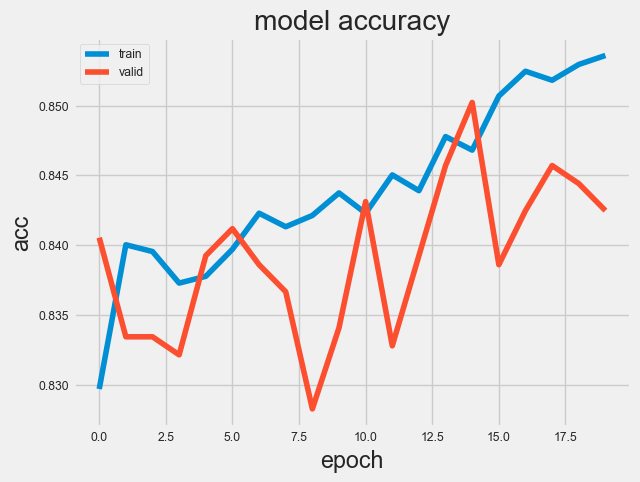

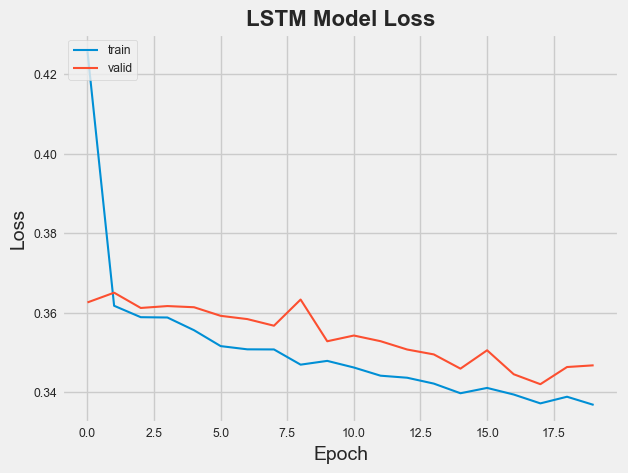

In [547]:
plot_history(lstm_history)

In [470]:
print(X_cat[5:10, :])

[[5 5 5 ... 0 0 0]
 [5 5 5 ... 0 0 0]
 [5 5 5 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]]


In [472]:
np.set_printoptions(threshold=50, linewidth = 200)

In [520]:
padded_seqs = [['P3','P4','P1','P1',0,0,0,0,0,0],['P2','P3','P3','P4','P3','P3','P4','P2','P3','P3'],['P2','P5','P7','P5','P5','P4',0,0,0,0],['P2','P3','P2','P2','P1','P2','P1','P4','P9',0],['P2','P3','P3','P5',0,0,0,0,0,0]]

In [521]:
pd.DataFrame({'session_id':sess_df.groupby('session_id').head(1)['session_id'].tolist()[:5],
              'padded_sequence':padded_seqs,
              'purchase':[0,0,0,1,0]})

session_id                           padded_sequence  purchase
0  1000009091        [P3, P4, P1, P1, 0, 0, 0, 0, 0, 0]         0
1  1000075392  [P2, P3, P3, P4, P3, P3, P4, P2, P3, P3]         0
2  1000172345      [P2, P5, P7, P5, P5, P4, 0, 0, 0, 0]         0
3  1000175006   [P2, P3, P2, P2, P1, P2, P1, P4, P9, 0]         1
4  1000178538        [P2, P3, P3, P5, 0, 0, 0, 0, 0, 0]         0

In [518]:
seqs = [['P3','P4','P1','P1'],['P2','P3','P3','P4','P3','P3','P4','P2','P3','P3'],['P2','P5','P7','P5','P5','P4'],['P2','P3','P2','P2','P1','P2','P1','P4','P9'],['P2','P3','P3','P5']]

In [519]:
pd.DataFrame({'session_id':sess_df.groupby('session_id').head(1)['session_id'].tolist()[:5],
              'sequence':seqs,
              'purchase':[0,0,0,1,0]})

session_id                                  sequence  purchase
0  1000009091                          [P3, P4, P1, P1]         0
1  1000075392  [P2, P3, P3, P4, P3, P3, P4, P2, P3, P3]         0
2  1000172345                  [P2, P5, P7, P5, P5, P4]         0
3  1000175006      [P2, P3, P2, P2, P1, P2, P1, P4, P9]         1
4  1000178538                          [P2, P3, P3, P5]         0

In [485]:
sess_df.groupby('session_id').head(1)['session_id'].tolist()[:5]

['1000009091', '1000075392', '1000172345', '1000175006', '1000178538']

In [318]:
with tf.device('/cpu:0'):
    tf.keras.backend.clear_session()
    training_model = LSTM_model(neurons=40, op=5)
    training_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 80)            14720     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 160)              103040    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 322       
                                                                 
Total params: 118,082
Trainable params: 118,082
Non-trainable params: 0
_________________________________________________________________


In [323]:
res = np.argmax(training_model.predict(X_test_page), axis=-1)

2022-12-10 03:10:43.818875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-10 03:10:43.912354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-10 03:10:43.920530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-10 03:10:43.990267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-10 03:10:43.999627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 0s 11ms/step


In [414]:
np.array(np.unique(y_resampled , return_counts=True)).T

array([[   0, 7474],
       [   1, 3737]])

In [ ]:
# class MarkovModel():
    
#     def __init__(self):
#         self.preds = []
        
#     def fit(self, X_p_train, X_np_train, y_p_train, y_np_train):
#         self.m_p = MarkovClickstream(X_p_train)
#         self.m_np = MarkovClickstream(X_np_train)
        
#     def predict(self, test_X, cutoff = None):
#         self.cutoff = cutoff
#         self.preds = []
#         # Predicting Purchase Probabilities
#         m_p_probs = []
#         for pages in test_X:
#             if self.cutoff == None:
#                 m_p_probs.append(self.m_p.calc_prob_to_page(pages))
#             else:
#                 m_p_probs.append(self.m_p.calc_prob_to_page(pages[:self.cutoff]))
            
#         # Predicting Non-Purchase Probabilities
#         m_np_probs = []
#         for pages in test_X:
#             if self.cutoff == None:
#                 m_np_probs.append(self.m_np.calc_prob_to_page(pages))
#             else:
#                 m_np_probs.append(self.m_np.calc_prob_to_page(pages[:self.cutoff]))
        
#         # Labelling
#         for i in range(len(m_p_probs)):
#             if m_p_probs[i] > m_np_probs[i]:
#                 self.preds.append(1)
#             elif m_p_probs[i] <= m_np_probs[i]:
#                 self.preds.append(0)